In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
import warnings
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import requests
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot

from sklearn.linear_model import LinearRegression

import plotly.express as px


warnings.simplefilter("ignore")


# Example: Load an Excel file
excel_df = pd.read_excel('consumption_monthly.xlsx')

#csv_df = pd.read_csv('your_file.csv')

In [13]:
#Data collection

api_key = "FWNg2ka2JJ3cGCK658LuphdOf59QgufSNvvGwBgf"

url = "https://api.eia.gov/v2/electricity/electric-power-operational-data/data"

params = {
    "api_key": api_key,
    "frequency": "monthly",
    "start": "2001-01",
    "end": "2025-09",
    "length": 5000,
    
    # The columns you requested
    "data[0]": "consumption-for-eg-btu",
    "data[1]": "consumption-uto-btu",
    "data[2]": "cost-per-btu",
    "data[3]": "generation",
    "data[4]": "heat-content",
    "data[5]": "receipts-btu",
    "data[6]": "stocks",
    "data[7]": "sulfur-content",
    "data[8]": "total-consumption-btu",

    # Sorting
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    
    # Facets (Filters)
    "facets[location][]": "TX",
    "facets[sectorid][]": "99",
    
    "facets[fueltypeid][]": [
        "ALL", "COL", "GEO", "HPS", "HYC", 
        "NG", "NUC", "OOG", "OTH", "PC", "PEL", "SUN", 
        "WAS", "WND", "WWW"
    ]
}

response = requests.get(url, params=params)

if response.status_code == 200:
    json_data = response.json()
    data_rows = json_data['response']['data']
    df = pd.DataFrame(data_rows)


In [14]:
#Data processing

cols_to_drop = []

for col in df.columns:
    if (len(df[col].unique()) == 1):
        cols_to_drop.append(col)
df.drop(columns = cols_to_drop, inplace=True)

df['generation'] = df['generation'].fillna(0)

numeric_cols = [
    'consumption-for-eg-btu',
    'consumption-uto-btu',
    'cost-per-btu',
    'generation',
    'heat-content',
    'receipts-btu',
    'stocks',
    'sulfur-content',
    'total-consumption-btu'
]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['period'] = pd.to_datetime(df['period'])

df.set_index('period', inplace=True)
df['year'] = df.index.year
df['month'] = df.index.month

df.to_csv('eia_monthly_data.csv')


In [15]:
month_year_grouped = df.groupby([df.index.year, df.index.month])

group = month_year_grouped.get_group((2001, 1))

In [16]:
#Below, we check for discrepancies between each fuel type and total fuel

for (year, month), group in month_year_grouped:
    group = month_year_grouped.get_group((year, month))

    generation_sum = group.loc[group['fueltypeid'] != 'ALL', 'generation'].sum()
    generation_all = group.loc[group['fueltypeid'] == 'ALL', 'generation'].values

    error = generation_all - generation_sum

    if ((error > 1) | (error < -1)):
        print(f'ERROR: {month}, {year}, {error}, {generation_all}, {generation_sum}')



ERROR: 11, 2011, [19.50382], [29824.51776], 29805.01394
ERROR: 5, 2020, [8.5803], [38518.73069], 38510.15038999999
ERROR: 1, 2025, [33.72366], [50546.36669], 50512.64302999999
ERROR: 3, 2025, [13.99953], [43076.59418], 43062.59465


In [17]:
fueltype_grouped = df.groupby("fuelTypeDescription")
fueltype_dfs = {name: group.copy() for name, group in fueltype_grouped}

In [18]:
fueltype_dfs['all fuels']

fueltypeid fuelTypeDescription  consumption-for-eg-btu  \
period                                                              
2025-09-01        ALL           all fuels               371.80433   
2025-08-01        ALL           all fuels               417.68933   
2025-07-01        ALL           all fuels               406.22913   
2025-06-01        ALL           all fuels               367.69164   
2025-05-01        ALL           all fuels               333.46031   
...               ...                 ...                     ...   
2001-05-01        ALL           all fuels               319.45700   
2001-04-01        ALL           all fuels               273.29500   
2001-03-01        ALL           all fuels               271.80700   
2001-02-01        ALL           all fuels               254.82100   
2001-01-01        ALL           all fuels               302.33100   

            consumption-uto-btu  cost-per-btu   generation  heat-content  \
period                                                                     
2025-09-01             40.29372           NaN  51969.47648          0.00   
2025-08-01             40.86726           NaN  58074.24094          0.00   
2025-07-01             41.29126           NaN  57847.47218          0.00   
2025-06-01             40.16086           NaN  53731.09517          0.00   
2025-05-01             38.98725           NaN  49442.04178          0.00   
...                         ...           ...          ...           ...   
2001-05-01             32.82200           NaN  31583.45900          6.52   
2001-04-01             31.24400           NaN  27486.31500          6.41   
2001-03-01             35.33300           NaN  27580.33900          7.33   
2001-02-01             31.83300           NaN  25626.52100          7.20   
2001-01-01             36.57100           NaN  31001.28000          7.00   

                heat-content-units  receipts-btu     stocks  \
period                                                        
2025-09-01  Btu per physical units           NaN        NaN   
2025-08-01  Btu per physical units           NaN        NaN   
2025-07-01  Btu per physical units           NaN        NaN   
2025-06-01  Btu per physical units           NaN        NaN   
2025-05-01  Btu per physical units           NaN        NaN   
...                            ...           ...        ...   
2001-05-01  Btu per physical units  212337.81082  14788.058   
2001-04-01  Btu per physical units  192177.95845  15015.928   
2001-03-01  Btu per physical units  167503.13576  14320.514   
2001-02-01  Btu per physical units  148634.82318  14563.221   
2001-01-01  Btu per physical units  184318.67345  14812.817   

                       stocks-units  sulfur-content  total-consumption-btu  \
period                                                                       
2025-09-01  thousand physical units             NaN              412.09806   
2025-08-01  thousand physical units             NaN              458.55659   
2025-07-01  thousand physical units             NaN              447.52039   
2025-06-01  thousand physical units             NaN              407.85250   
2025-05-01  thousand physical units             NaN              372.44756   
...                             ...             ...                    ...   
2001-05-01  thousand physical units            0.05              352.28100   
2001-04-01  thousand physical units            0.06              304.53800   
2001-03-01  thousand physical units            0.06              307.14000   
2001-02-01  thousand physical units            0.08              286.64700   
2001-01-01  thousand physical units            0.07              338.90200   

            year  month  
period                   
2025-09-01  2025      9  
2025-08-01  2025      8  
2025-07-01  2025      7  
2025-06-01  2025      6  
2025-05-01  2025      5  
...          ...    ...  
2001-05-01  2001      5  
2001-04-01  2001      4  
2001-03-01  2001      3  
200

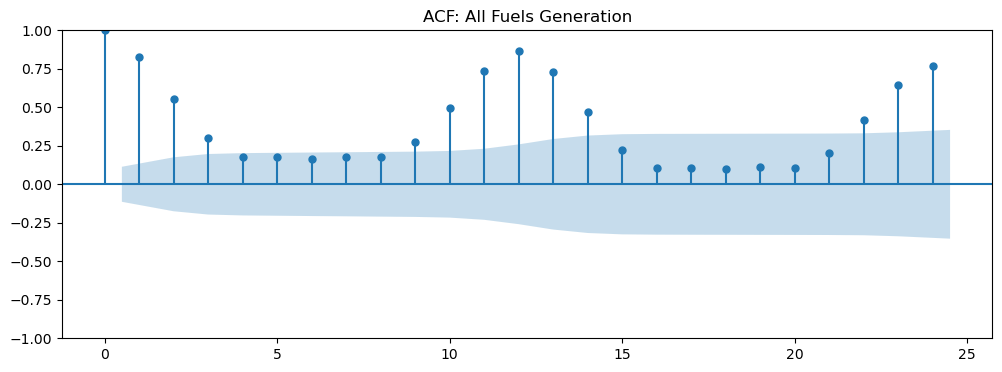

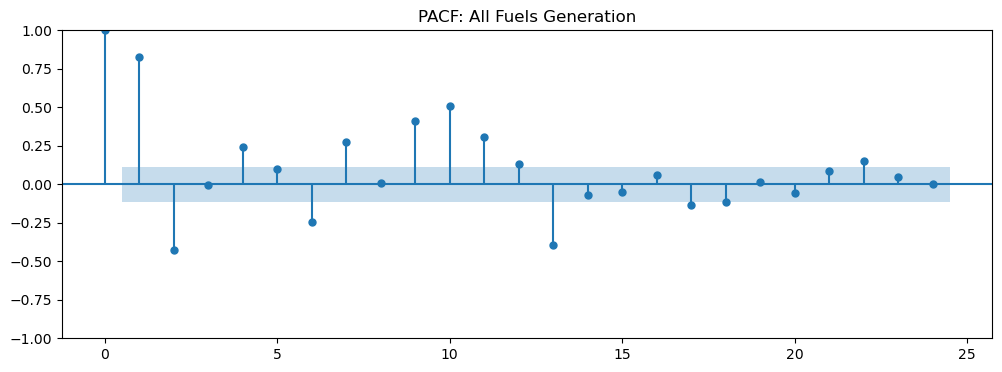

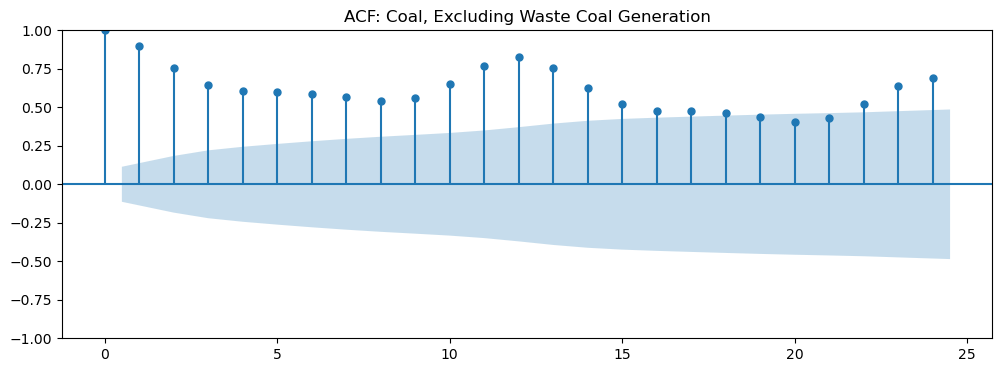

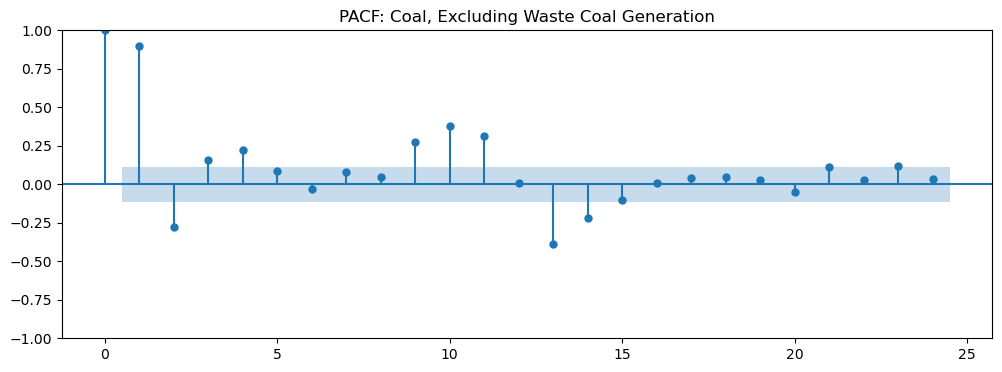

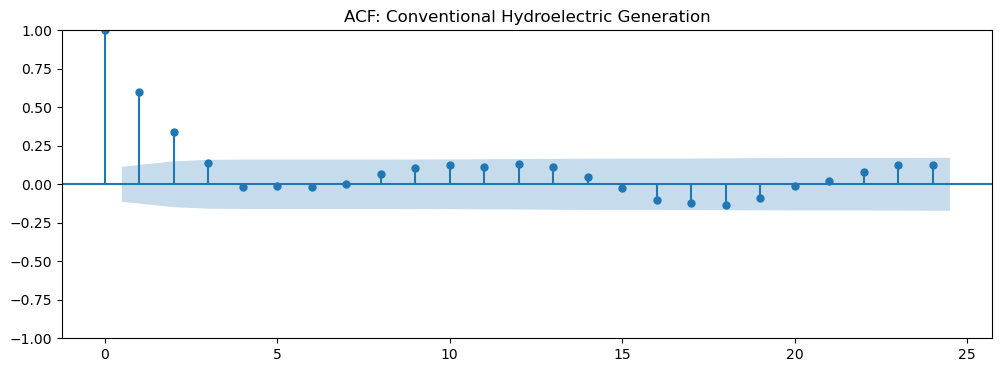

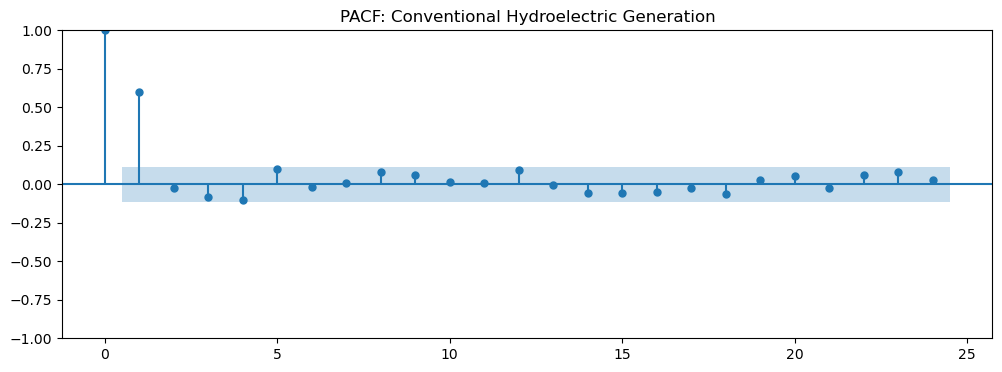

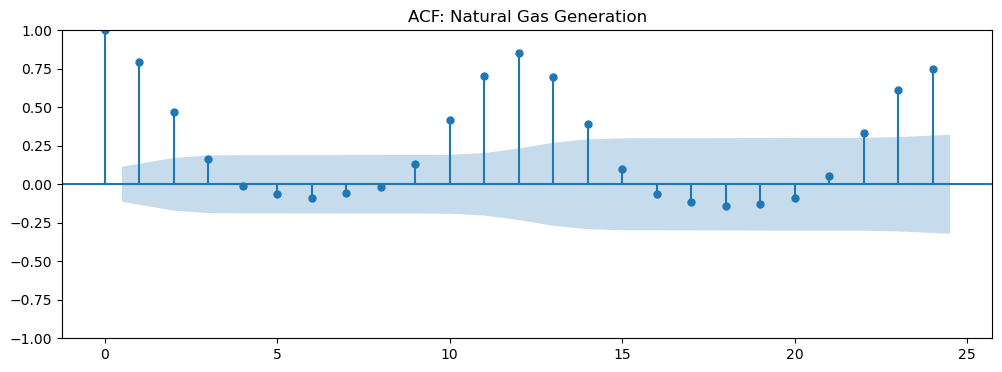

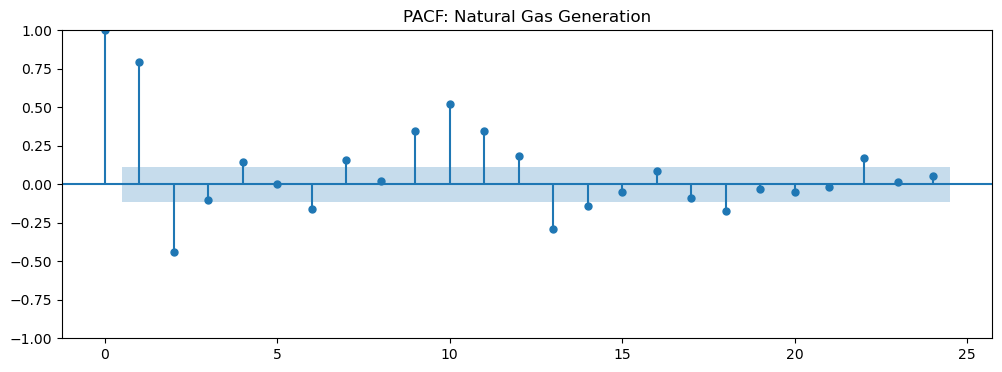

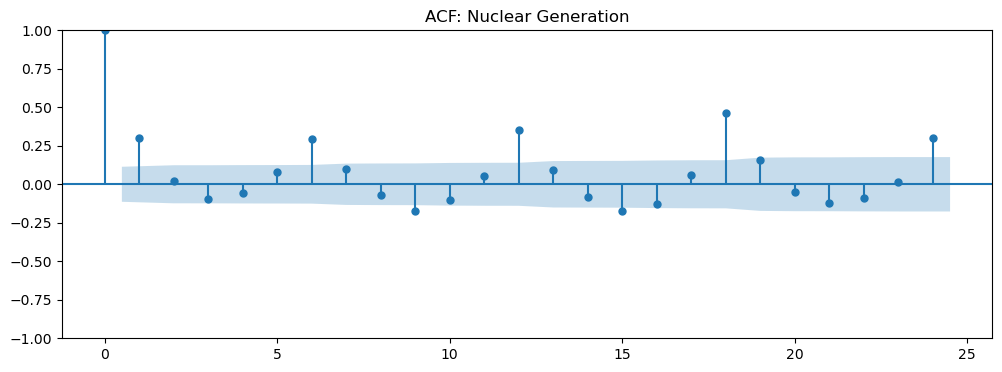

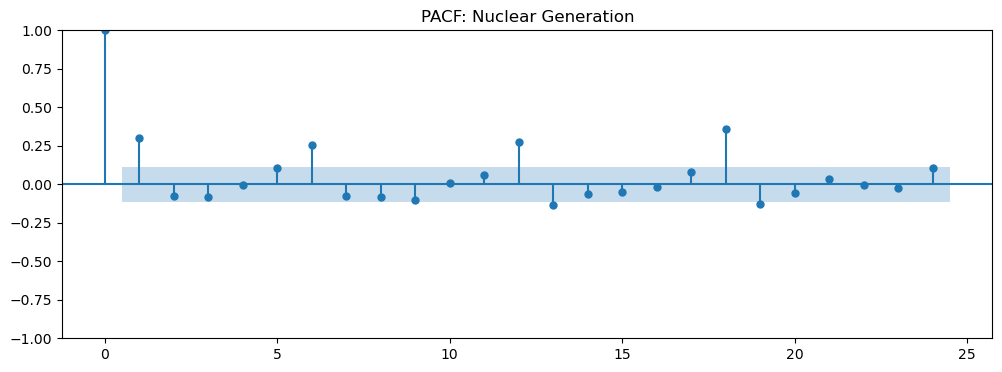

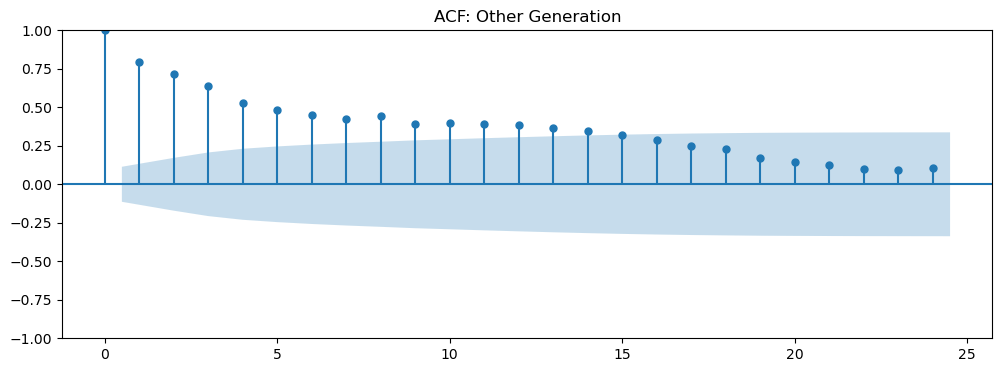

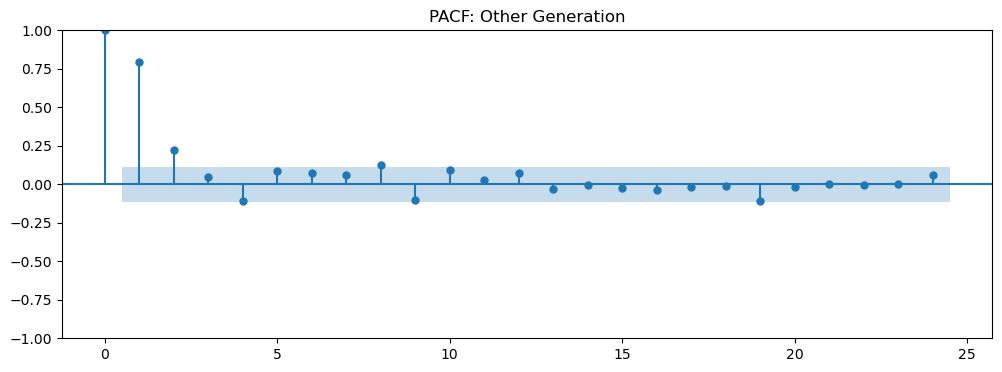

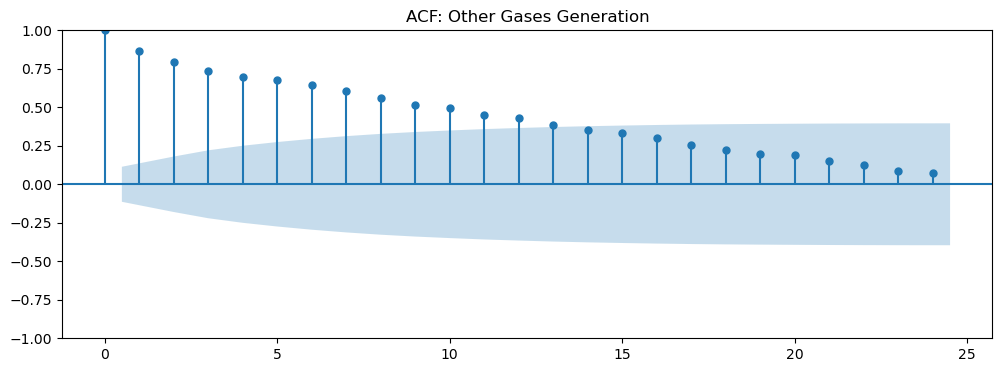

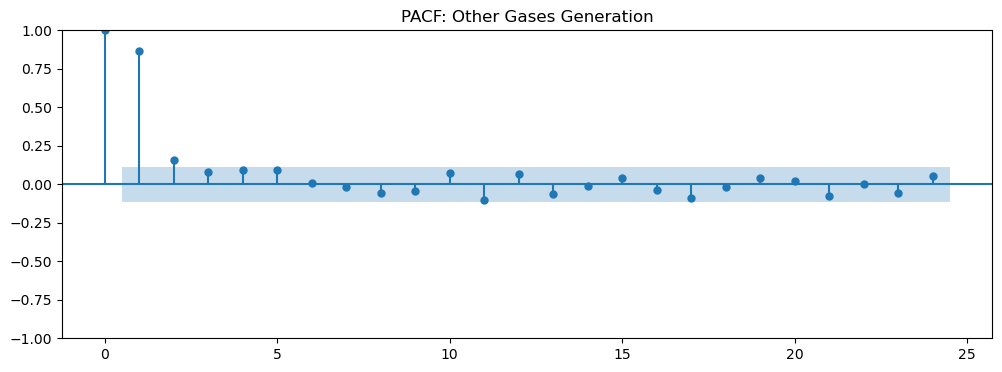

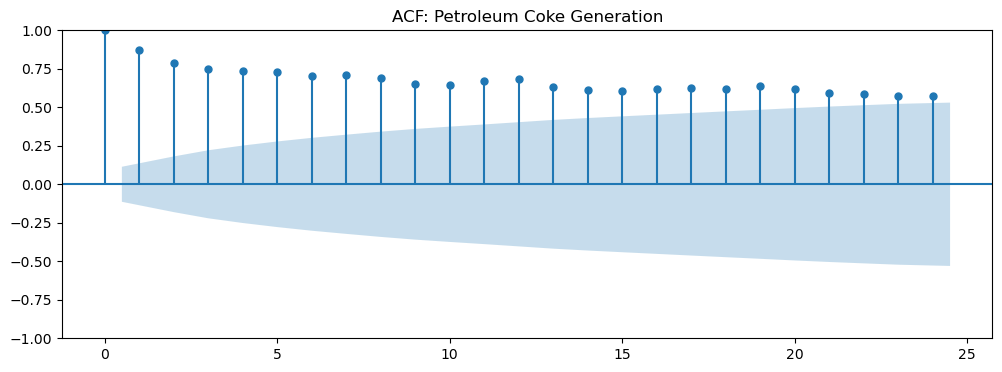

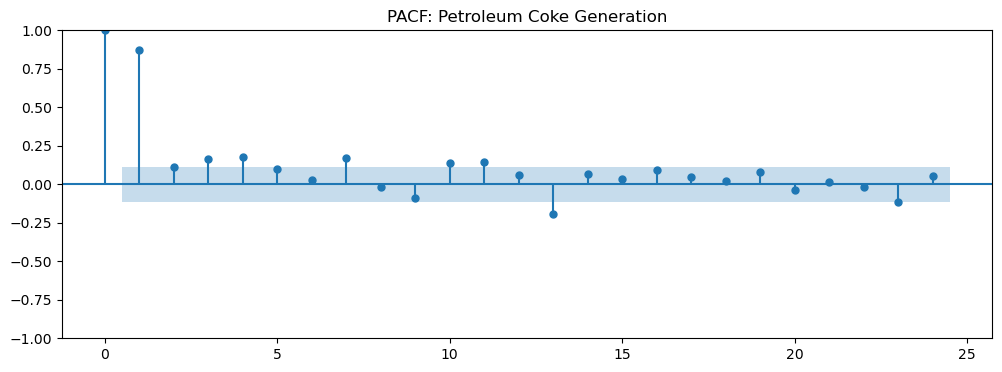

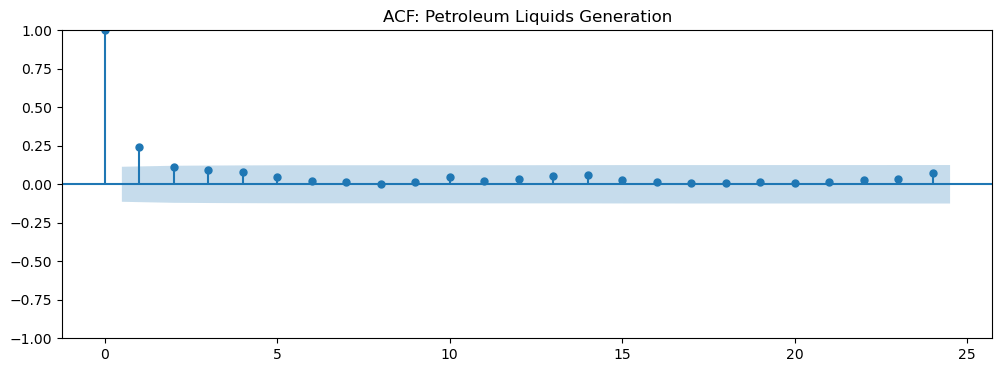

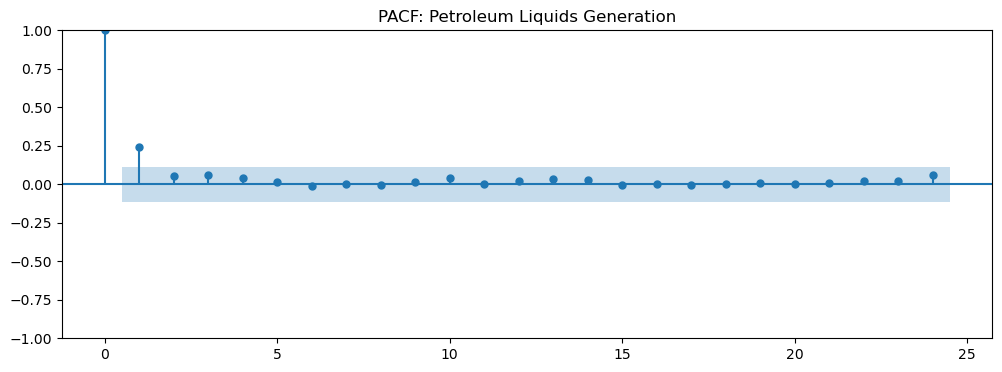

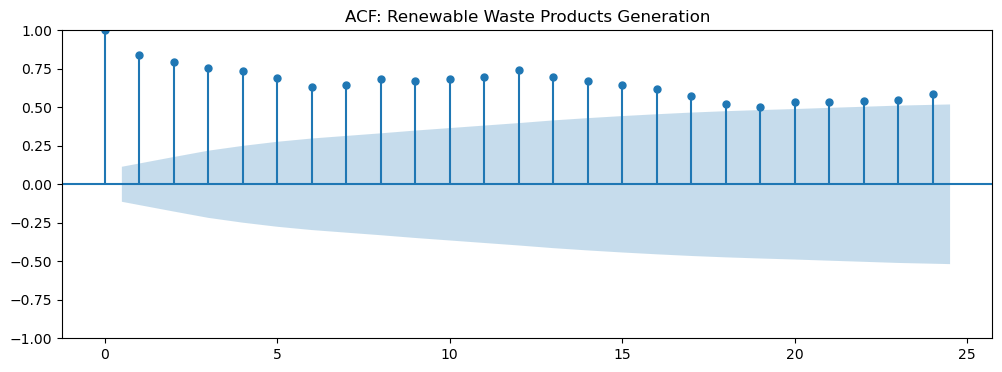

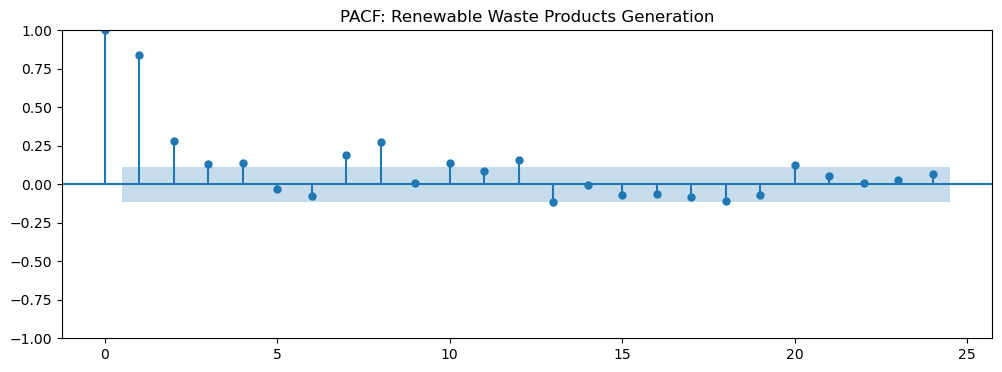

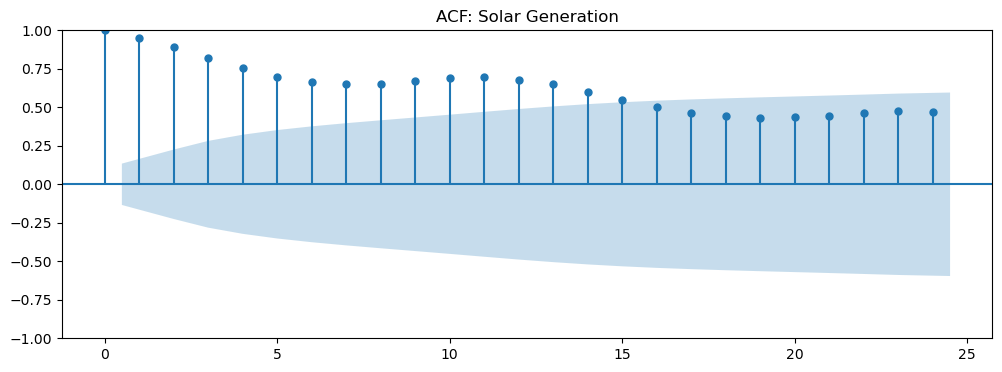

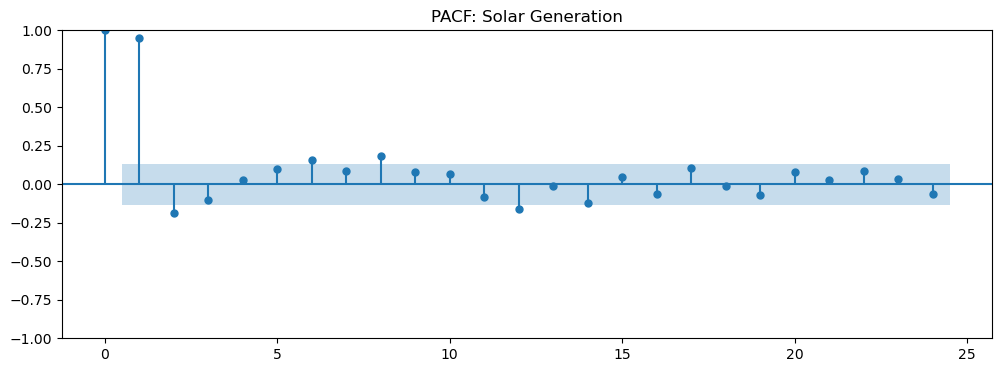

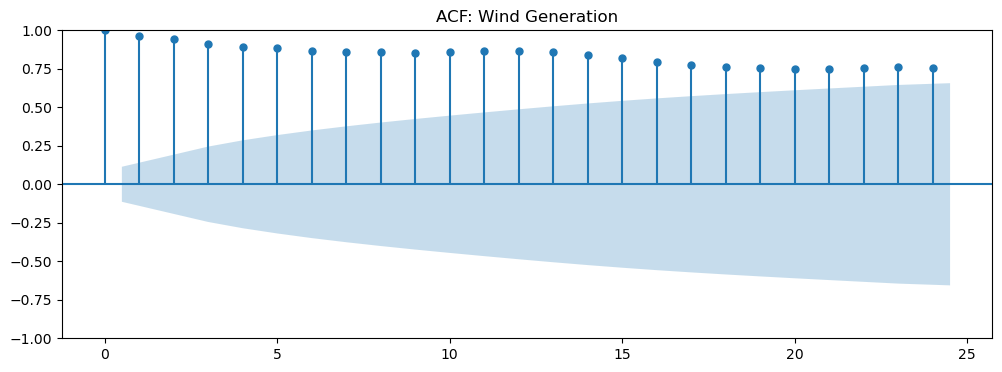

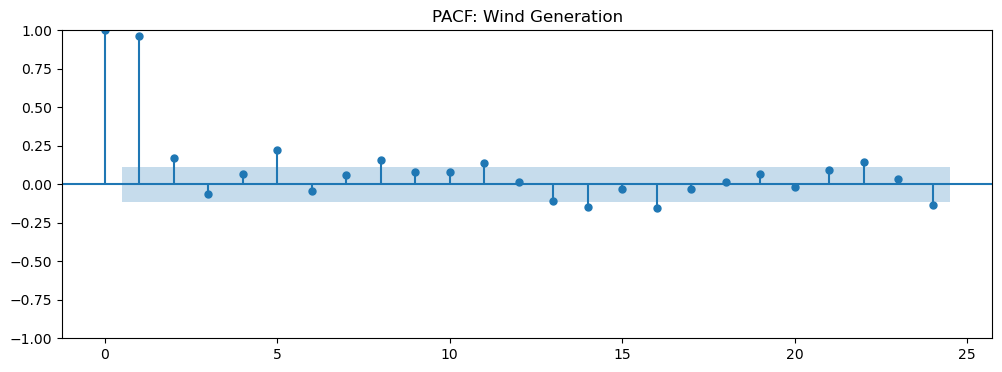

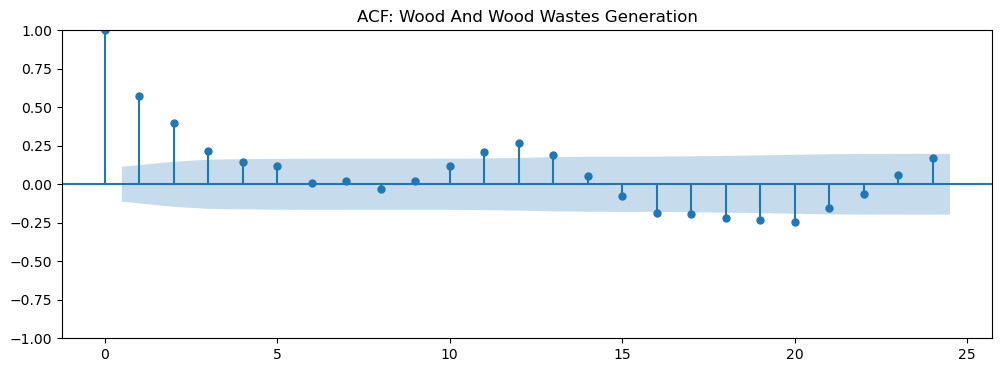

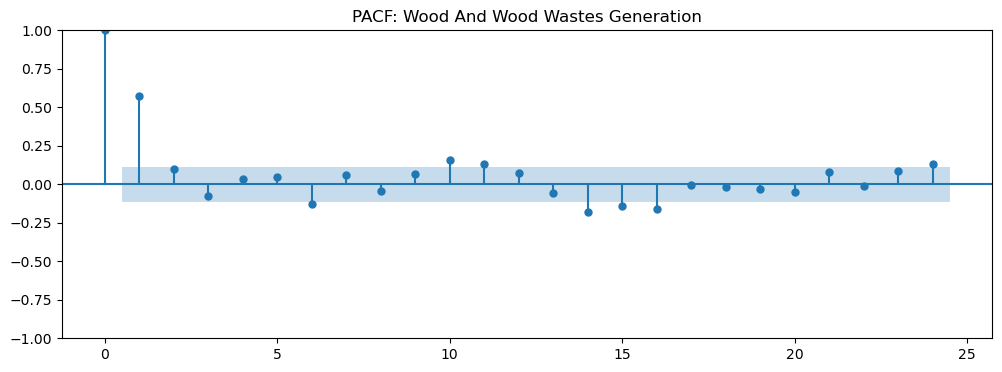

In [19]:
for key in fueltype_dfs.keys():
    series = fueltype_dfs[key]['generation'].dropna()
    
    plt.figure(figsize=(12, 4))
    plot_acf(series, lags=24, ax=plt.gca())
    plt.title(f"ACF: {key.title()} Generation")
    plt.show()
    
    plt.figure(figsize=(12, 4))
    plot_pacf(series, lags=24, ax=plt.gca())
    plt.title(f"PACF: {key.title()} Generation")
    plt.show()


In [20]:
new_breakdown = df.pivot_table(index=df.index, columns='fuelTypeDescription', values='generation', aggfunc='sum')

In [21]:
new_breakdown

fuelTypeDescription    all fuels  coal, excluding waste coal  \
period                                                         
2001-01-01           31001.28000                 11683.91100   
2001-02-01           25626.52100                 10236.78600   
2001-03-01           27580.33900                 11004.47000   
2001-04-01           27486.31500                  9767.22500   
2001-05-01           31583.45900                 11449.39700   
...                          ...                         ...   
2025-05-01           49442.04178                  4902.17097   
2025-06-01           53731.09517                  5967.57327   
2025-07-01           57847.47218                  6817.80050   
2025-08-01           58074.24094                  6954.19688   
2025-09-01           51969.47648                  6490.75707   

fuelTypeDescription  conventional hydroelectric  natural gas   nuclear  \
period                                                                   
2001-01-01                            138.09300  13750.54600  3545.310   
2001-02-01                            110.14800  11507.83400  3037.626   
2001-03-01                            180.14000  13316.33500  2462.837   
2001-04-01                            124.23200  14402.41700  2668.816   
2001-05-01                            115.10200  16025.87800  3419.870   
...                                         ...          ...       ...   
2025-05-01                            142.82981  24856.76131  3298.128   
2025-06-01                            119.77276  26301.55780  3599.212   
2025-07-01                            104.94906  30221.26513  3699.006   
2025-08-01                             96.62501  32570.81021  3683.574   
2025-09-01                             76.39725  28369.28312  3380.834   

fuelTypeDescription      other  other gases  petroleum coke  \
period                                                        
2001-01-01           132.65221    146.04400        85.11800   
2001-02-01            92.54463    114.43300        71.75900   
2001-03-01            82.43581    151.88400       105.59700   
2001-04-01           116.11406     81.25900        79.26200   
2001-05-01           117.56265    148.25900       100.36300   
...                        ...          ...             ...   
2025-05-01           -51.20720    156.03350         5.45988   
2025-06-01           -60.62348    206.18596         5.01818   
2025-07-01           -62.47163    207.13409         6.06161   
2025-08-01          -129.00794    166.73555         5.46752   
2025-09-01           -75.17441    171.43109         4.47810   

fuelTypeDescription  petroleum liquids  renewable waste products       solar  \
period                                                                         
2001-01-01                  1343.65300                   8.58680     0.00000   
2001-02-01                   232.03300                   7.46237     0.00000   
2001-03-01                   107.81700                   8.09819     0.00000   
2001-04-01                    54.73400                   5.76394     0.00000   
2001-05-01                    17.01800                   7.50835     0.00000   
...                                ...                       ...         ...   
2025-05-01                    12.29770                  16.37854  5527.56180   
2025-06-01                    13.35556                  16.61207  5928.92731   
2025-07-01                    13.48337                  16.75794  6209.69318   
2025-08-01                     9.51411                  16.39869  6337.13296   
2025-09-01                     8.40138                  15.61986  5878.70632   

fuelTypeDescription         wind  wood and wood wastes  
period                                                  
2001-01-01              83.93100              83.43500  
2001-02-01             141.64700              74.24800  
2001-03-01              87.63100              73.09400  
2001-04-01             115.48700              71.00500  
2

In [22]:

df_components = new_breakdown.drop(columns=['all fuels'])

df_normalized = df_components.div(new_breakdown['all fuels'], axis=0)

fig = px.bar(df_normalized, x=df_normalized.index, y=df_normalized.columns)

fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Proportion",
    legend_title="Fuel Type",
    xaxis=dict(tickangle=-45)
)

fig.show()

In [23]:

top_pacf_values = {}

for key in fueltype_dfs.keys():
    series = fueltype_dfs[key]['generation'].dropna()

    last_48 = series[-48:]
    if len(last_48) < 2:
        continue
    pacf_vals = pacf(last_48, nlags=24, method='ywm')

    pacf_lags = pacf_vals[1:]

    top5_idx = pacf_lags.argsort()[-5:][::-1] #most significant correlations and the lags. 
    top5 = [(lag+1, pacf_lags[lag]) for lag in top5_idx]
    top_pacf_values[key] = top5

top_pacf_values

{'all fuels': [(1, 0.698540729066504),
  (10, 0.19998810051322272),
  (19, 0.15284494982560534),
  (16, 0.1484380993237057),
  (11, 0.14223844762763363)],
 'coal, excluding waste coal': [(1, 0.5107953307147246),
  (12, 0.3003128151729291),
  (11, 0.2695845533114287),
  (10, 0.25779201453209444),
  (4, 0.14247165381845664)],
 'conventional hydroelectric': [(1, 0.32128186256659047),
  (23, 0.16915225936609116),
  (22, 0.1427189112466386),
  (16, 0.12998422348885416),
  (9, 0.06726924486422013)],
 'natural gas': [(1, 0.738374259500066),
  (11, 0.3298745046083684),
  (9, 0.1070821422897514),
  (21, 0.10438840628966374),
  (16, 0.09090751967256588)],
 'nuclear': [(1, 0.43965972108985457),
  (6, 0.23325371416950808),
  (4, 0.06837175204807555),
  (2, 0.06346714014841379),
  (18, 0.059141611330999114)],
 'other': [(1, 0.6675111767049118),
  (2, 0.2110006326592693),
  (10, 0.0782916512531074),
  (8, 0.04570637285129452),
  (3, 0.04155195037069705)],
 'other gases': [(1, 0.8763877506451674),
  

In [24]:
fueltype_dfs

{'all fuels':            fueltypeid fuelTypeDescription  consumption-for-eg-btu  \
 period                                                              
 2025-09-01        ALL           all fuels               371.80433   
 2025-08-01        ALL           all fuels               417.68933   
 2025-07-01        ALL           all fuels               406.22913   
 2025-06-01        ALL           all fuels               367.69164   
 2025-05-01        ALL           all fuels               333.46031   
 ...               ...                 ...                     ...   
 2001-05-01        ALL           all fuels               319.45700   
 2001-04-01        ALL           all fuels               273.29500   
 2001-03-01        ALL           all fuels               271.80700   
 2001-02-01        ALL           all fuels               254.82100   
 2001-01-01        ALL           all fuels               302.33100   
 
             consumption-uto-btu  cost-per-btu   generation  heat-content  

In [25]:
def seasonality_plot(df, key):
    final_df = df[key]
    final_df['month'] = final_df.index.month

    # Calculate average generation for each month across all years
    monthly_avg = final_df.groupby('month')['generation'].mean()

    # Use subplots for better control and to avoid potential state-machine conflicts
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.barplot(x=monthly_avg.index, y=monthly_avg.values, color='skyblue', ax=ax)

    ax.set_title(f"Simple Seasonality Test: Average {key} Generation by Month (TX)")
    ax.set_xlabel("Month")
    ax.set_ylabel("Avg Generation (MWh)")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Note: If this graph looks like a wave (e.g., peaking in Summer), seasonality exists.
    plt.show()

    

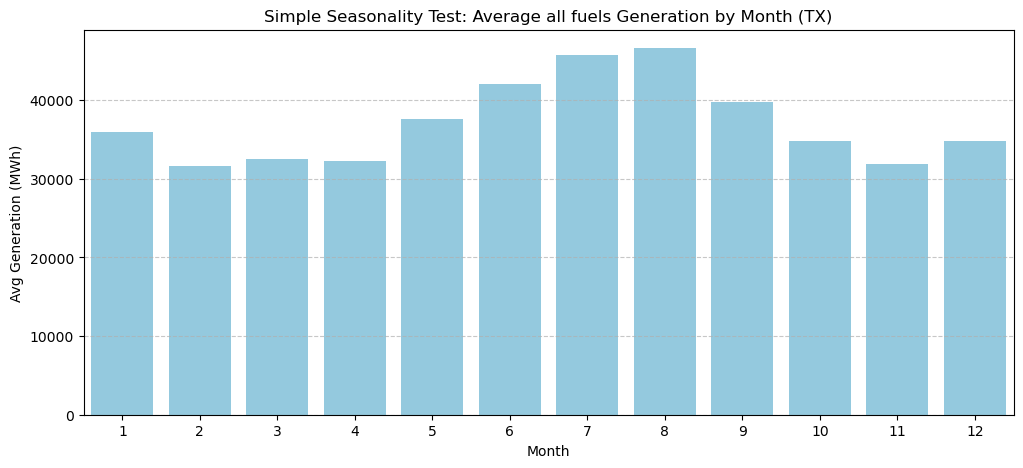

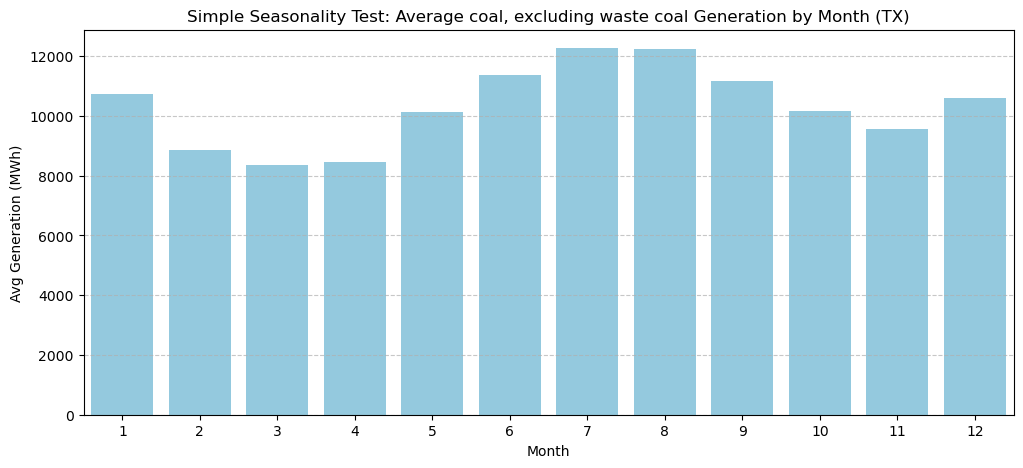

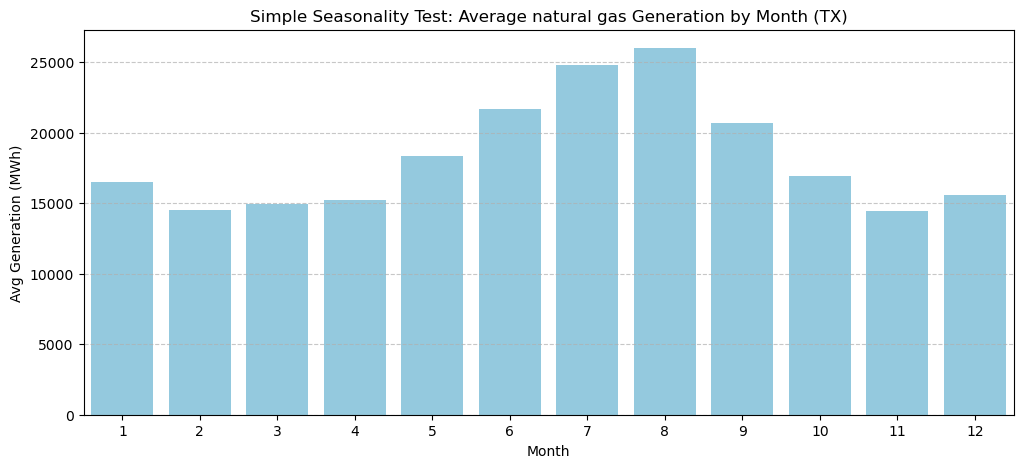

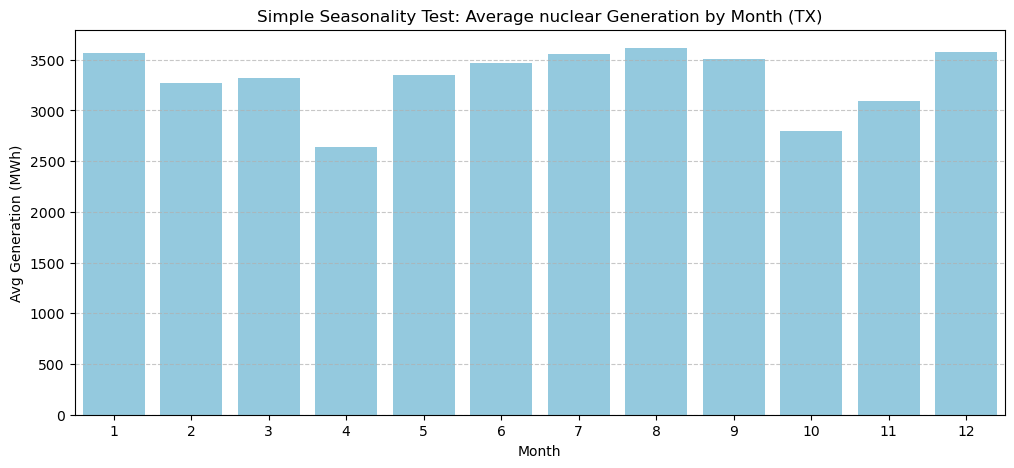

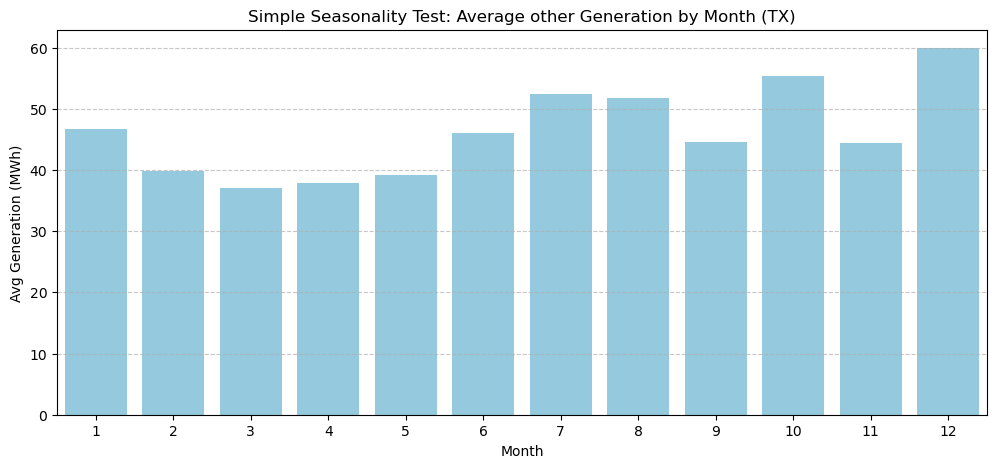

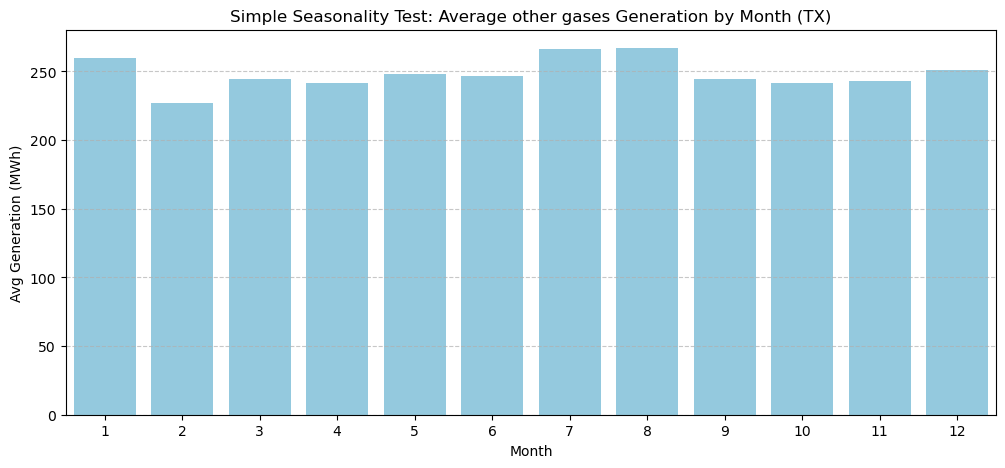

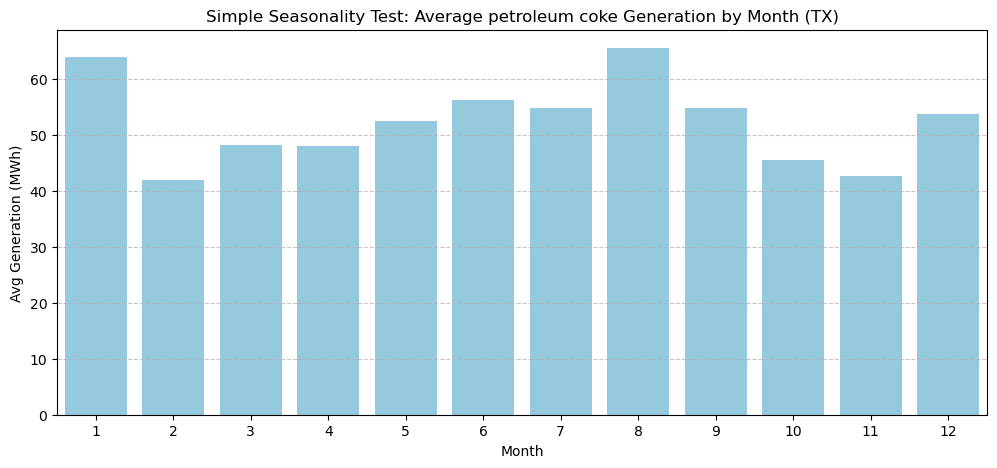

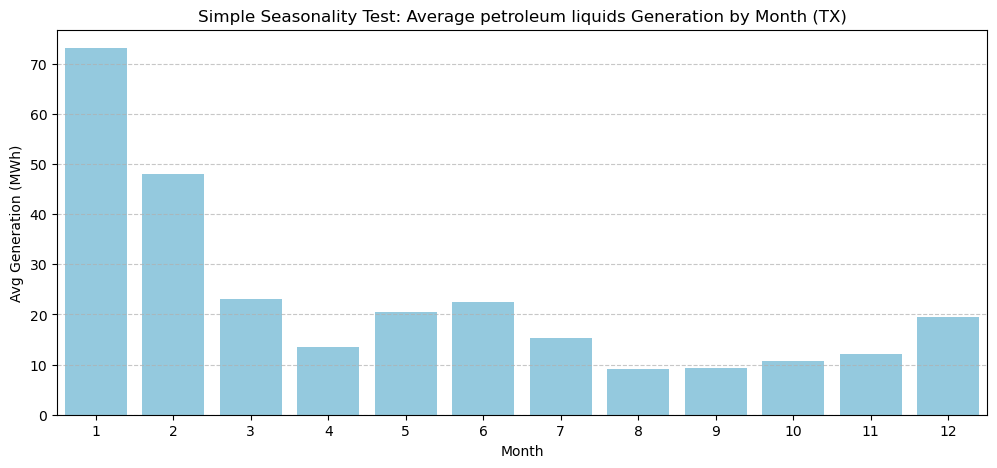

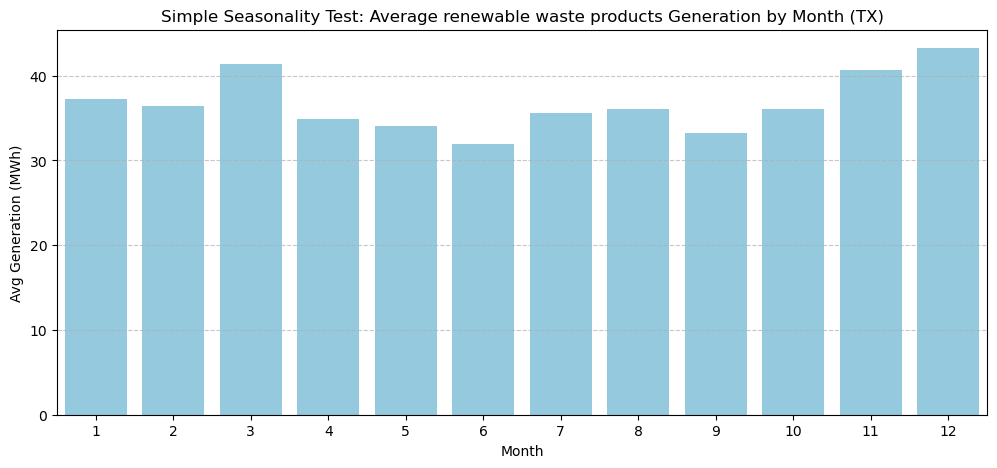

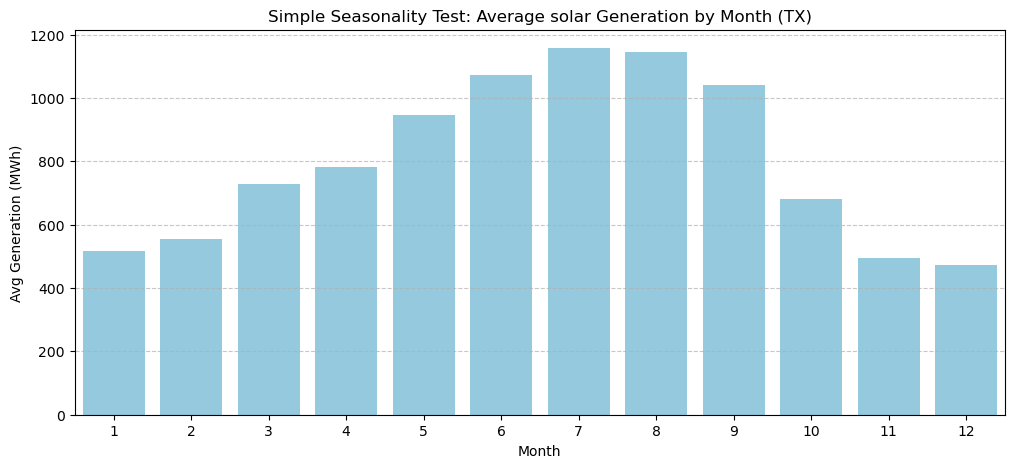

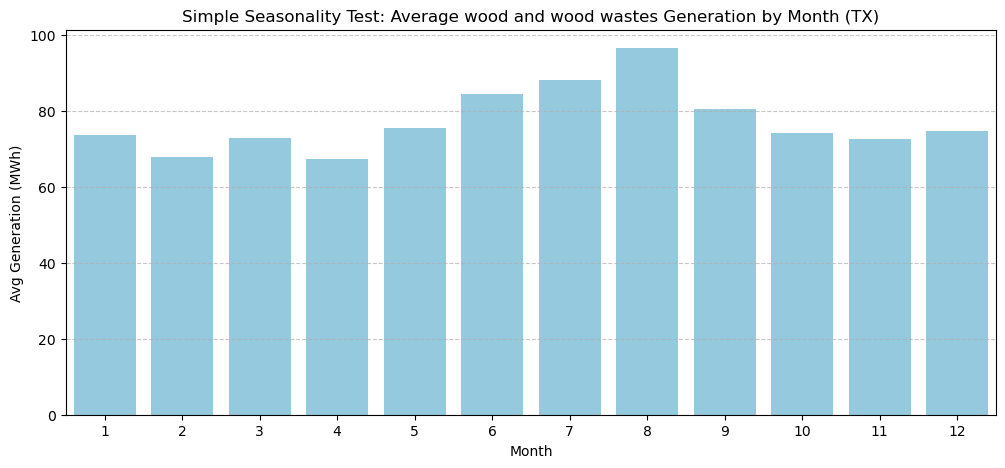

In [26]:
for key in fueltype_dfs.keys():
    seasonality_plot(fueltype_dfs, key)

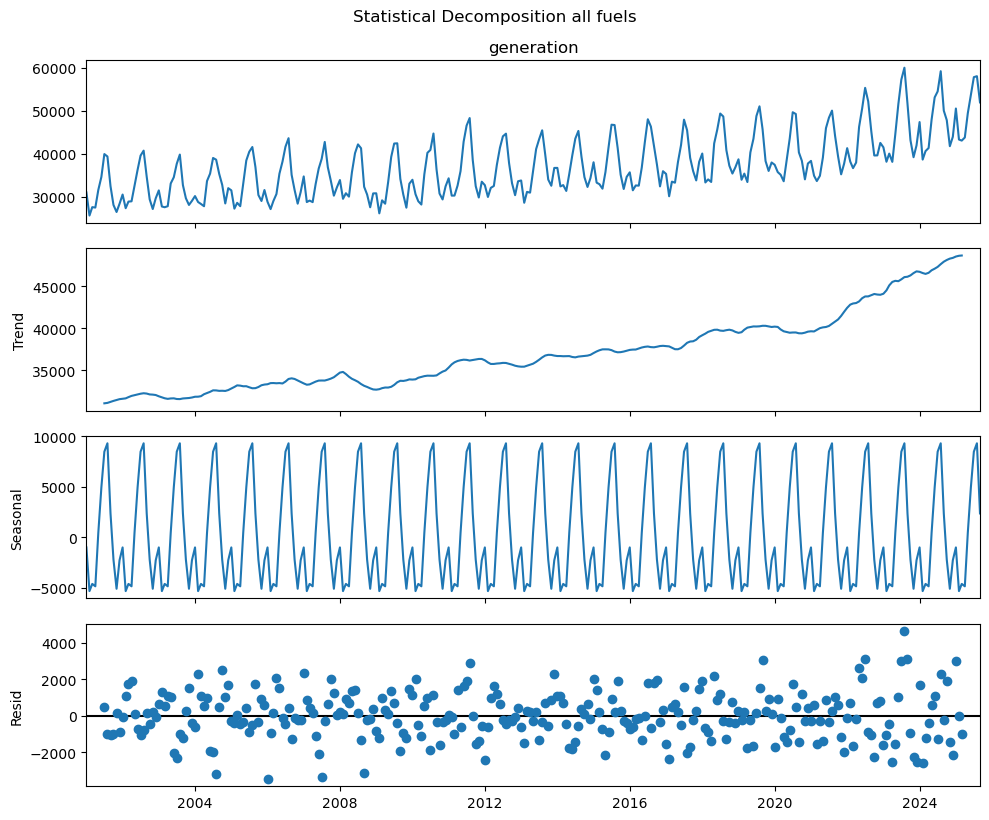

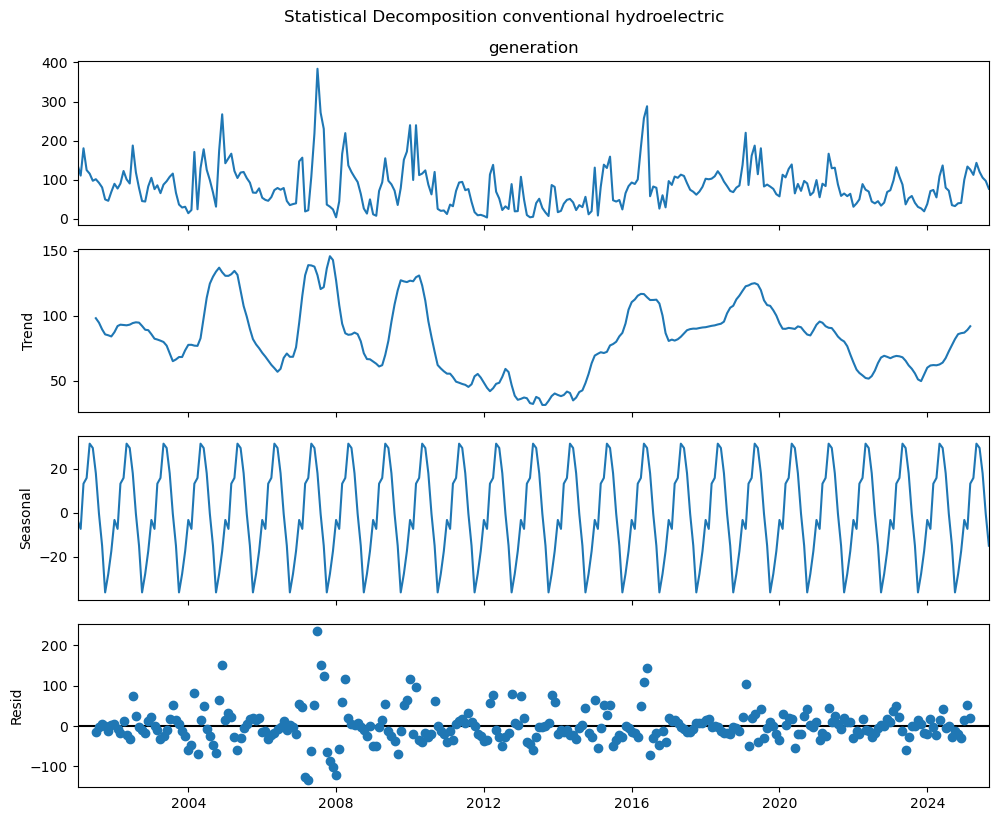

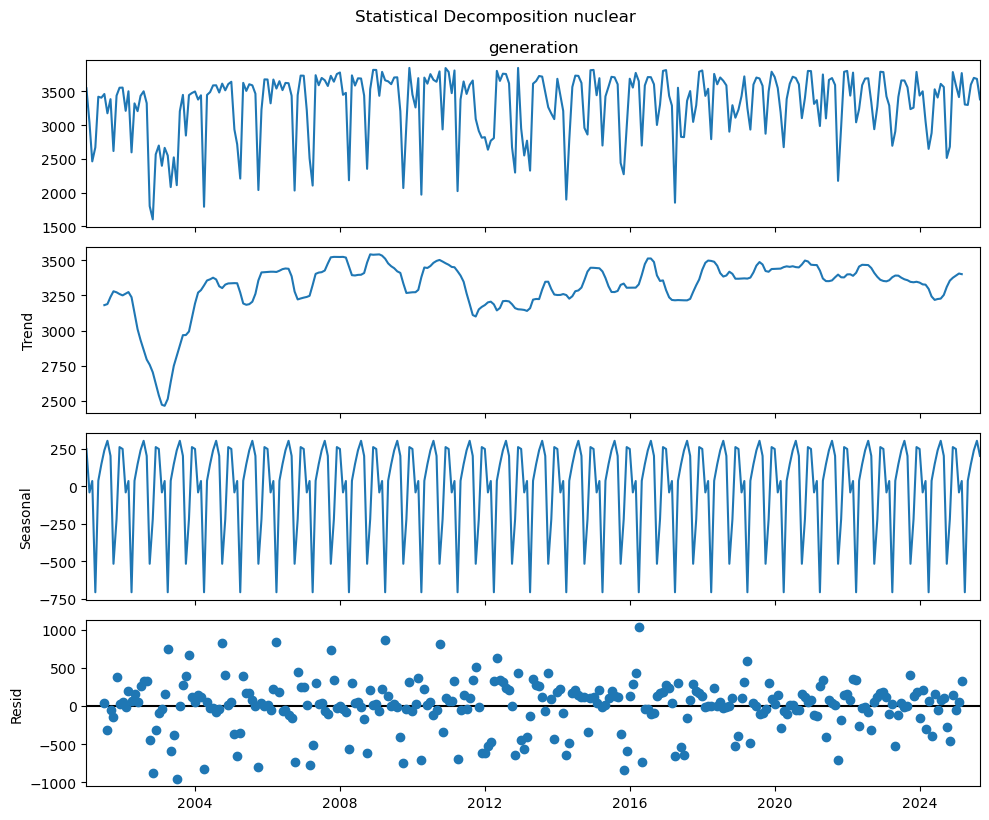

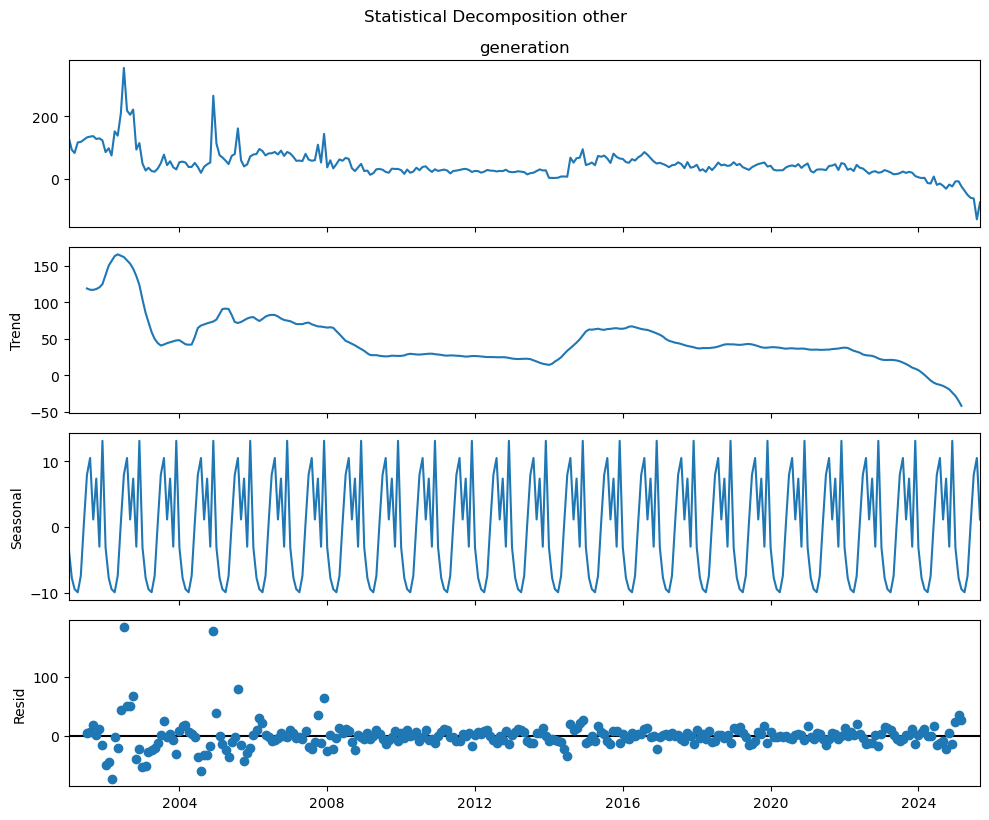

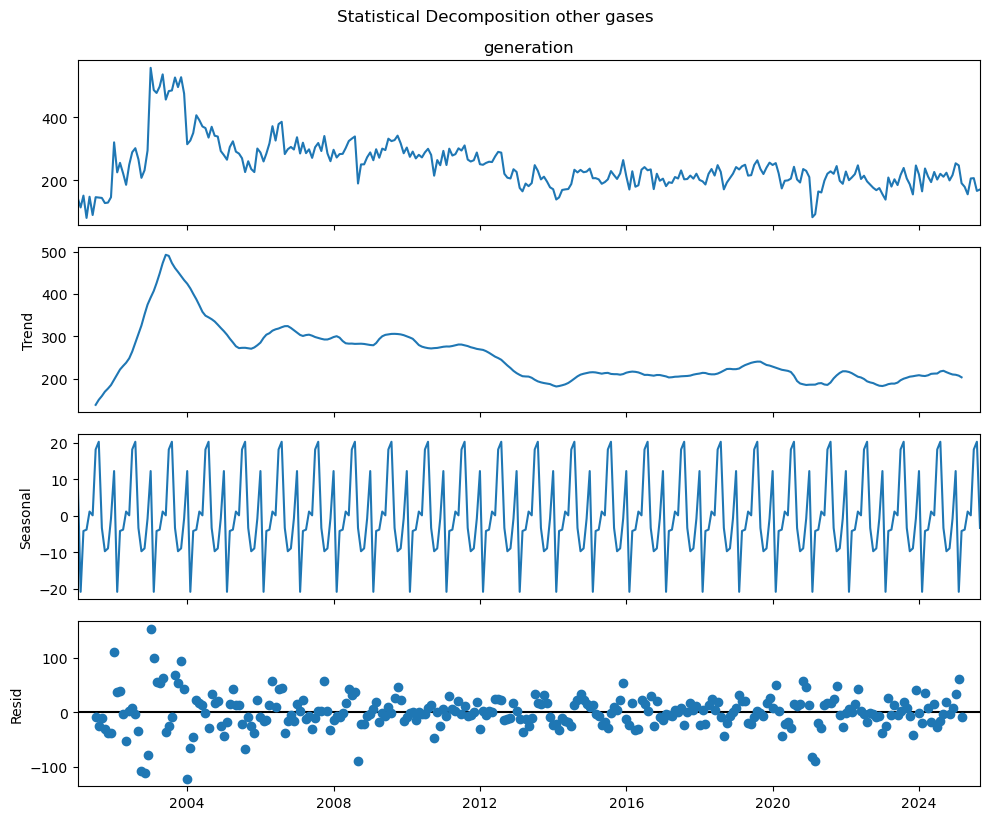

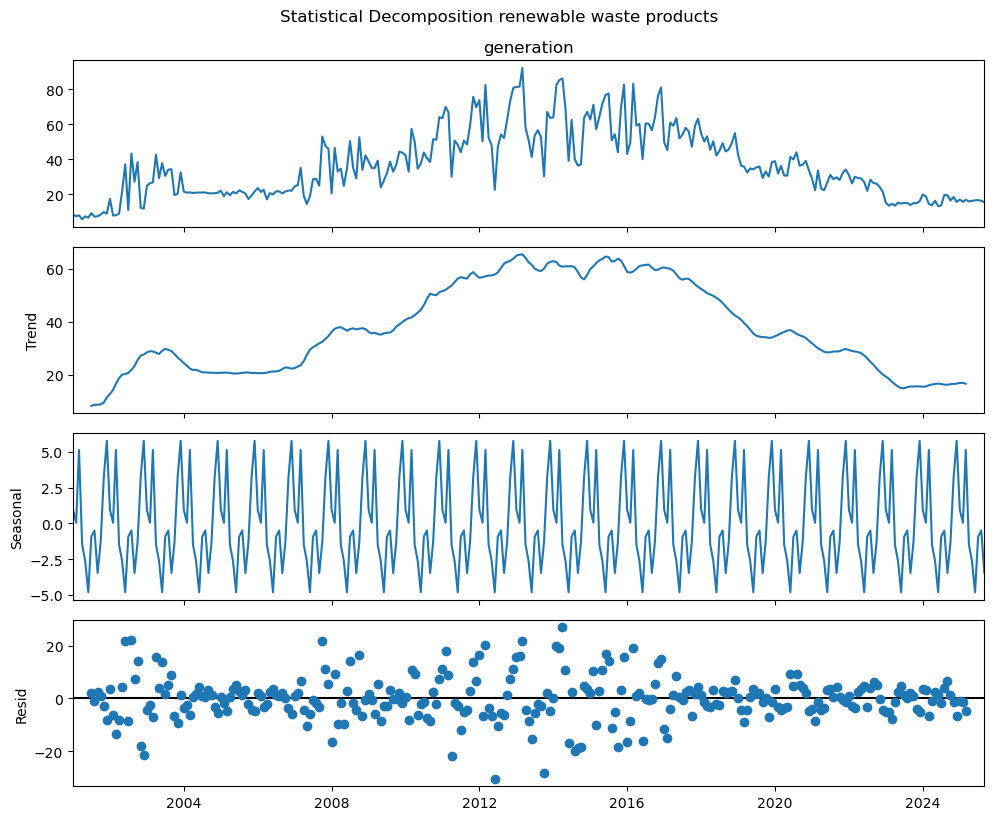

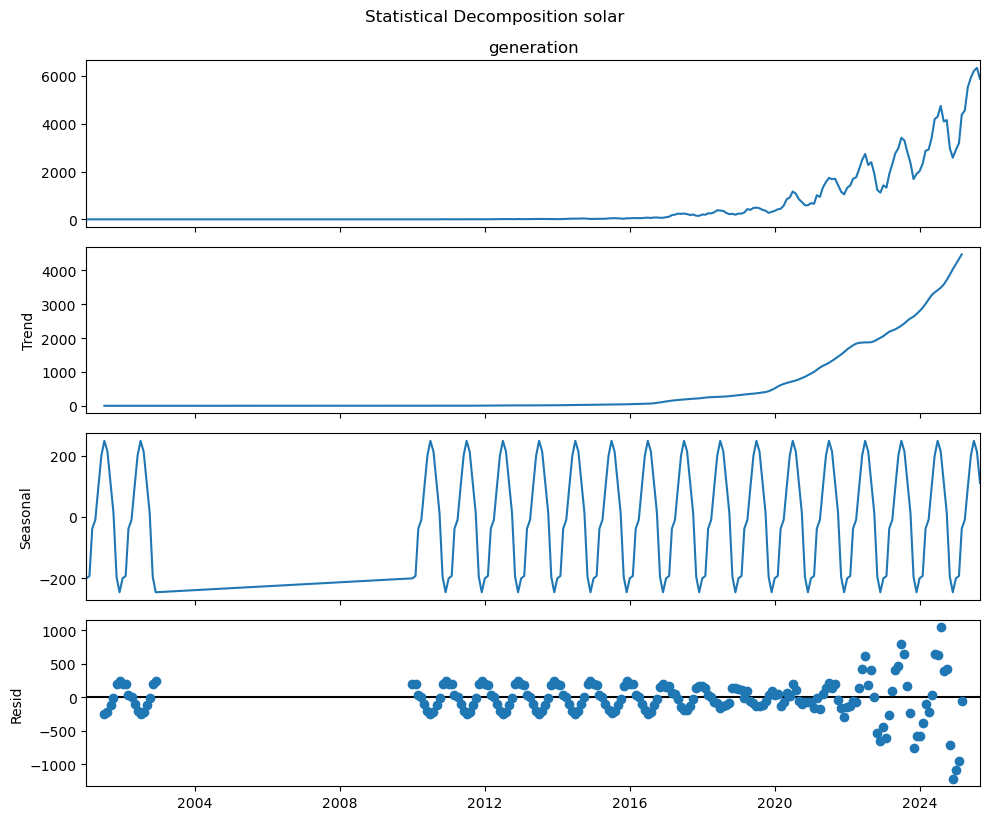

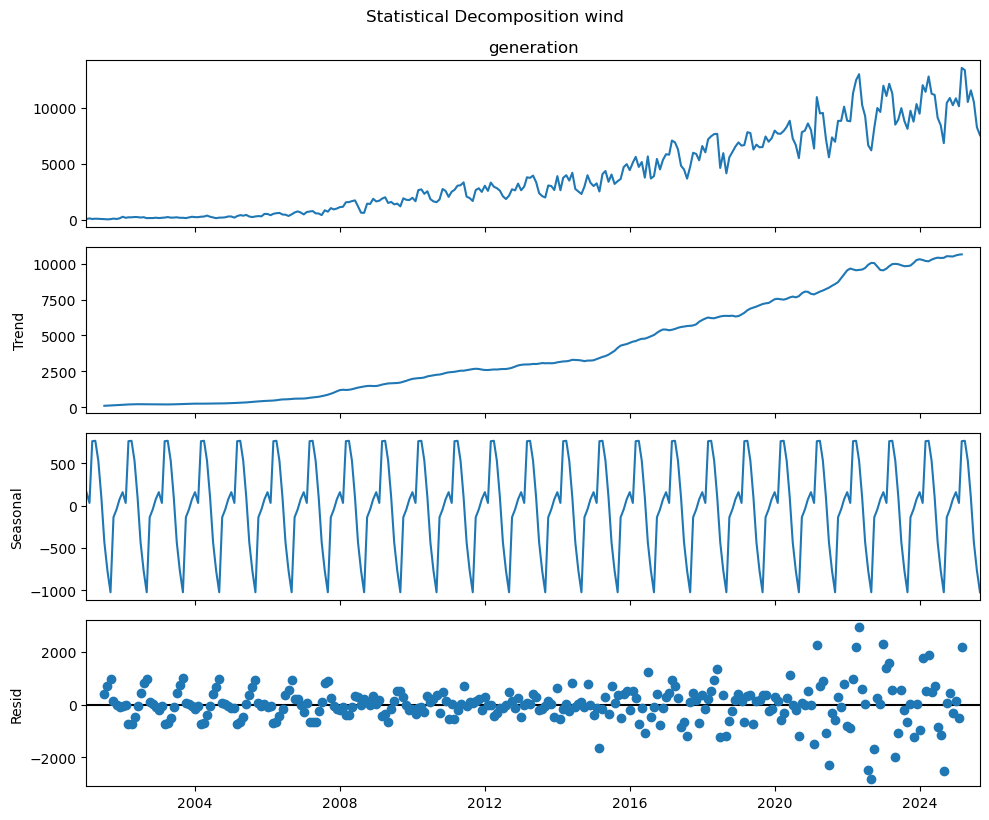

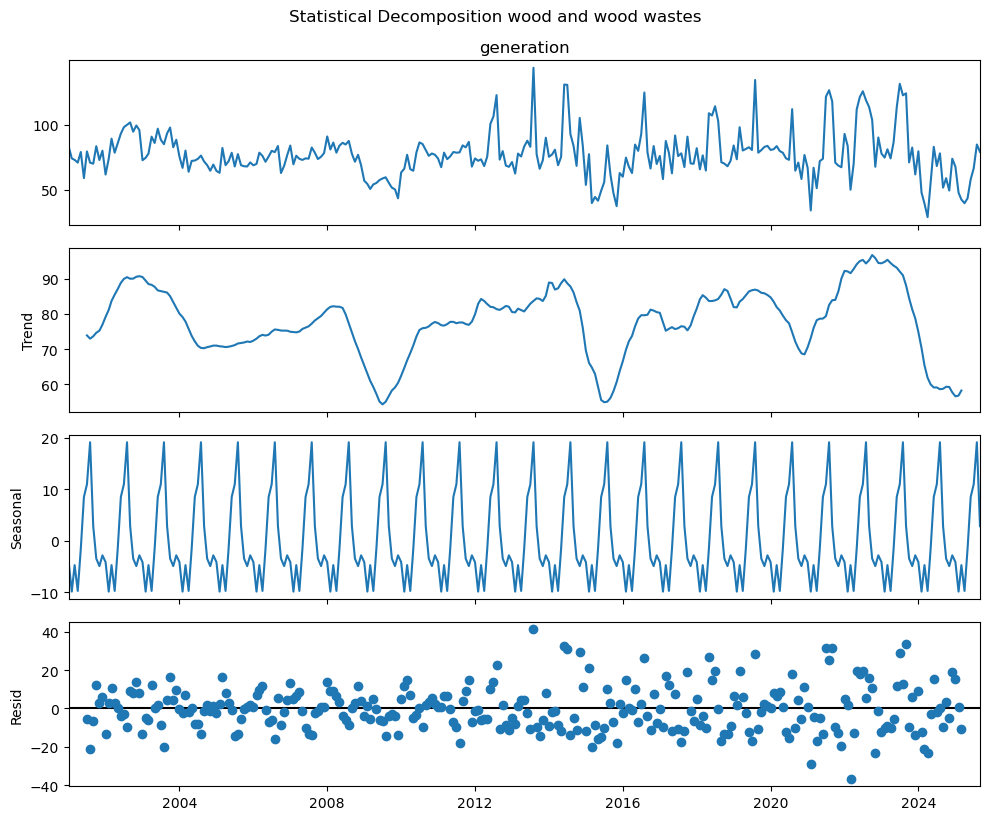

In [27]:
def decompose(df, key):
    final_df = df[key]
    result = seasonal_decompose(final_df['generation'], model='additive', period=12)

    plt.rcParams.update({'figure.figsize': (10, 8)})
    result.plot()
    plt.suptitle(f"Statistical Decomposition {key}", y=1.02) # Move title up
    plt.show()
for key in fueltype_dfs.keys():
    fueltype_dfs[key].sort_index(inplace=True)
    decompose(fueltype_dfs, key)

In [28]:
def decompose_and_forecast_all_fuels(y, horizon=60, period=12):
    y = y.copy()
    y.index = pd.to_datetime(y.index)
    y = y.asfreq('MS')


    result = seasonal_decompose(y, model='additive', period=period)
    trend = result.trend
    seasonal = result.seasonal

    trend_valid = trend.dropna()
    t = np.arange(len(trend_valid)).reshape(-1, 1)
    model = LinearRegression().fit(t, trend_valid.values)

    t_future = np.arange(len(trend_valid),
                         len(trend_valid) + horizon).reshape(-1, 1)

    last_date = y.index[-1]
    future_index = pd.date_range(
        start=last_date + pd.DateOffset(months=1),
        periods=horizon,
        freq='MS'
    )

    trend_future = pd.Series(model.predict(t_future), index=future_index)

    seasonal_cycle = seasonal.dropna().iloc[-period:]
    seas_future_vals = np.resize(seasonal_cycle.values, horizon)
    seasonal_future = pd.Series(seas_future_vals, index=future_index)

    forecast = trend_future + seasonal_future

    plt.figure(figsize=(12, 6))
    plt.plot(y.index, y, label='Observed')
    plt.plot(trend.index, trend, label='Trend (in-sample)')
    plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
    plt.title('All fuels: decomposition-based forecast')
    plt.ylabel('Generation')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return result, forecast

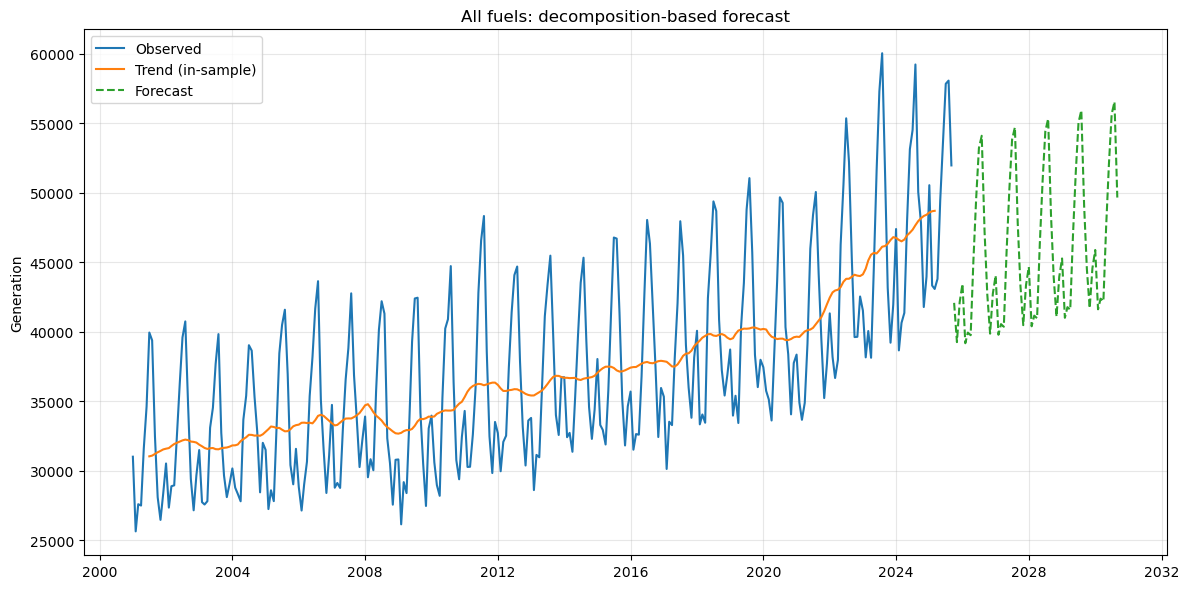

In [29]:
all_fuels_df = fueltype_dfs['all fuels']['generation']
result, forecast = decompose_and_forecast_all_fuels(all_fuels_df)

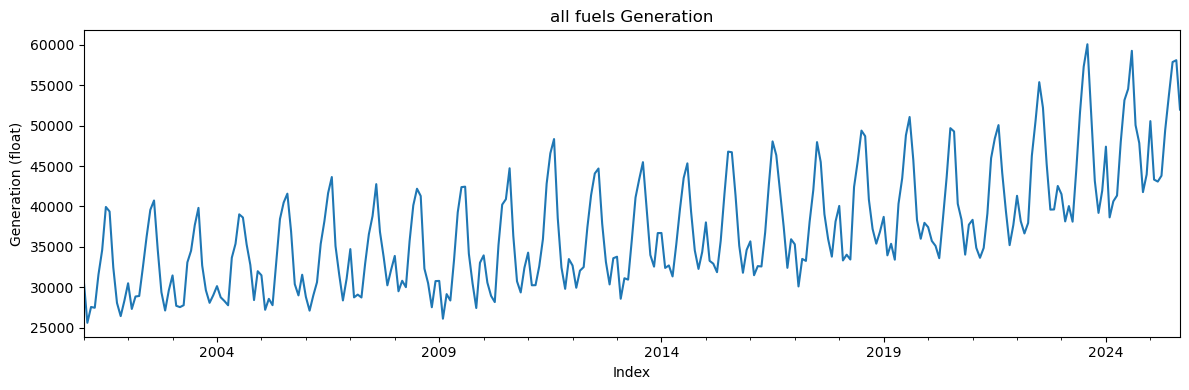

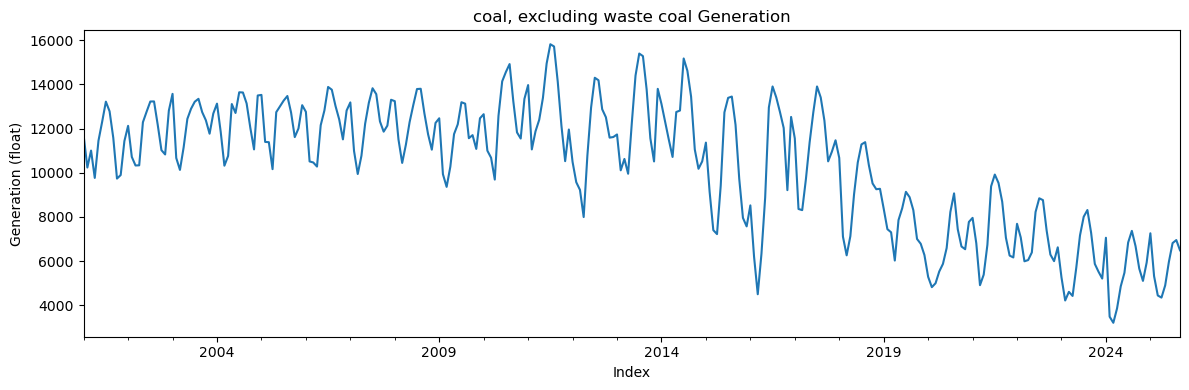

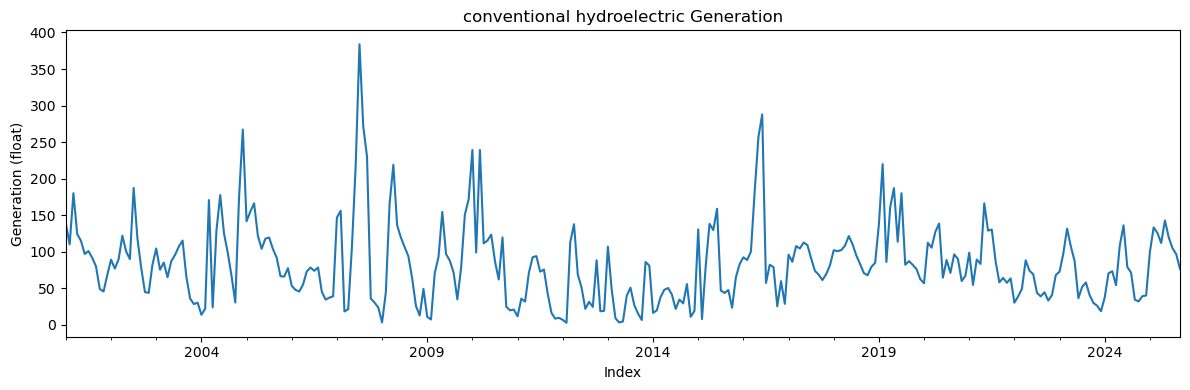

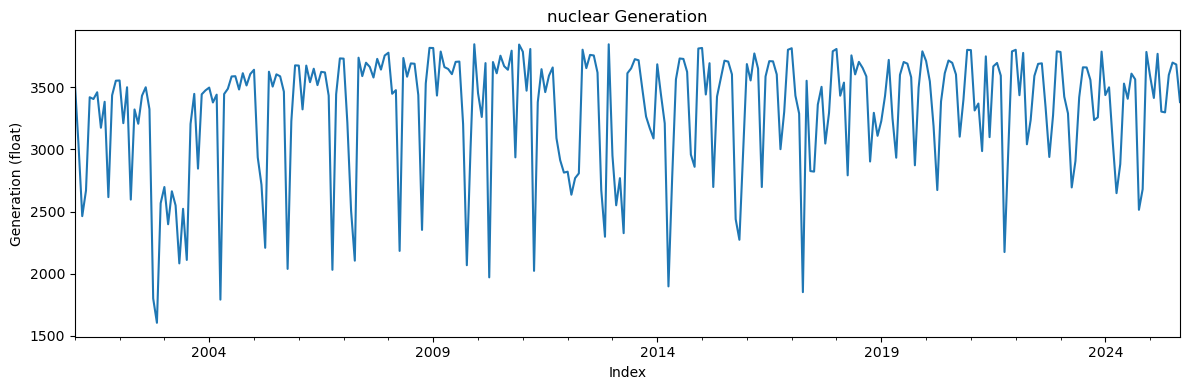

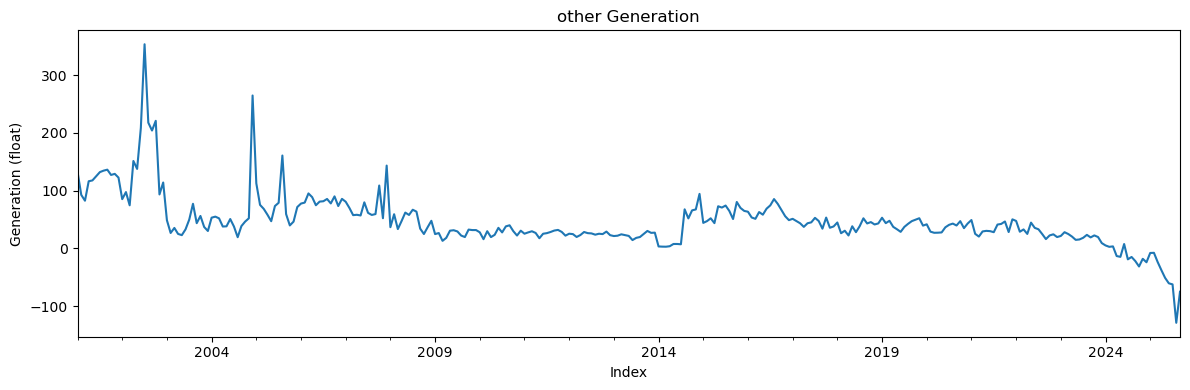

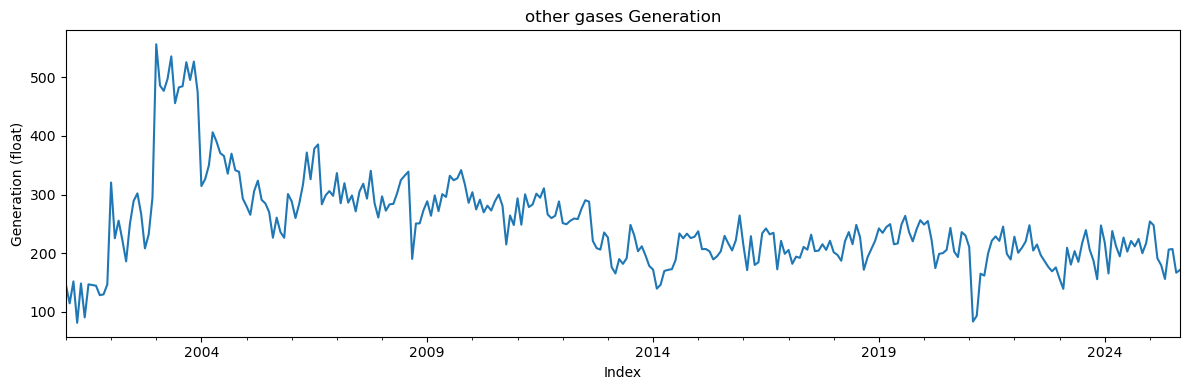

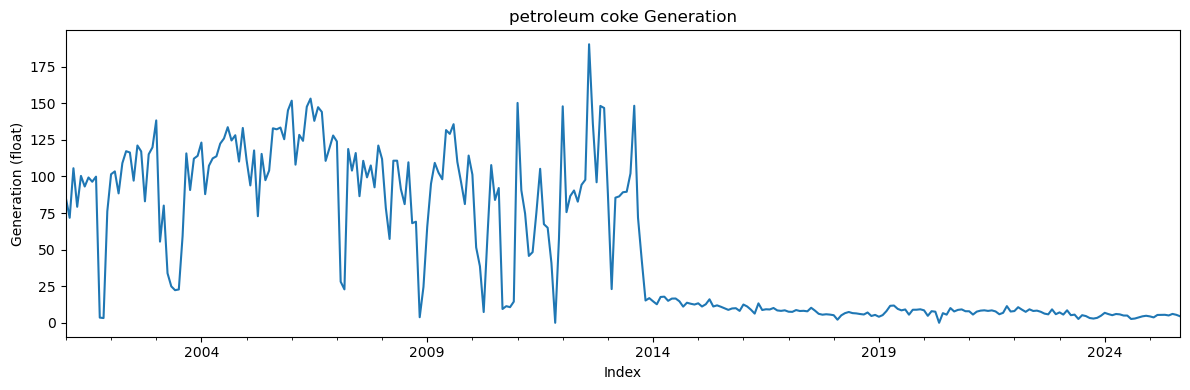

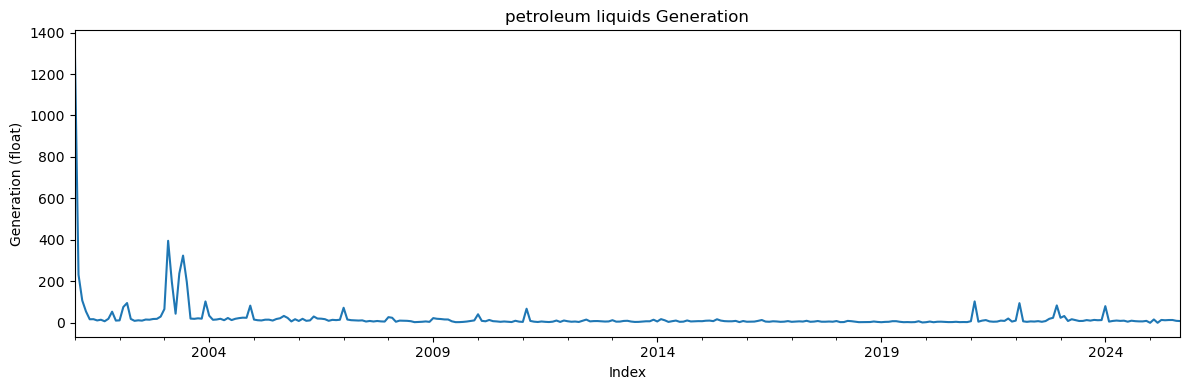

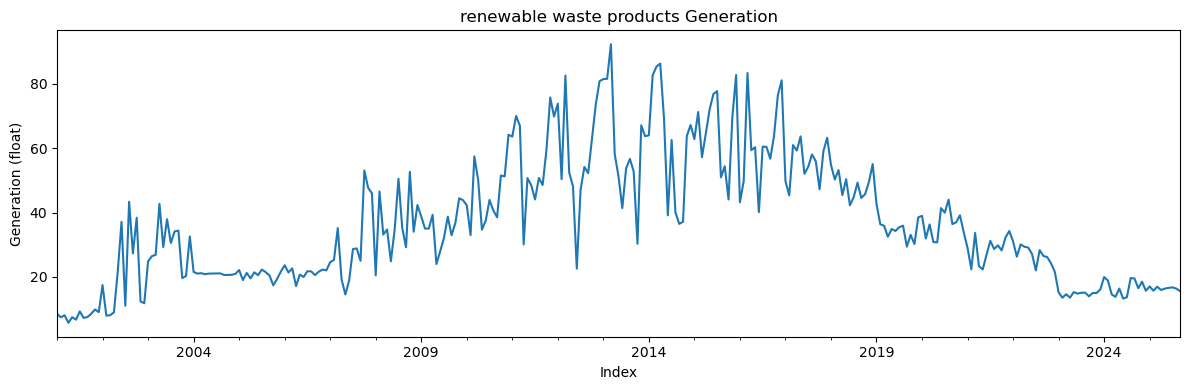

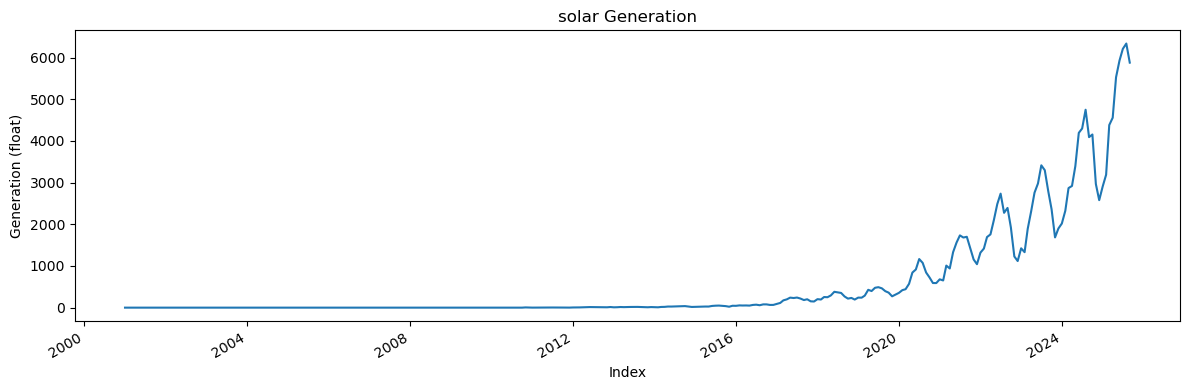

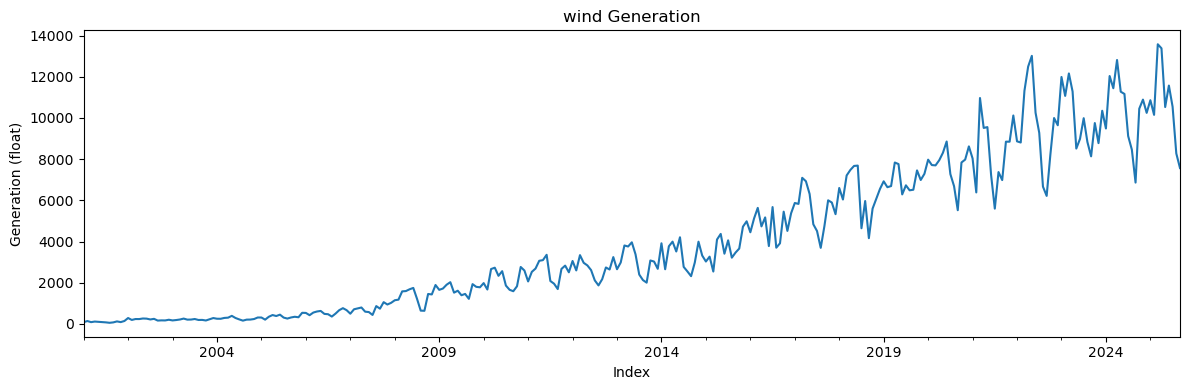

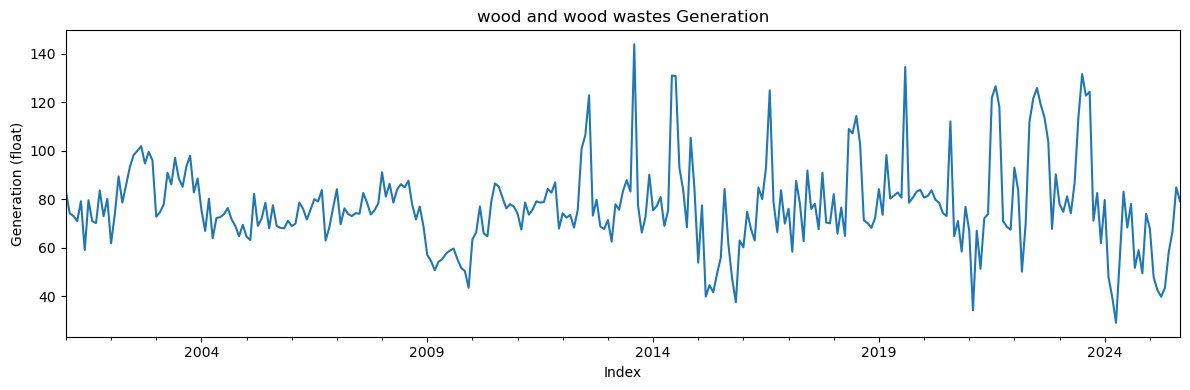

In [30]:
for key in fueltype_dfs.keys():
    gen_series = fueltype_dfs[key]['generation'].astype(float)
    gen_series.plot(figsize=(12, 4), title=f"{key} Generation")
    plt.xlabel("Index")
    plt.ylabel("Generation (float)")
    plt.tight_layout()
    plt.show()

In [31]:
fig = px.line(x=fueltype_dfs['wind'].index, y=fueltype_dfs['wind']['generation'], title="Wind")

# Update layout to match your labels and size
# Note: Plotly uses pixels for size (12x4 inches is roughly 1200x400 pixels)
fig.update_layout(
    xaxis_title="Index",
    yaxis_title="Generation",
    width=1200,
    height=400
)

fig.show()


In [32]:
import plotly.express as px
# Create the line plot
fig = px.line(x=gen_series.index, y=gen_series, title="Solar Generation")

# Update layout to match your labels and size
# Note: Plotly uses pixels for size (12x4 inches is roughly 1200x400 pixels)
fig.update_layout(
    xaxis_title="Index",
    yaxis_title="Generation (float)",
    width=1200,
    height=400
)

fig.show()


In [33]:
df_train = df[df.index <= '2022-12-31']
df_test = df[df.index > '2022-12-31']
fueltype_grouped_train = df_train.groupby("fuelTypeDescription")
fueltype_dfs_train = {name: group.copy() for name, group in fueltype_grouped_train}

fueltype_grouped_test = df_test.groupby("fuelTypeDescription")
fueltype_dfs_test = {name: group.copy() for name, group in fueltype_grouped_test}

for key in fueltype_dfs_train.keys():
    fueltype_dfs_train[key].sort_index(inplace=True, ascending=True)


### Below is training on entire dataset, and we do predictions until 2030 using EWMA. 


all fuels                           | True       | Holt-Winters (Add)
coal, excluding waste coal          | True       | Holt-Winters (Add)
conventional hydroelectric          | False      | Holt's Trend
natural gas                         | True       | Holt-Winters (Add)
nuclear                             | True       | Holt-Winters (Add)
other                               | False      | Holt's Trend
other gases                         | False      | Holt's Trend
petroleum coke                      | False      | Holt's Trend
petroleum liquids                   | False      | Holt's Trend
renewable waste products            | False      | Holt's Trend
solar                               | True       | Holt-Winters (Add)
wind                                | True       | Holt-Winters (Add)
wood and wood wastes                | True       | Holt-Winters (Add)


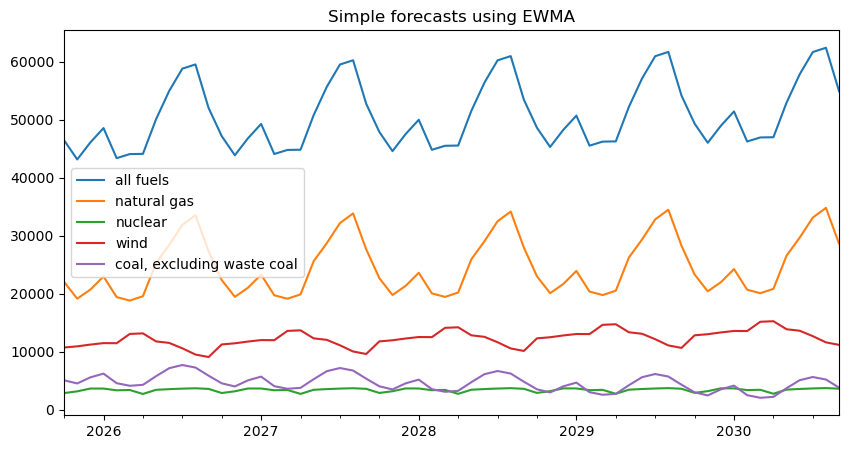

In [34]:
def check_seasonality_strength(series, m=12, threshold=0.2):
    series = series.dropna()
    if len(series) < 2*m:
        return False
    dec = seasonal_decompose(series, model='additive', period=m)
    resid = dec.resid.dropna()
    seasonal = dec.seasonal.dropna()

    var_resid = resid.var()
    var_seasonal_resid = (seasonal + resid).var()
    if var_seasonal_resid == 0:
        return False

    strength = max(0, 1 - (var_resid / var_seasonal_resid))
    return strength > threshold


forecast_horizon = 60
predictions_simple = pd.DataFrame()

for key in fueltype_dfs.keys():
    series = fueltype_dfs[key]['generation']
    
    # Skip if too small
    if len(series) < 36:
        print(f"{key:<35} | Skipped (Not enough data)")
        continue

    is_seasonal = check_seasonality_strength(series)

    if (is_seasonal): 
        model = ExponentialSmoothing(
                series, 
                trend='add', 
                seasonal='add', 
                seasonal_periods=12
            ).fit(optimized=True)
        model_name = "Holt-Winters (Add)"
    else:
        model = ExponentialSmoothing(
                series, 
                trend='add', 
                seasonal=None
            ).fit(optimized=True)
        model_name = "Holt's Trend"

    forecast = model.forecast(forecast_horizon)
        
    predictions_simple[key] = forecast
        
    print(f"{key:<35} | {str(is_seasonal):<10} | {model_name}")

# Plotting a few examples
predictions_simple[['all fuels', 'natural gas', 'nuclear', 'wind', 'coal, excluding waste coal']].plot(title="Simple forecasts using EWMA", figsize=(10, 5))
plt.show()

In [35]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

cols = ['all fuels', 'natural gas', 'nuclear', 'wind',
        'coal, excluding waste coal']

# one subplot per fuel, shared x-axis
fig = make_subplots(rows=len(cols), cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.03,
                    subplot_titles=cols)

for i, col in enumerate(cols, start=1):
    # actuals
    actual = fueltype_dfs[col]['generation'].sort_index()
    fig.add_trace(
        go.Scatter(
            x=actual.index,
            y=actual.values,
            name=f"{col} – actual",
            mode="lines"
        ),
        row=i, col=1
    )

    # predictions
    pred = predictions_simple[col].sort_index()
    fig.add_trace(
        go.Scatter(
            x=pred.index,
            y=pred.values,
            name=f"{col} – EWMA forecast",
            mode="lines",
            line=dict(dash="dash")
        ),
        row=i, col=1
    )

fig.update_layout(
    height=250*len(cols),
    width=900,
    title_text="Actual vs EWMA forecasts",
    showlegend=True
)

fig.show()

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

results = []                 
predictions_on_test = pd.DataFrame()

print(f"{'Fuel Type':<35} | {'Seasonal?':<9} | {'Chosen Model':<20} | {'RMSE(test)'}")
print("-" * 90)

for key, df_train in fueltype_dfs_train.items():
    # train series
    y_train = df_train['generation'].astype(float).dropna()

    # matching test series
    if key not in fueltype_dfs_test:
        continue
    y_test = fueltype_dfs_test[key]['generation'].astype(float).dropna()

    # need some minimum data
    if len(y_train) < 24 or len(y_test) == 0:
        continue

    horizon = len(y_test)

    # detect seasonality on TRAIN only
    seasonal_flag = check_seasonality_strength(y_train, m=12, threshold=0.2)

    # candidate models
    candidates = []
    if seasonal_flag and len(y_train) >= 24:
        candidates.append(
            ("HW_add_seasonal",
             dict(trend='add', seasonal='add', seasonal_periods=12))
        )
    candidates.append(
        ("HW_add_no_seasonal",
         dict(trend='add', seasonal=None))
    )

    best_name, best_model, best_rmse = None, None, np.inf

    for name, hw_kwargs in candidates:
        try:
            model = ExponentialSmoothing(y_train, **hw_kwargs).fit(optimized=True)
            fc = model.forecast(horizon)
            # align indices if needed
            fc = pd.Series(fc, index=y_test.index)
            rmse = np.sqrt(((fc - y_test) ** 2).mean())

            if rmse < best_rmse:
                best_rmse = rmse
                best_name = name
                best_model = model
        except Exception as e:
            # skip broken spec
            continue

    if best_model is None:
        continue

    # store predictions on test (for inspection)
    fc_test = best_model.forecast(horizon)
    predictions_on_test[key] = pd.Series(fc_test, index=y_test.index)

    results.append({
        "fuelTypeDescription": key,
        "seasonal_flag": seasonal_flag,
        "chosen_model": best_name,
        "rmse_test": best_rmse
    })

    print(f"{key:<35} | {str(seasonal_flag):<9} | {best_name:<20} | {best_rmse:10.3f}")

results_df = pd.DataFrame(results)

Fuel Type                           | Seasonal? | Chosen Model         | RMSE(test)
------------------------------------------------------------------------------------------
all fuels                           | True      | HW_add_seasonal      |   2935.823
coal, excluding waste coal          | True      | HW_add_seasonal      |   1075.717
conventional hydroelectric          | False     | HW_add_no_seasonal   |     43.412
natural gas                         | True      | HW_add_seasonal      |   2089.776
nuclear                             | True      | HW_add_seasonal      |    279.668
other                               | False     | HW_add_no_seasonal   |     40.336
other gases                         | False     | HW_add_no_seasonal   |     37.392
petroleum coke                      | False     | HW_add_no_seasonal   |      4.470
petroleum liquids                   | False     | HW_add_no_seasonal   |     45.429
renewable waste products            | False     | HW_add_no_seasonal 

In [37]:
true_values = pd.DataFrame()

for key in fueltype_dfs_test.keys():
    true_values[key] = fueltype_dfs_test[key]['generation']

In [38]:
true_values

all fuels  coal, excluding waste coal  \
period                                                
2025-09-01  51969.47648                  6490.75707   
2025-08-01  58074.24094                  6954.19688   
2025-07-01  57847.47218                  6817.80050   
2025-06-01  53731.09517                  5967.57327   
2025-05-01  49442.04178                  4902.17097   
2025-04-01  43799.38542                  4349.51734   
2025-03-01  43076.59418                  4446.81706   
2025-02-01  43322.44213                  5323.70834   
2025-01-01  50546.36669                  7261.02864   
2024-12-01  43959.68828                  5937.95667   
2024-11-01  41776.13839                  5106.47282   
2024-10-01  47836.90074                  5662.68241   
2024-09-01  50046.22844                  6676.84467   
2024-08-01  59234.49316                  7370.07698   
2024-07-01  54522.64785                  6843.01405   
2024-06-01  53138.31293                  5475.36837   
2024-05-01  47953.42710                  4858.84887   
2024-04-01  41351.85656                  3858.79629   
2024-03-01  40637.24312                  3209.90662   
2024-02-01  38654.38932                  3486.61319   
2024-01-01  47391.36179                  7058.66268   
2023-12-01  41954.46264                  5211.78141   
2023-11-01  39207.96224                  5522.16136   
2023-10-01  43164.13639                  5875.17104   
2023-09-01  51641.22369                  7286.14335   
2023-08-01  60044.48073                  8314.17635   
2023-07-01  57282.22839                  8009.72619   
2023-06-01  51610.82744                  7166.03640   
2023-05-01  44543.51493                  5708.88169   
2023-04-01  38123.93956                  4425.15726   
2023-03-01  40048.54061                  4610.07016   
2023-02-01  38152.56198                  4219.94478   
2023-01-01  41520.66627                  5265.53983   

            conventional hydroelectric  natural gas   nuclear      other  \
period                                                                     
2025-09-01                    76.39725  28369.28312  3380.834  -75.17441   
2025-08-01                    96.62501  32570.81021  3683.574 -129.00794   
2025-07-01                   104.94906  30221.26513  3699.006  -62.47163   
2025-06-01                   119.77276  26301.55780  3599.212  -60.62348   
2025-05-01                   142.82981  24856.76131  3298.128  -51.20720   
2025-04-01                   112.01494  17877.10162  3304.449  -37.79304   
2025-03-01                   125.66469  16527.77259  3769.469  -23.72666   
2025-02-01                   133.35558  20785.16643  3414.387   -7.80140   
2025-01-01                    99.58754  25459.39049  3589.154   -8.09869   
2024-12-01                    40.11300  21072.13623  3784.635  -24.16858   
2024-11-01                    39.25900  19830.07350  2679.977  -18.17788   
2024-10-01                    32.06000  24744.29110  2513.878  -31.49050   
2024-09-01                    34.45500  28544.43793  3563.938  -22.10456   
2024-08-01                    71.40900  34654.36508  3609.936  -15.01337   
2024-07-01                    79.13100  30492.88285  3407.514  -19.09159   
2024-06-01                   136.16500  28290.90177  3529.657    7.40601   
2024-05-01                   108.47500  25164.70318  2882.143  -14.79605   
2024-04-01                    54.32500  18796.69146  2647.937  -13.42682   
2024-03-01                    73.39800  19675.05375  3056.362    3.30623   
2024-02-01                    70.50600  16988.91933  3499.822    2.55875   
2024-01-01                    37.44600  24939.01303  3437.319    4.97536   
2023-12-01                    18.66900  20335.59057  3787.142    9.01057   
2023-11-01                    26.07400  19647.83780  3258.429   19.50093   
2023-10-01                    29.99700  21595.97500  3236.295   22.35015   
2023-09-01                    40.50700  29445.05586  3559.445   18.88778   
2023-08-01                    57.990

In [39]:
predictions_on_test

all fuels  coal, excluding waste coal  \
period                                                 
2025-09-01  48073.376696                 6003.558842   
2025-08-01  54818.351896                 7388.700027   
2025-07-01  55095.454811                 7920.645922   
2025-06-01  51119.024921                 7530.893159   
2025-05-01  46529.498890                 6041.595340   
2025-04-01  40739.940102                 4454.052014   
2025-03-01  40684.344181                 4169.420111   
2025-02-01  40358.651628                 4814.878943   
2025-01-01  44330.802087                 6252.996684   
2024-12-01  43027.783122                 5743.567598   
2024-11-01  40251.133389                 4611.926457   
2024-10-01  42832.878258                 5163.859241   
2024-09-01  47476.972035                 6472.020420   
2024-08-01  54221.947235                 7857.161605   
2024-07-01  54499.050150                 8389.107500   
2024-06-01  50522.620260                 7999.354737   
2024-05-01  45933.094229                 6510.056917   
2024-04-01  40143.535442                 4922.513592   
2024-03-01  40087.939520                 4637.881689   
2024-02-01  39762.246967                 5283.340521   
2024-01-01  43734.397427                 6721.458262   
2023-12-01  42431.378461                 6212.029176   
2023-11-01  39654.728728                 5080.388035   
2023-10-01  42236.473597                 5632.320818   
2023-09-01  46880.567375                 6940.481998   
2023-08-01  53625.542575                 8325.623183   
2023-07-01  53902.645490                 8857.569078   
2023-06-01  49926.215600                 8467.816315   
2023-05-01  45336.689569                 6978.518495   
2023-04-01  39547.130781                 5390.975169   
2023-03-01  39491.534860                 5106.343267   
2023-02-01  39165.842307                 5751.802099   
2023-01-01  43137.992766                 7189.919840   

            conventional hydroelectric   natural gas      nuclear      other  \
period                                                                         
2025-09-01                   50.987088  26597.104371  3686.291755   8.491863   
2025-08-01                   51.269454  31807.505224  3787.826881   8.861858   
2025-07-01                   51.551820  31995.483778  3726.217959   9.231854   
2025-06-01                   51.834186  28469.834757  3634.717324   9.601850   
2025-05-01                   52.116551  24622.265984  3572.420795   9.971846   
2025-04-01                   52.398917  20662.542631  2780.914012  10.341841   
2025-03-01                   52.681283  19834.112037  3488.645283  10.711837   
2025-02-01                   52.963649  20687.414301  3419.111882  11.081833   
2025-01-01                   53.246015  22589.741850  3736.344725  11.451829   
2024-12-01                   53.528380  21177.540609  3721.337892  11.821824   
2024-11-01                   53.810746  19686.286035  3270.085720  12.191820   
2024-10-01                   54.093112  22056.857757  2952.620342  12.561816   
2024-09-01                   54.375478  26220.964934  3673.040403  12.931811   
2024-08-01                   54.657843  31431.365788  3774.575529  13.301807   
2024-07-01                   54.940209  31619.344342  3712.966607  13.671803   
2024-06-01                   55.222575  28093.695321  3621.465972  14.041799   
2024-05-01                   55.504941  24246.126548  3559.169443  14.411794   
2024-04-01                   55.787307  20286.403195  2767.662660  14.781790   
2024-03-01                   56.069672  19457.972601  3475.393931  15.151786   
2024-02-01                   56.352038  20311.274864  3405.860530  15.521782   
2024-01-01                   56.634404  22213.602414  3723.093373  15.891777   
2023-12-01                   56.916770  20801.401173  3708.086540  16.261773   
2023-11-01                   57.199135  19310.146599  3256.834368  16.631769   
2023-10-01                   57.481501  21680.718321  

In [40]:
y_true = true_values
y_pred = predictions_on_test

In [41]:
y_true.columns

Index(['all fuels', 'coal, excluding waste coal', 'conventional hydroelectric',
       'natural gas', 'nuclear', 'other', 'other gases', 'petroleum coke',
       'petroleum liquids', 'renewable waste products', 'solar', 'wind',
       'wood and wood wastes'],
      dtype='object')

In [42]:
residuals = y_pred - y_true
residuals

all fuels  coal, excluding waste coal  \
period                                                
2025-09-01 -3896.099784                 -487.198228   
2025-08-01 -3255.889044                  434.503147   
2025-07-01 -2752.017369                 1102.845422   
2025-06-01 -2612.070249                 1563.319889   
2025-05-01 -2912.542890                 1139.424370   
2025-04-01 -3059.445318                  104.534674   
2025-03-01 -2392.249999                 -277.396949   
2025-02-01 -2963.790502                 -508.829397   
2025-01-01 -6215.564603                -1008.031956   
2024-12-01  -931.905158                 -194.389072   
2024-11-01 -1525.005001                 -494.546363   
2024-10-01 -5004.022482                 -498.823169   
2024-09-01 -2569.256405                 -204.824250   
2024-08-01 -5012.545925                  487.084625   
2024-07-01   -23.597700                 1546.093450   
2024-06-01 -2615.692670                 2523.986367   
2024-05-01 -2020.332871                 1651.208047   
2024-04-01 -1208.321118                 1063.717302   
2024-03-01  -549.303600                 1427.975069   
2024-02-01  1107.857647                 1796.727331   
2024-01-01 -3656.964363                 -337.204418   
2023-12-01   476.915821                 1000.247766   
2023-11-01   446.766488                 -441.773325   
2023-10-01  -927.662793                 -242.850222   
2023-09-01 -4760.656315                 -345.661352   
2023-08-01 -6418.938155                   11.446833   
2023-07-01 -3379.582900                  847.842888   
2023-06-01 -1684.611840                 1301.779915   
2023-05-01   793.174639                 1269.636805   
2023-04-01  1423.191221                  965.817909   
2023-03-01  -557.005750                  496.273107   
2023-02-01  1013.280327                 1531.857319   
2023-01-01  1617.326496                 1924.380010   

            conventional hydroelectric  natural gas     nuclear       other  \
period                                                                        
2025-09-01                  -25.410162 -1772.178749  305.457755   83.666273   
2025-08-01                  -45.355556  -763.304986  104.252881  137.869798   
2025-07-01                  -53.397240  1774.218648   27.211959   71.703484   
2025-06-01                  -67.938574  2168.276957   35.505324   70.225330   
2025-05-01                  -90.713259  -234.495326  274.292795   61.179046   
2025-04-01                  -59.616023  2785.441011 -523.534988   48.134881   
2025-03-01                  -72.983407  3306.339447 -280.823717   34.438497   
2025-02-01                  -80.391931   -97.752129    4.724882   18.883233   
2025-01-01                  -46.341525 -2869.648640  147.190725   19.550519   
2024-12-01                   13.415380   105.404379  -63.297108   35.990404   
2024-11-01                   14.551746  -143.787465  590.108720   30.369700   
2024-10-01                   22.033112 -2687.433343  438.742342   44.052316   
2024-09-01                   19.920478 -2323.472996  109.102403   35.036371   
2024-08-01                  -16.751157 -3222.999292  164.639529   28.315177   
2024-07-01                  -24.190791  1126.461492  305.452607   32.763393   
2024-06-01                  -80.942425  -197.206449   91.808972    6.635789   
2024-05-01                  -52.970059  -918.576632  677.026443   29.207844   
2024-04-01                    1.462307  1489.711735  119.725660   28.208610   
2024-03-01                  -17.328328  -217.081149  419.031931   11.845556   
2024-02-01                  -14.153962  3322.355534  -93.961470   12.963032   
2024-01-01                   19.188404 -2725.410616  285.774373   10.916417   
2023-12-01                   38.247770   465.810603  -79.055460    7.251203   
2023-11-01                   31.125135  -337.691201   -1.594632   -2.869161   
2023-10-01                   27.484501    84.743321 -296.926010   -5.348386   
2023-09-01                   17.25

In [43]:
COLS_TO_PLOT = ['all fuels', 'coal, excluding waste coal', 'natural gas', 'nuclear', 'wind'] 

Per-column metrics:
                                    MAE         RMSE         Bias      MAPE_%
all fuels                   2417.684468  2935.823300 -2000.804914    4.881987
coal, excluding waste coal   885.825180  1075.717363   580.277986   17.168737
conventional hydroelectric    35.785200    43.411998   -21.645715   49.892533
natural gas                 1659.206265  2089.775591   -59.577149    7.228595
nuclear                      207.517108   279.668111   119.903582    6.617459
other                         27.189575    40.335641    25.333806  125.489460
other gases                   31.832750    37.392438   -23.944110   15.098674
petroleum coke                 3.634691     4.470215    -3.398187   74.926197
petroleum liquids             39.266188    45.428755   -10.798942  341.238768
renewable waste products       8.895945     9.044444     8.895945   57.522639
solar                               NaN          NaN          NaN         NaN
wind                        1014.962113  127

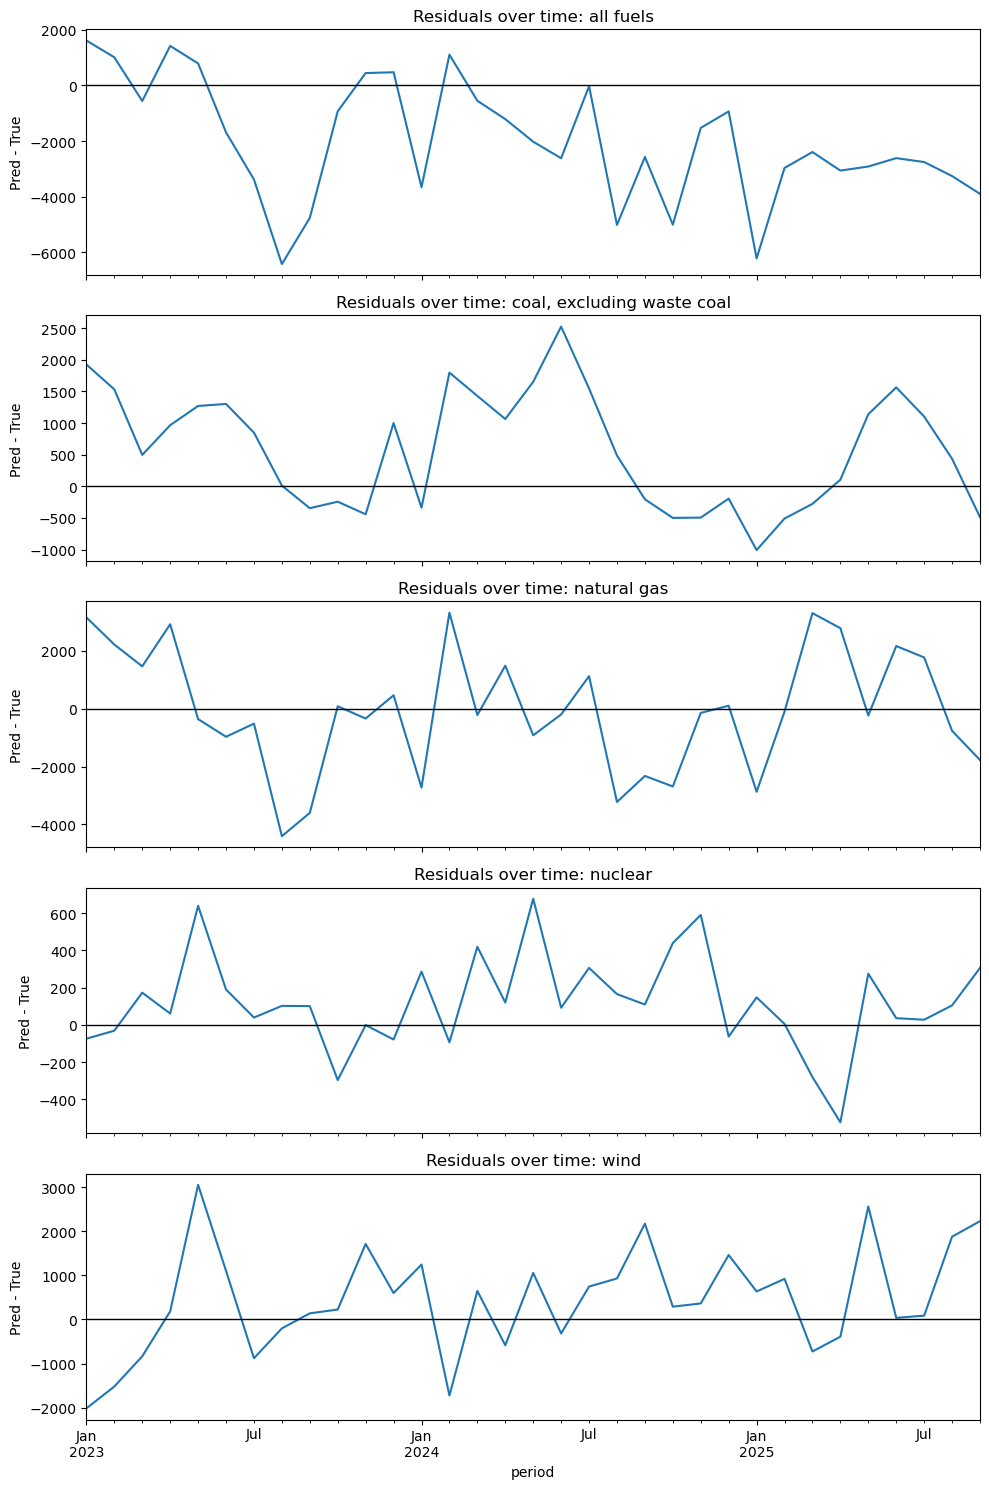

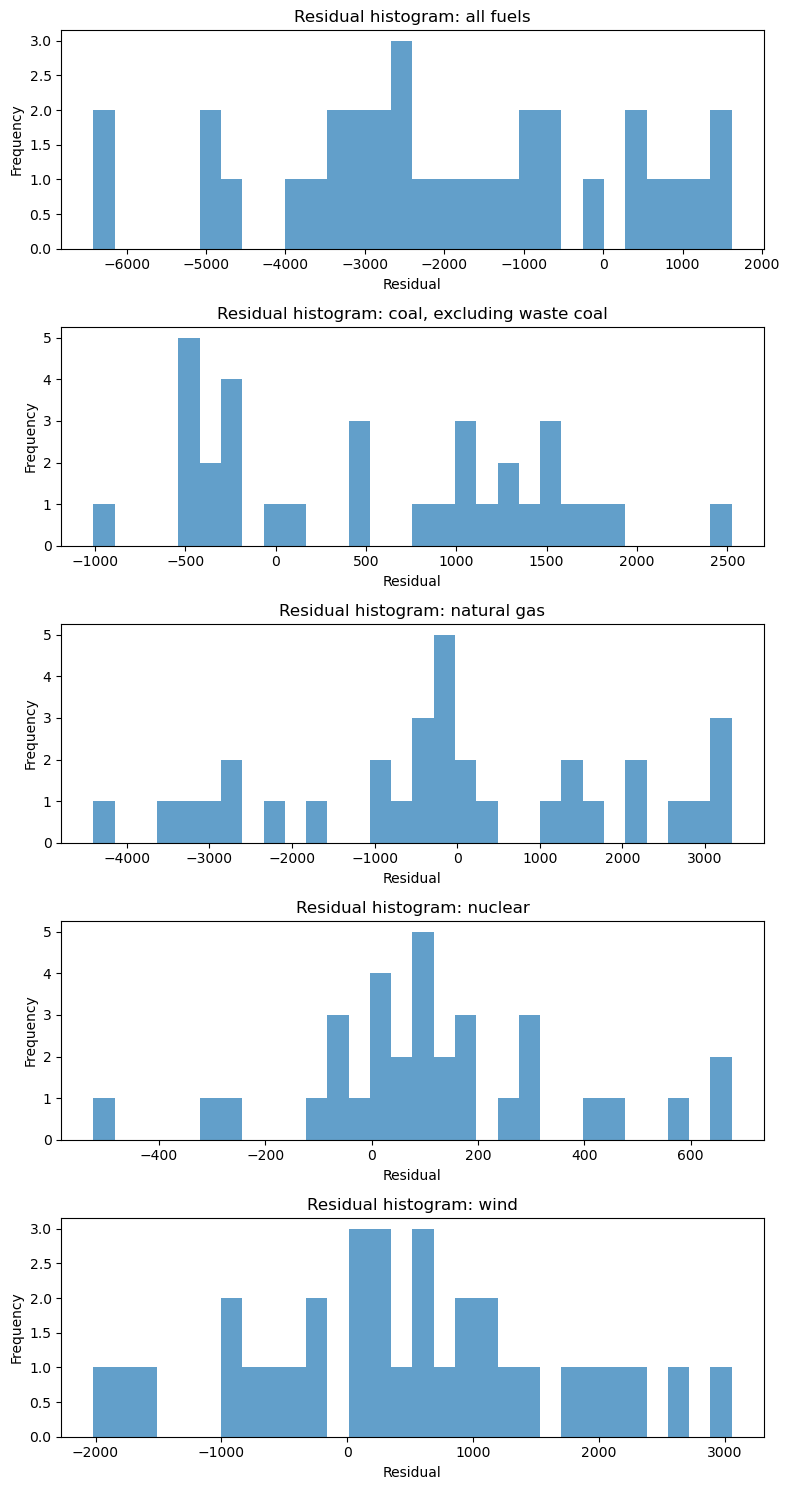

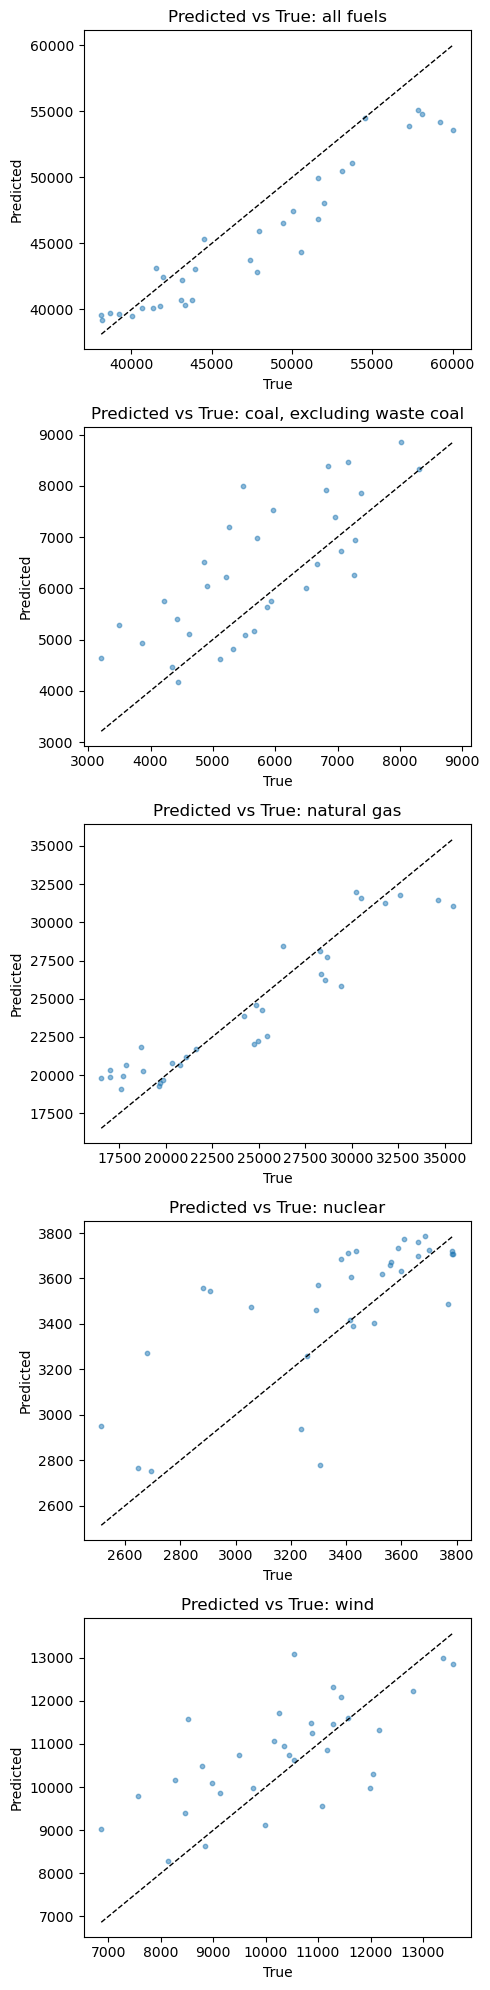

<Figure size 800x400 with 0 Axes>

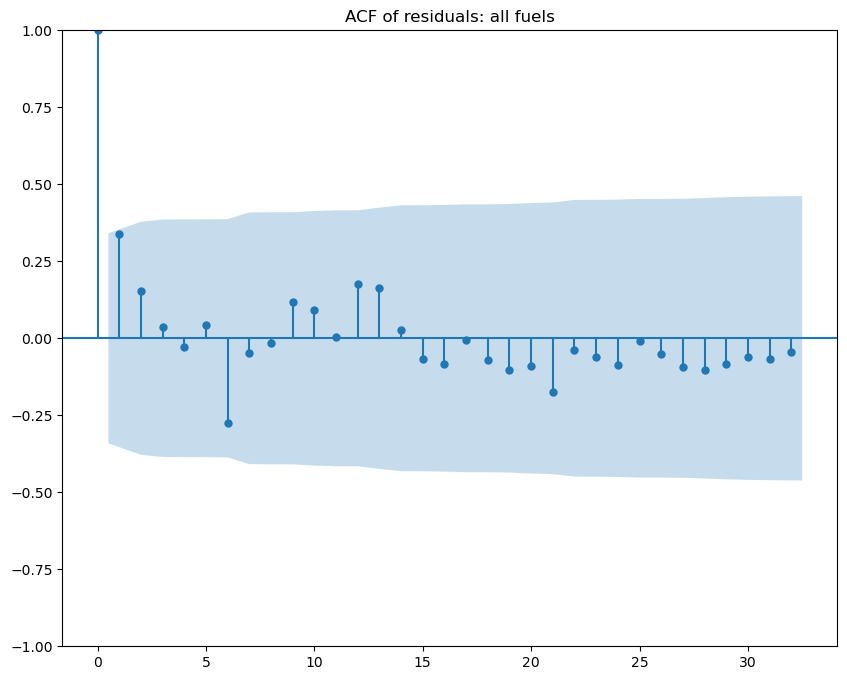

<Figure size 500x500 with 0 Axes>

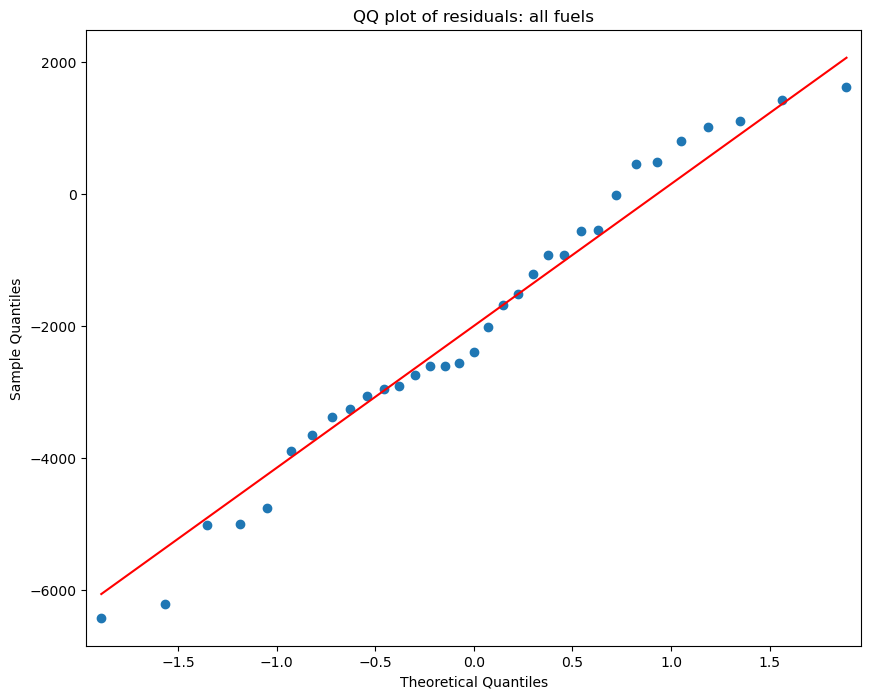

In [44]:
abs_error = residuals.abs()
squared_error = residuals.pow(2)

eps = 1e-9
mape_mask = (y_true.abs() > eps)

mae = abs_error.mean()
rmse = np.sqrt(squared_error.mean())
bias = residuals.mean()  # mean error

mape = (abs_error[mape_mask] / y_true[mape_mask].abs()).mean() * 100

metrics = pd.DataFrame({
    "MAE": mae,
    "RMSE": rmse,
    "Bias": bias,
    "MAPE_%": mape
})

print("Per-column metrics:")
print(metrics)

resid_stack = residuals.stack()
true_stack = y_true.stack()
pred_stack = y_pred.stack()

global_mae = resid_stack.abs().mean()
global_rmse = np.sqrt((resid_stack ** 2).mean())
global_mape = (resid_stack.abs() / (true_stack.abs() + eps)).mean() * 100

print(f"MAE     : {global_mae:.4f}")
print(f"RMSE    : {global_rmse:.4f}")
print(f"MAPE %  : {global_mape:.2f}")


fig, axes = plt.subplots(len(COLS_TO_PLOT), 1, figsize=(10, 3*len(COLS_TO_PLOT)), sharex=True)
if len(COLS_TO_PLOT) == 1:
    axes = [axes]

for ax, col in zip(axes, COLS_TO_PLOT):
    residuals[col].plot(ax=ax)
    ax.axhline(0, color="k", linewidth=1)
    ax.set_title(f"Residuals over time: {col}")
    ax.set_ylabel("Pred - True")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(len(COLS_TO_PLOT), 1, figsize=(8, 3*len(COLS_TO_PLOT)))
if len(COLS_TO_PLOT) == 1:
    axes = [axes]

for ax, col in zip(axes, COLS_TO_PLOT):
    ax.hist(residuals[col].dropna(), bins=30, alpha=0.7)
    ax.set_title(f"Residual histogram: {col}")
    ax.set_xlabel("Residual")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(len(COLS_TO_PLOT), 1, figsize=(5, 4*len(COLS_TO_PLOT)))
if len(COLS_TO_PLOT) == 1:
    axes = [axes]

for ax, col in zip(axes, COLS_TO_PLOT):
    ax.scatter(y_true[col], y_pred[col], alpha=0.5, s=10)
    min_val = min(y_true[col].min(), y_pred[col].min())
    max_val = max(y_true[col].max(), y_pred[col].max())
    ax.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1)
    ax.set_title(f"Predicted vs True: {col}")
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")

plt.tight_layout()
plt.show()

col = y_true.columns[0]

plt.figure(figsize=(8,4))
plot_acf(residuals[col].dropna(), lags=32)
plt.title(f"ACF of residuals: {col}")
plt.show() 

plt.figure(figsize=(5,5))
qqplot(residuals[col].dropna(), line="s")
plt.title(f"QQ plot of residuals: {col}")
plt.show()

In [45]:
residuals


all fuels  coal, excluding waste coal  \
period                                                
2025-09-01 -3896.099784                 -487.198228   
2025-08-01 -3255.889044                  434.503147   
2025-07-01 -2752.017369                 1102.845422   
2025-06-01 -2612.070249                 1563.319889   
2025-05-01 -2912.542890                 1139.424370   
2025-04-01 -3059.445318                  104.534674   
2025-03-01 -2392.249999                 -277.396949   
2025-02-01 -2963.790502                 -508.829397   
2025-01-01 -6215.564603                -1008.031956   
2024-12-01  -931.905158                 -194.389072   
2024-11-01 -1525.005001                 -494.546363   
2024-10-01 -5004.022482                 -498.823169   
2024-09-01 -2569.256405                 -204.824250   
2024-08-01 -5012.545925                  487.084625   
2024-07-01   -23.597700                 1546.093450   
2024-06-01 -2615.692670                 2523.986367   
2024-05-01 -2020.332871                 1651.208047   
2024-04-01 -1208.321118                 1063.717302   
2024-03-01  -549.303600                 1427.975069   
2024-02-01  1107.857647                 1796.727331   
2024-01-01 -3656.964363                 -337.204418   
2023-12-01   476.915821                 1000.247766   
2023-11-01   446.766488                 -441.773325   
2023-10-01  -927.662793                 -242.850222   
2023-09-01 -4760.656315                 -345.661352   
2023-08-01 -6418.938155                   11.446833   
2023-07-01 -3379.582900                  847.842888   
2023-06-01 -1684.611840                 1301.779915   
2023-05-01   793.174639                 1269.636805   
2023-04-01  1423.191221                  965.817909   
2023-03-01  -557.005750                  496.273107   
2023-02-01  1013.280327                 1531.857319   
2023-01-01  1617.326496                 1924.380010   

            conventional hydroelectric  natural gas     nuclear       other  \
period                                                                        
2025-09-01                  -25.410162 -1772.178749  305.457755   83.666273   
2025-08-01                  -45.355556  -763.304986  104.252881  137.869798   
2025-07-01                  -53.397240  1774.218648   27.211959   71.703484   
2025-06-01                  -67.938574  2168.276957   35.505324   70.225330   
2025-05-01                  -90.713259  -234.495326  274.292795   61.179046   
2025-04-01                  -59.616023  2785.441011 -523.534988   48.134881   
2025-03-01                  -72.983407  3306.339447 -280.823717   34.438497   
2025-02-01                  -80.391931   -97.752129    4.724882   18.883233   
2025-01-01                  -46.341525 -2869.648640  147.190725   19.550519   
2024-12-01                   13.415380   105.404379  -63.297108   35.990404   
2024-11-01                   14.551746  -143.787465  590.108720   30.369700   
2024-10-01                   22.033112 -2687.433343  438.742342   44.052316   
2024-09-01                   19.920478 -2323.472996  109.102403   35.036371   
2024-08-01                  -16.751157 -3222.999292  164.639529   28.315177   
2024-07-01                  -24.190791  1126.461492  305.452607   32.763393   
2024-06-01                  -80.942425  -197.206449   91.808972    6.635789   
2024-05-01                  -52.970059  -918.576632  677.026443   29.207844   
2024-04-01                    1.462307  1489.711735  119.725660   28.208610   
2024-03-01                  -17.328328  -217.081149  419.031931   11.845556   
2024-02-01                  -14.153962  3322.355534  -93.961470   12.963032   
2024-01-01                   19.188404 -2725.410616  285.774373   10.916417   
2023-12-01                   38.247770   465.810603  -79.055460    7.251203   
2023-11-01                   31.125135  -337.691201   -1.594632   -2.869161   
2023-10-01                   27.484501    84.743321 -296.926010   -5.348386   
2023-09-01                   17.25

In [46]:
results_df

fuelTypeDescription  seasonal_flag        chosen_model    rmse_test
0                    all fuels           True     HW_add_seasonal  2935.823300
1   coal, excluding waste coal           True     HW_add_seasonal  1075.717363
2   conventional hydroelectric          False  HW_add_no_seasonal    43.411998
3                  natural gas           True     HW_add_seasonal  2089.775591
4                      nuclear           True     HW_add_seasonal   279.668111
5                        other          False  HW_add_no_seasonal    40.335641
6                  other gases          False  HW_add_no_seasonal    37.392438
7               petroleum coke          False  HW_add_no_seasonal     4.470215
8            petroleum liquids          False  HW_add_no_seasonal    45.428755
9     renewable waste products          False  HW_add_no_seasonal     9.044444
10                        wind           True     HW_add_seasonal  1277.949784
11        wood and wood wastes           True  HW_add_no_seasonal    31.332457

In [47]:
def model_sarima(train_data, horizon):

    model = SARIMAX(
        train_data,
        order=(1, 1, 1),
        seasonal_order=(0, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    res = model.fit(disp=False)
    forecast = res.get_forecast(steps=horizon)
    return forecast.predicted_mean

def EWMA(train_data, horizon):

    model = ExponentialSmoothing(
        train_data, 
        trend='add', 
        seasonal='add', 
        seasonal_periods=12
    ).fit(optimized=True)
    
    return model.forecast(horizon)

In [48]:
def run_backtest(series, model_function, train_window, horizon, step):

    results = []
    total_len = len(series)
    start_idx = 0
        
    while True:
        end_train_idx = start_idx + train_window
        
        if end_train_idx >= total_len:
            break
            
        train_series = series.iloc[start_idx : end_train_idx]
        forecast_series = model_function(train_series, horizon)
        start_idx += step
        results.append({
            'cutoff_date': train_series.index[-1],
            'forecast': forecast_series,
            'actuals': series # Store ref to full actuals for plotting later
        })
        

    return results


def evaluate_and_plot(ax, sector_name, results):

    actual_series = results[0]['actuals']
    ax.plot(actual_series.index, actual_series, color='green', linewidth=2, label='Actual Data', zorder=1)
    
    errors = []
    
    first_fc = True
    for item in results:
        fc = item['forecast']
        cutoff = item['cutoff_date']
        

        common_idx = fc.index.intersection(actual_series.index)
        if not common_idx.empty:
            rmse = np.sqrt(mean_squared_error(actual_series[common_idx], fc[common_idx]))
            errors.append(rmse)
        
        label = 'Rolling Forecast' if first_fc else None
        ax.plot(fc.index, fc, color='red', linestyle='--', alpha=0.7, label=label, zorder=2)
        ax.scatter(cutoff, actual_series[cutoff], color='black', s=20, zorder=3)
        first_fc = False

    avg_rmse = np.mean(errors) if errors else 0
    
    ax.set_title(f"{sector_name} | Avg RMSE: {avg_rmse:,.0f}")
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    
    return avg_rmse

In [49]:
SECTORS_MAP = list(fueltype_dfs_train.keys())


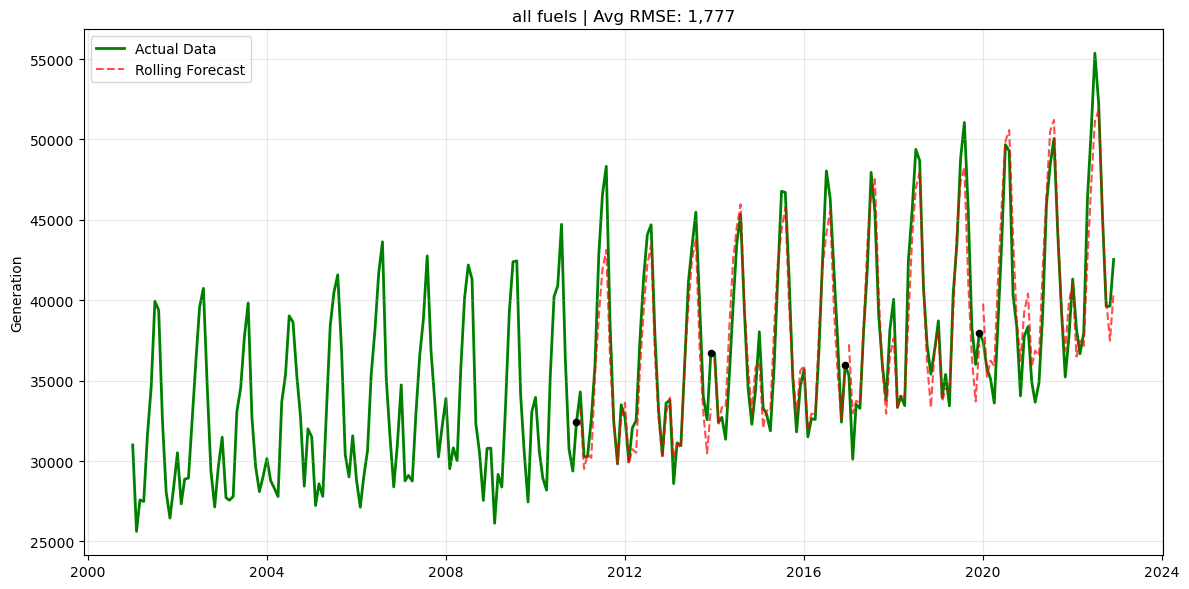

   > all fuels Average RMSE: 1,777.36
--------------------------------------------------


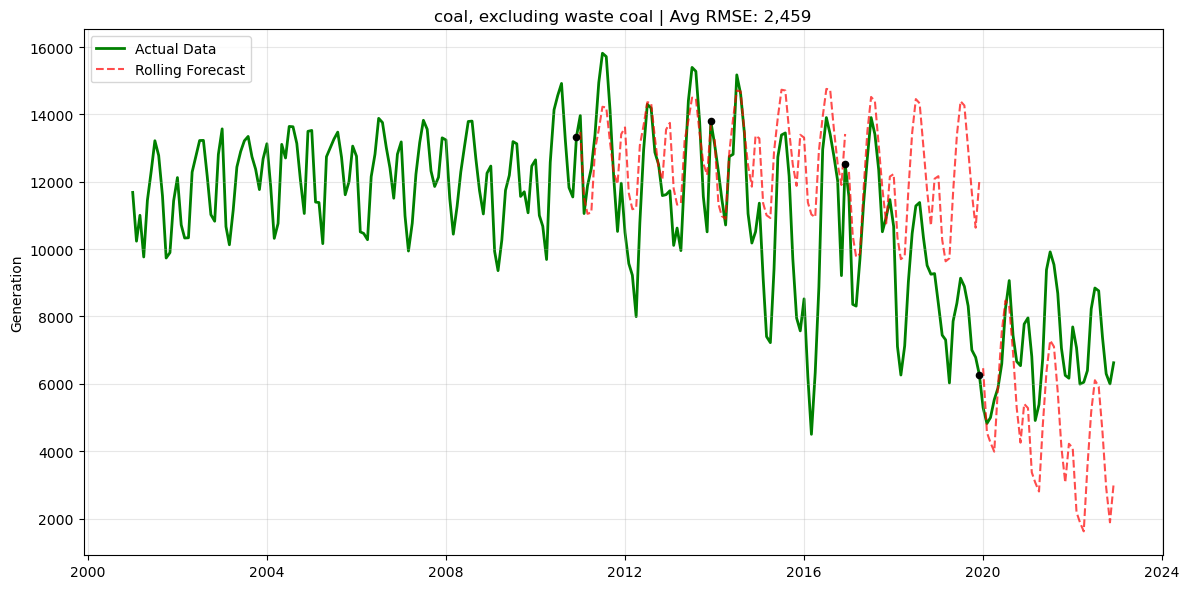

   > coal, excluding waste coal Average RMSE: 2,458.92
--------------------------------------------------


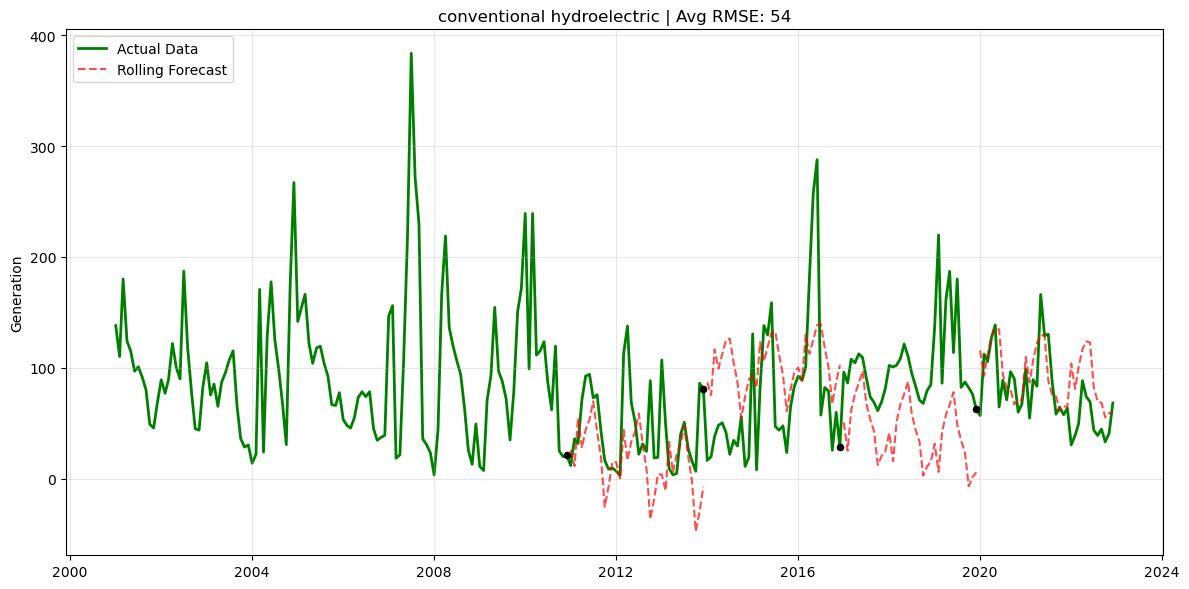

   > conventional hydroelectric Average RMSE: 54.00
--------------------------------------------------


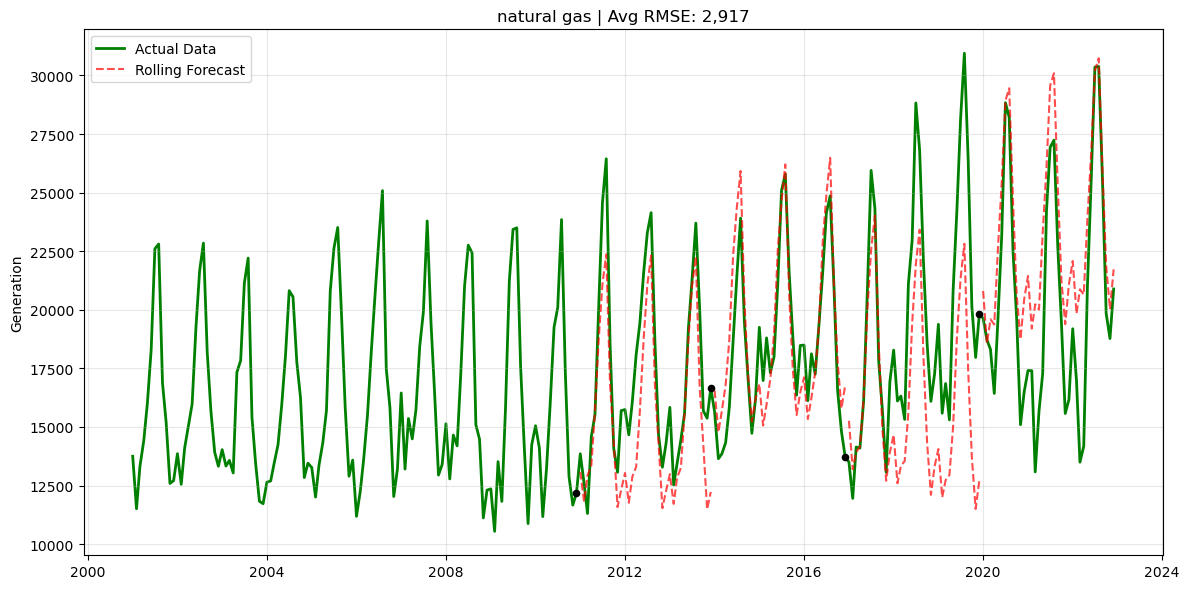

   > natural gas Average RMSE: 2,916.81
--------------------------------------------------


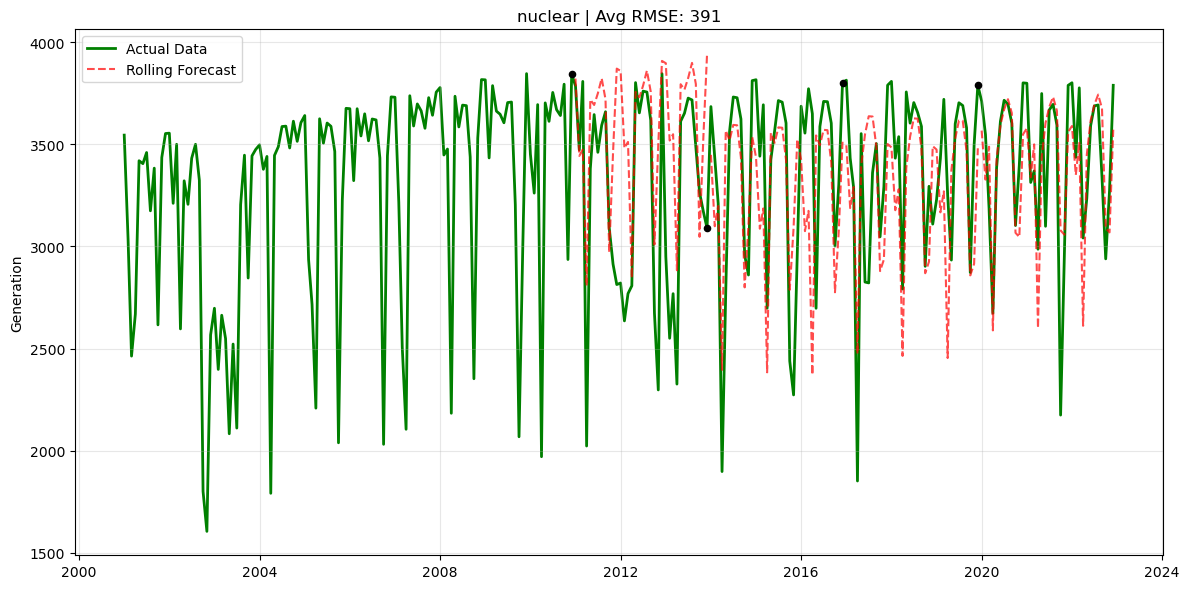

   > nuclear Average RMSE: 391.28
--------------------------------------------------


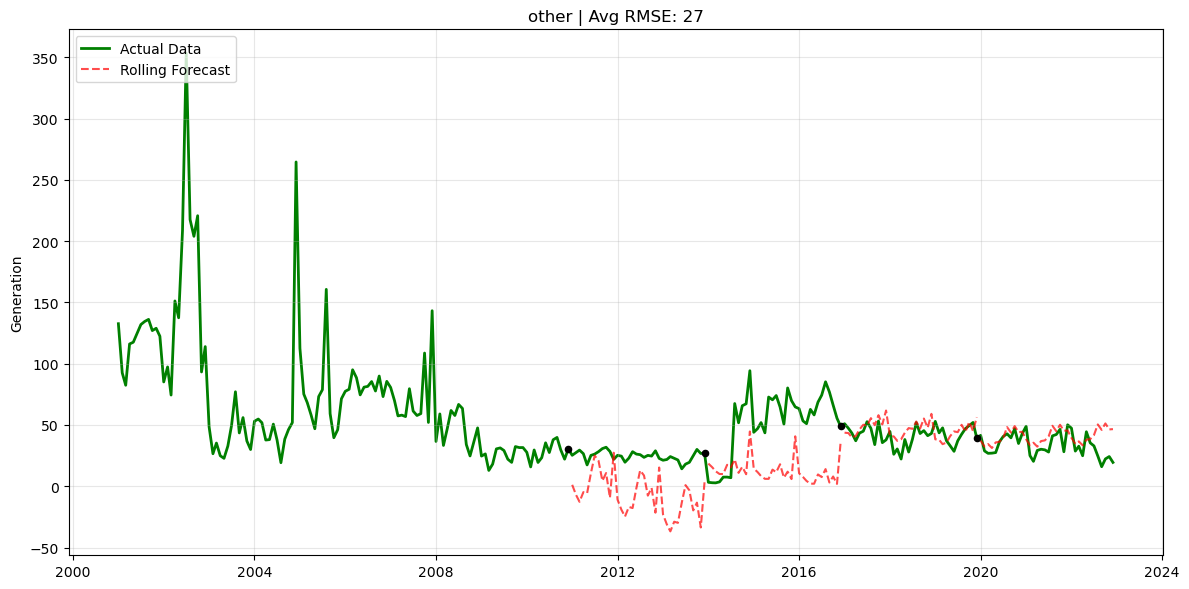

   > other Average RMSE: 26.50
--------------------------------------------------


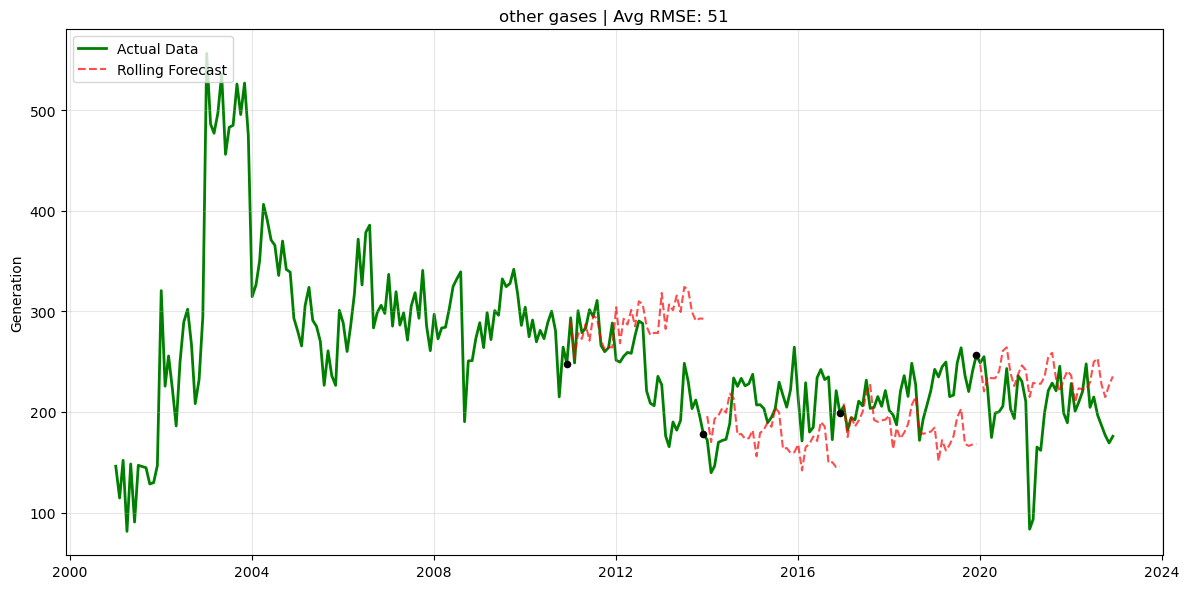

   > other gases Average RMSE: 51.26
--------------------------------------------------


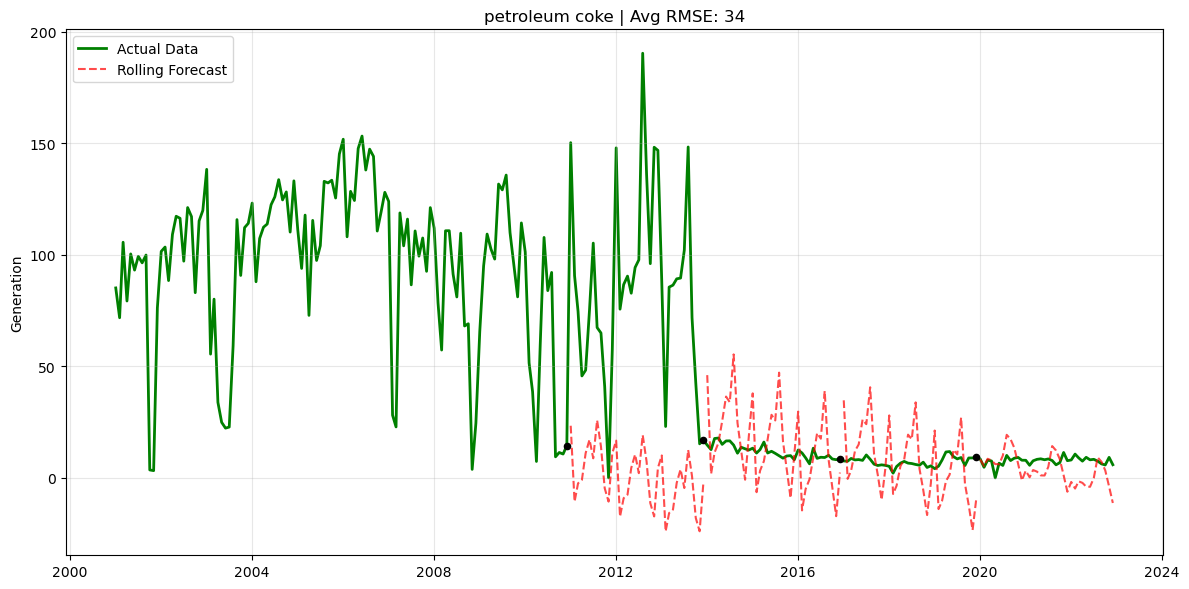

   > petroleum coke Average RMSE: 33.54
--------------------------------------------------


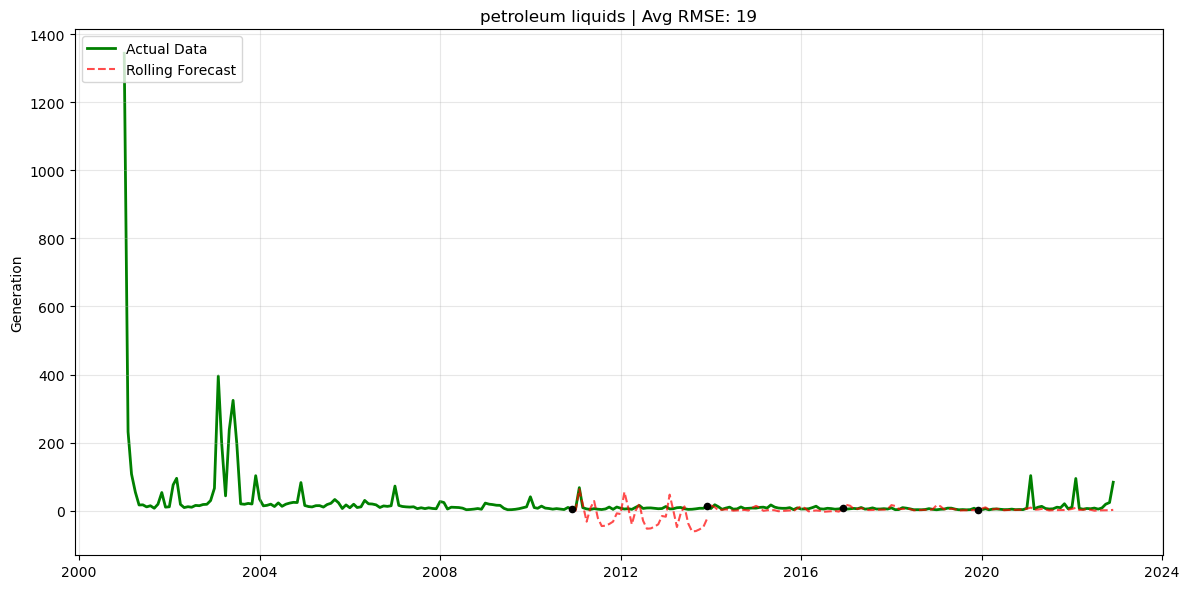

   > petroleum liquids Average RMSE: 19.41
--------------------------------------------------


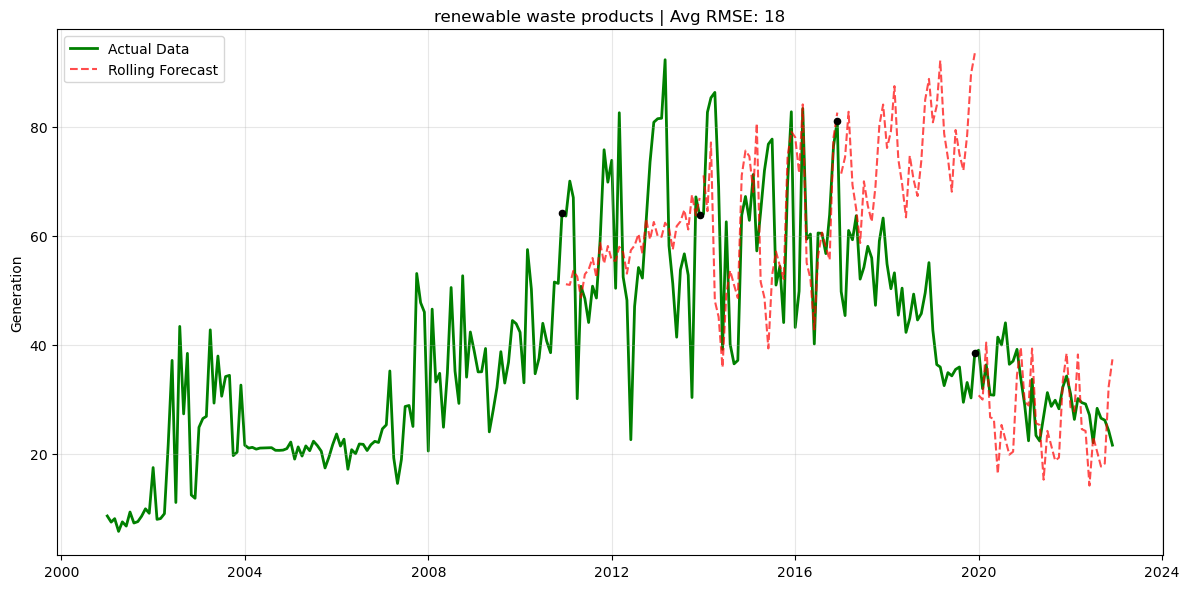

   > renewable waste products Average RMSE: 18.38
--------------------------------------------------


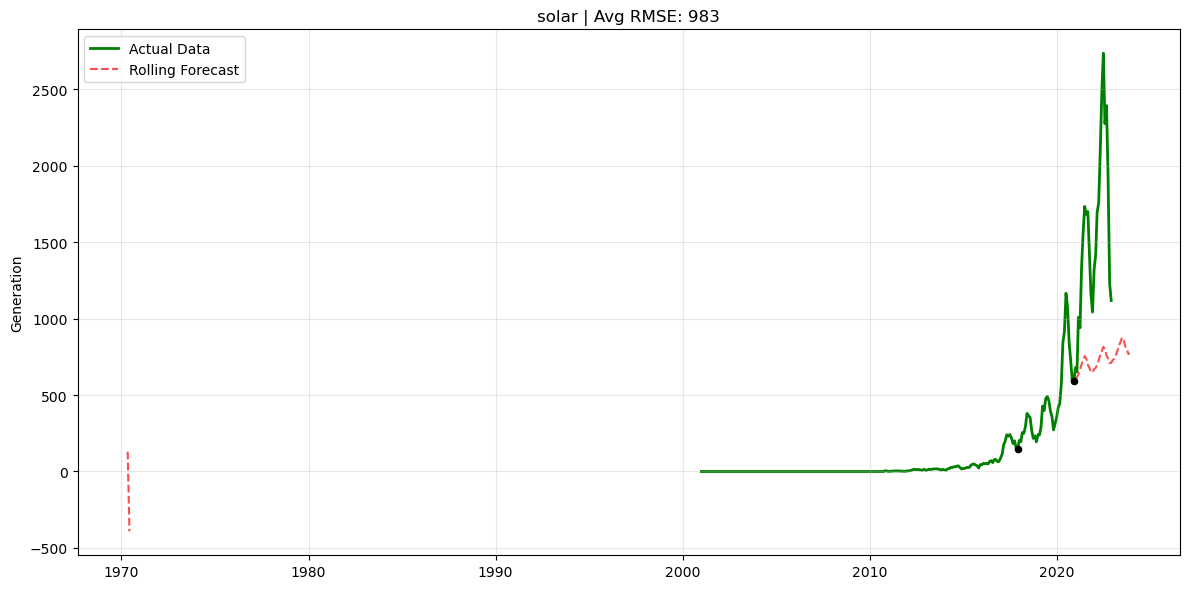

   > solar Average RMSE: 983.47
--------------------------------------------------


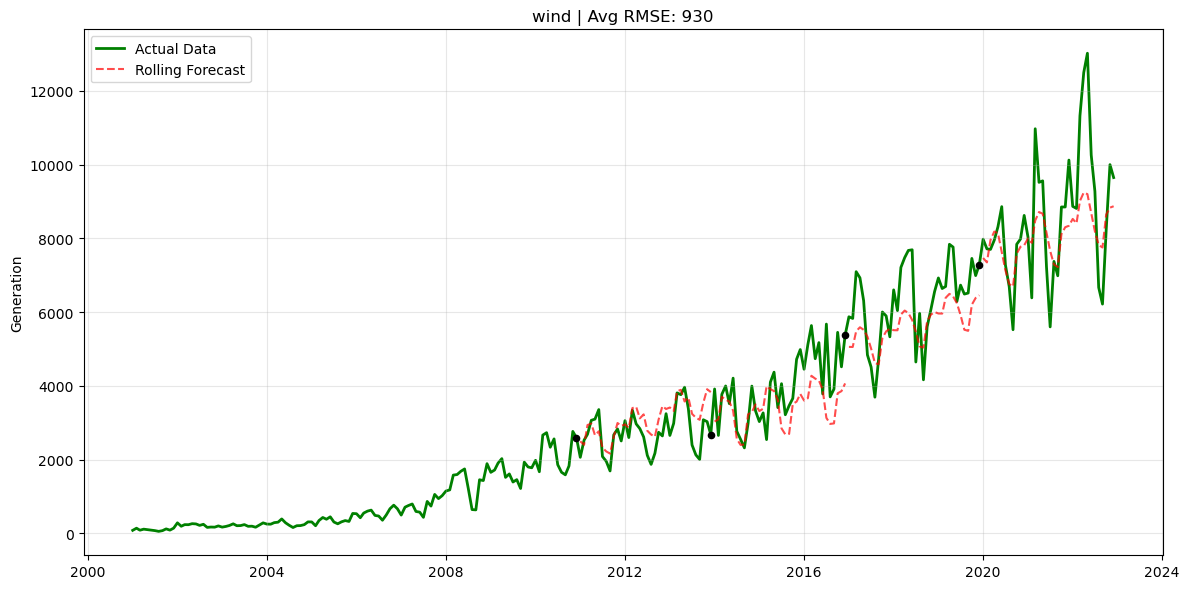

   > wind Average RMSE: 929.89
--------------------------------------------------


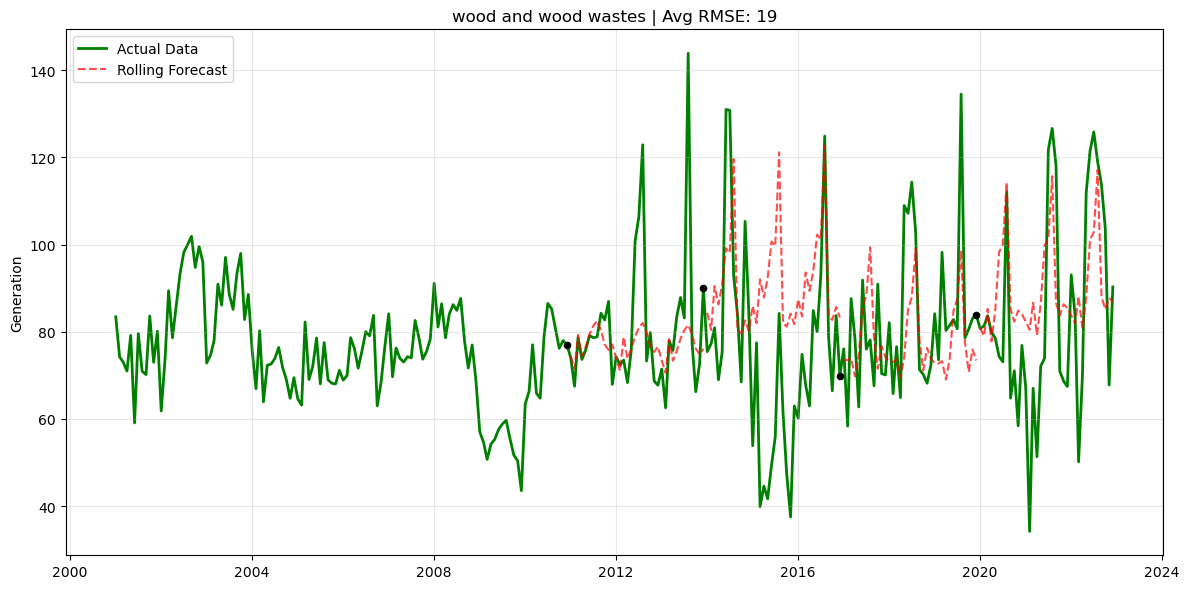

   > wood and wood wastes Average RMSE: 18.76
--------------------------------------------------


In [50]:

CHOSEN_MODEL = EWMA 
TRAIN_WINDOW = 120
FORECAST_HORIZON = 36
STEP_SIZE = 36



for i in SECTORS_MAP:
    
    series = fueltype_dfs_train[i]['generation'].dropna()
    
    results = run_backtest(
        series, 
        CHOSEN_MODEL, 
        TRAIN_WINDOW, 
        FORECAST_HORIZON, 
        STEP_SIZE
    )
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    rmse = evaluate_and_plot(ax, i, results)
    # Optional: Add formatting
    ax.set_ylabel("Generation")
    plt.tight_layout()
    plt.show() # Render immediately
    
    print(f"   > {i} Average RMSE: {rmse:,.2f}")
    print("-" * 50)

In [52]:
forecast_horizon = 24
predictions_future = pd.DataFrame()

for _, row in results_df.iterrows():
    key = row['fuelTypeDescription']
    seasonal_flag = row['seasonal_flag']
    chosen_model = row['chosen_model']

    y_full = fueltype_dfs_train[key]['generation'].astype(float).dropna()
    if key in fueltype_dfs_test:
        y_full = pd.concat(
            [y_full, fueltype_dfs_test[key]['generation'].astype(float).dropna()]
        ).sort_index()

    if 'seasonal' in chosen_model:
        hw_kwargs = dict(trend='add', seasonal='add', seasonal_periods=12)
    else:
        hw_kwargs = dict(trend='add', seasonal=None)

    model = ExponentialSmoothing(y_full, **hw_kwargs).fit(optimized=True)
    fc = model.forecast(forecast_horizon)
    predictions_future[key] = pd.Series(fc, index=pd.date_range(
        start=y_full.index[-1] + pd.offsets.MonthBegin(1),
        periods=forecast_horizon,
        freq='MS'
    ))

In [53]:
predictions_future

all fuels  coal, excluding waste coal  \
2025-10-01  46433.872112                 5063.890239   
2025-11-01  43129.168380                 4523.335895   
2025-12-01  46066.410852                 5574.687070   
2026-01-01  48529.590789                 6217.146600   
2026-02-01  43353.471304                 4569.039167   
2026-03-01  44048.087746                 4120.754128   
2026-04-01  44087.720233                 4280.592066   
2026-05-01  50048.668851                 5771.480565   
2026-06-01  54936.301344                 7152.794373   
2026-07-01  58772.190085                 7697.431374   
2026-08-01  59503.694743                 7264.281348   
2026-09-01  52001.388033                 5860.107322   
2026-10-01  47151.311751                 4547.011485   
2026-11-01  43846.608020                 4006.457141   
2026-12-01  46783.850492                 5057.808316   
2027-01-01  49247.030429                 5700.267846   
2027-02-01  44070.910944                 4052.160413   
2027-03-01  44765.527385                 3603.875374   
2027-04-01  44805.159873                 3763.713312   
2027-05-01  50766.108491                 5254.601811   
2027-06-01  55653.740984                 6635.915619   
2027-07-01  59489.629725                 7180.552620   
2027-08-01  60221.134383                 6747.402594   
2027-09-01  52718.827673                 5343.228568   

            conventional hydroelectric   natural gas      nuclear       other  \
2025-10-01                   56.399272  22029.825832  2865.299303  -82.618660   
2025-11-01                   64.870231  19129.495132  3162.940410  -93.512262   
2025-12-01                   75.327066  20699.074005  3646.223020  -78.040739   
2026-01-01                   89.824434  22962.140365  3638.340253  -94.436854   
2026-02-01                   84.748488  19404.410494  3340.802431 -101.247994   
2026-03-01                  107.290872  18804.826089  3393.238376 -104.105120   
2026-04-01                  107.646301  19552.626199  2712.290089 -103.187314   
2026-05-01                  122.871227  25275.357617  3423.751895 -101.875727   
2026-06-01                  119.344730  28385.596109  3537.694704  -95.014443   
2026-07-01                  108.905821  31841.965268  3628.572510  -88.720318   
2026-08-01                   90.784789  33511.941190  3690.198764  -89.337355   
2026-09-01                   75.973611  27319.546645  3582.895419  -96.484035   
2026-10-01                   54.678645  22347.573181  2874.191815  -91.227724   
2026-11-01                   63.149605  19447.242482  3171.832922 -102.121326   
2026-12-01                   73.606440  21016.821355  3655.115532  -86.649802   
2027-01-01                   88.103808  23279.887714  3647.232765 -103.045917   
2027-02-01                   83.027862  19722.157844  3349.694943 -109.857058   
2027-03-01                  105.570246  19122.573438  3402.130888 -112.714183   
2027-04-01                  105.925675  19870.373548  2721.182601 -111.796377   
2027-05-01                  121.150601  25593.104966  3432.644407 -110.484790   
2027-06-01                  117.624104  28703.343459  3546.587216 -103.623506   
2027-07-01                  107.185195  32159.712617  3637.465022  -97.329381   
2027-08-01                   89.064162  33829.688539  3699.091276  -97.946419   
2027-09-01                   74.252985  27637.293994  3591.787931 -105.093098   

            other gases  petroleum coke  petroleum liquids  \
2025-10-01   161.010255       -8.920733           5.821745   
2025-11-01   161.975119      -11.791380           7.594933   
2025-12-01   170.437354       -0.657612          15.373306   
2026-01-01   183.615769        8.417325          65.049581   
2026-02-01   150.724977      -13.614737          40.500739   
2026-03-01   168.233025       -7.278102          15.925211   
2026-04-01   165.170188       -7.561905           6.800649   
2026-05-01   171.773223       -3.054870          14.179801   
2026-06-01   170.779312       

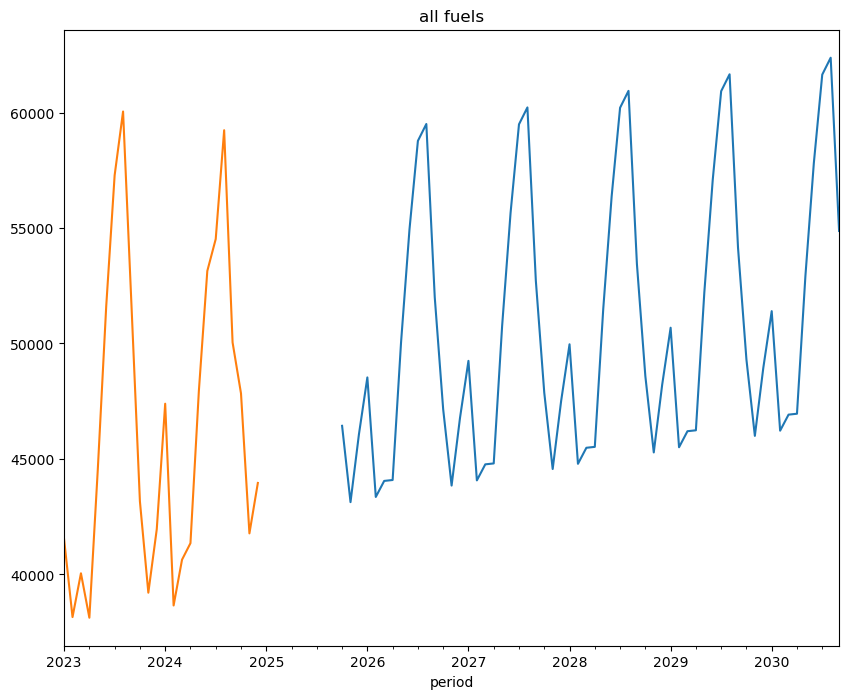

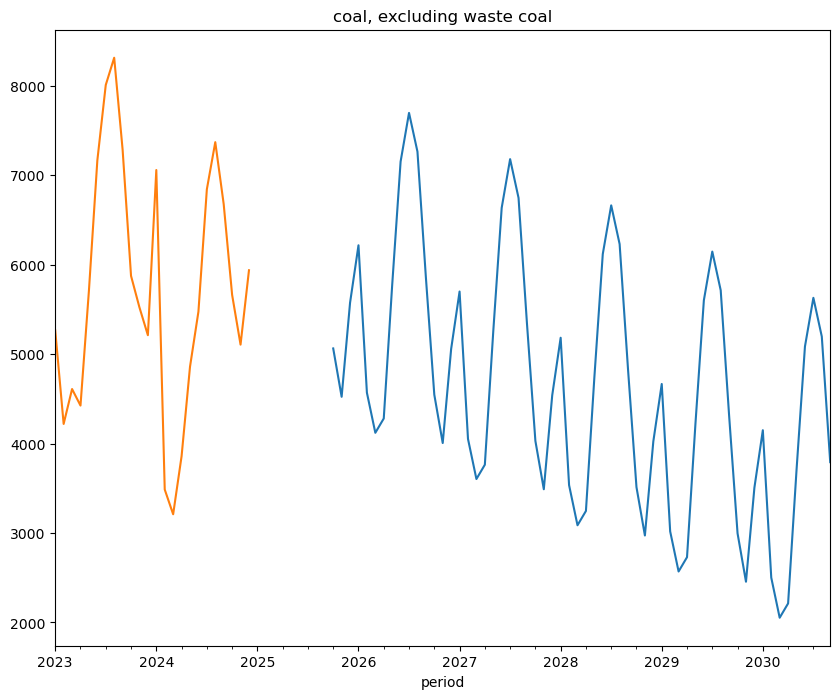

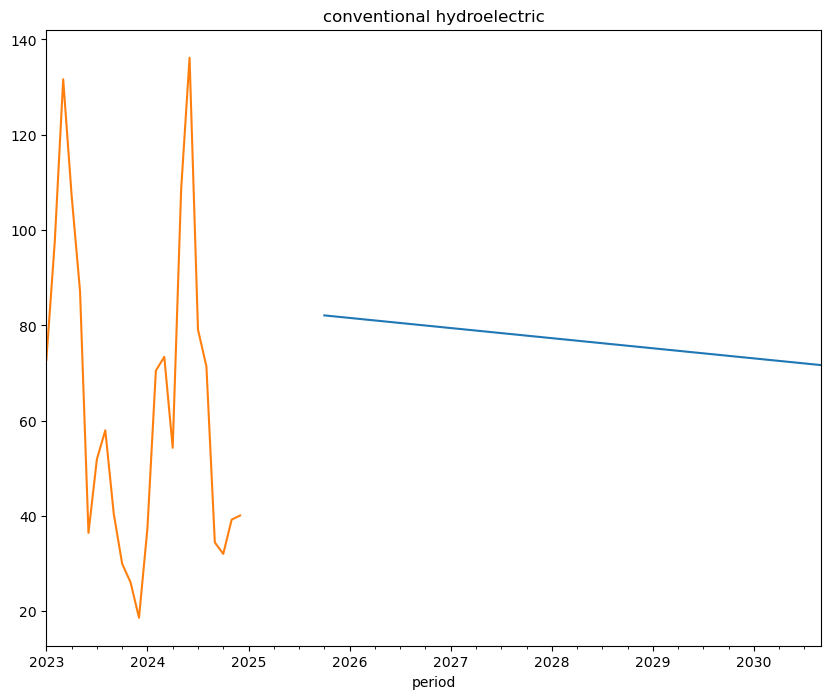

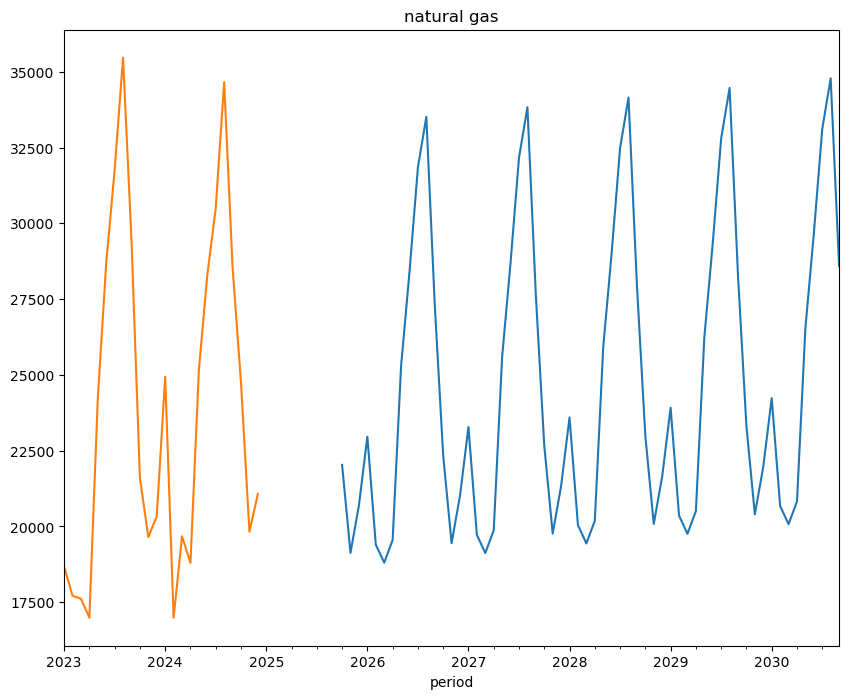

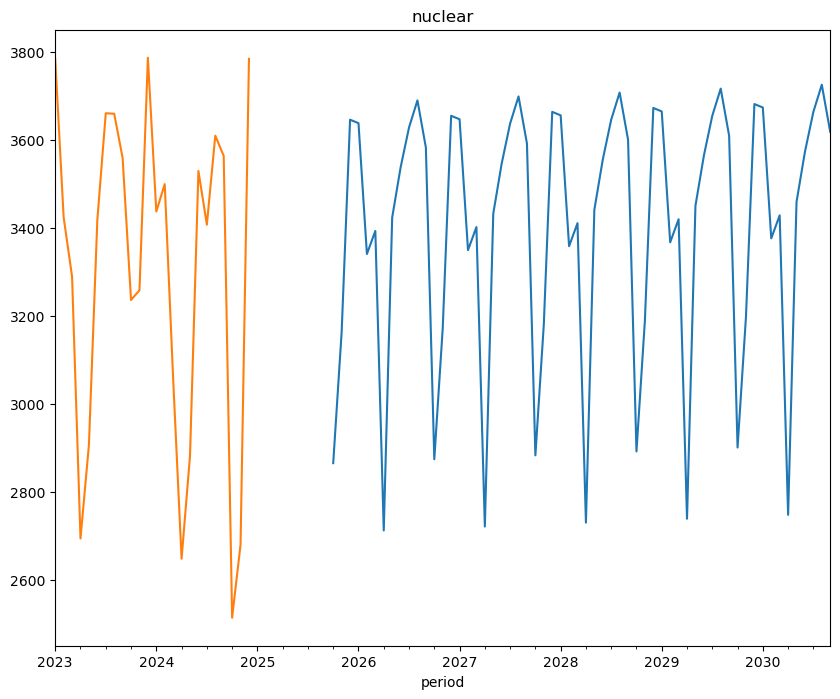

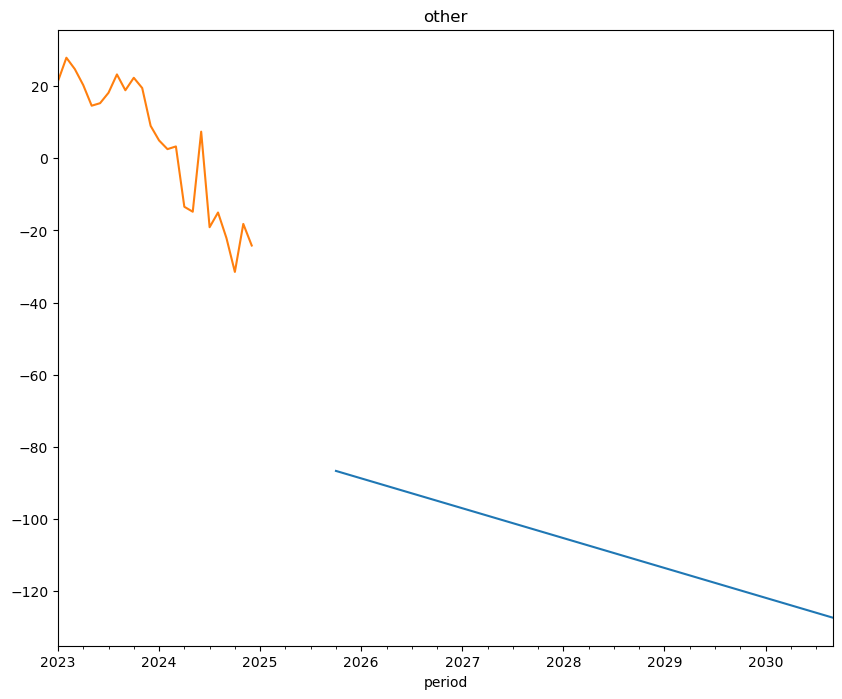

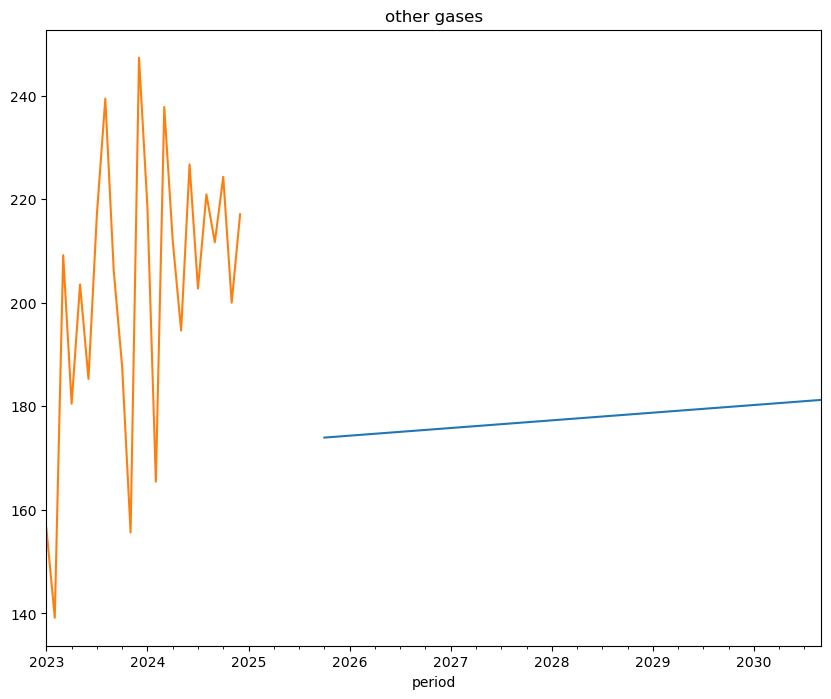

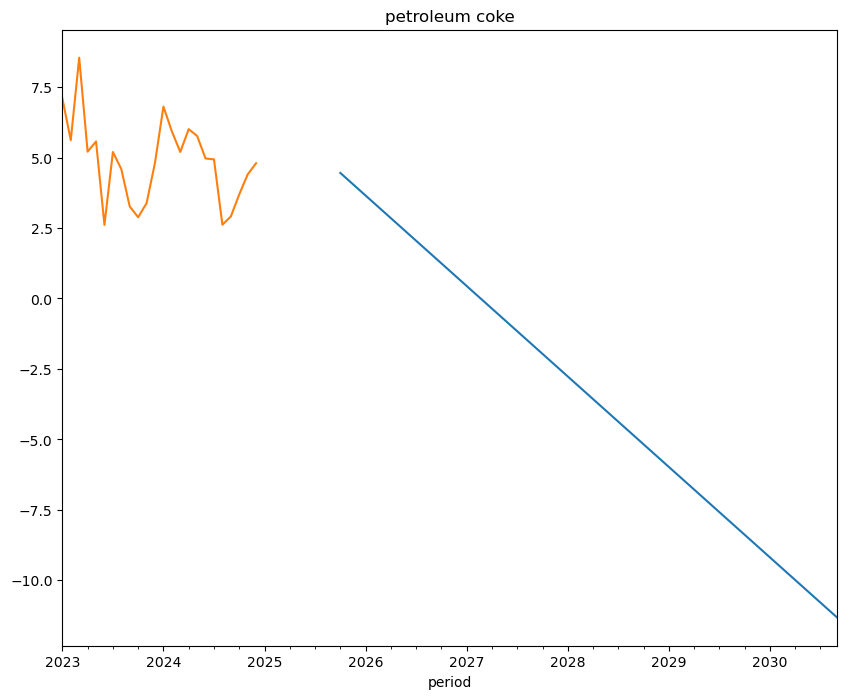

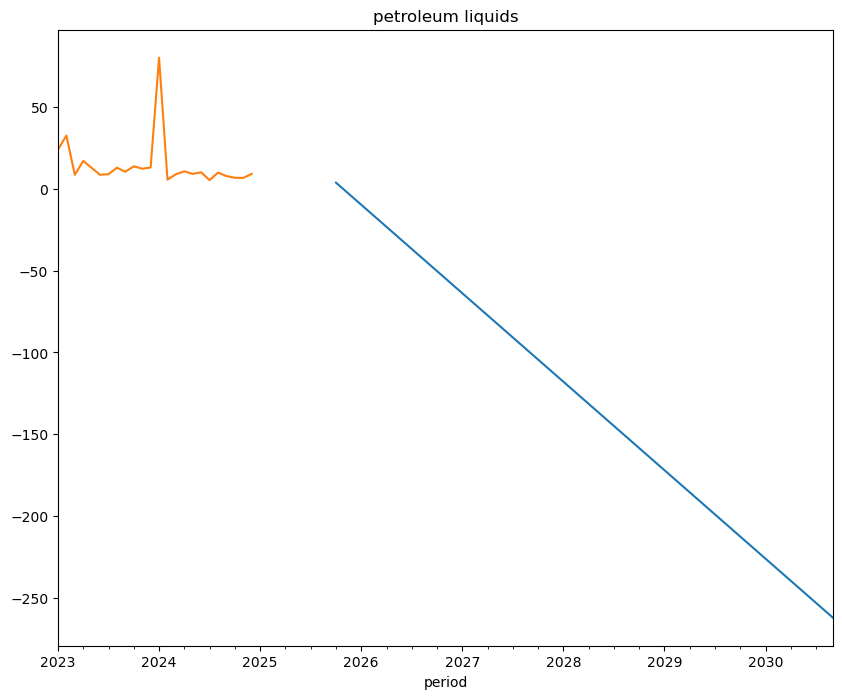

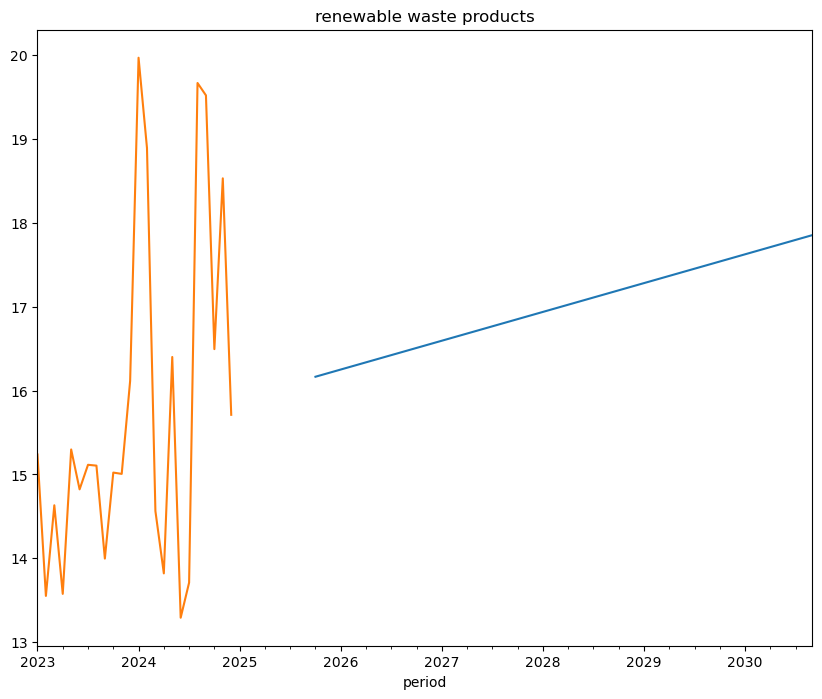

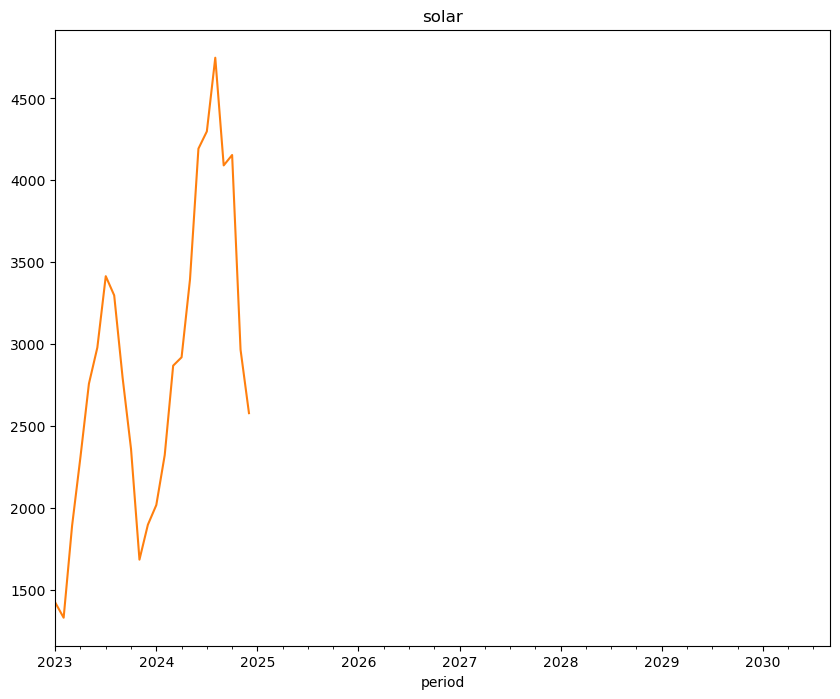

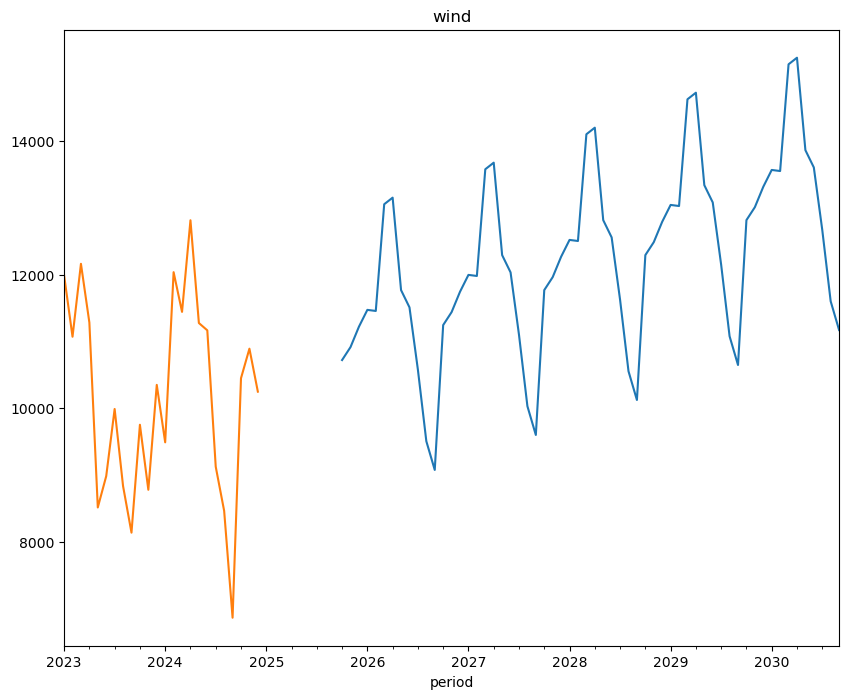

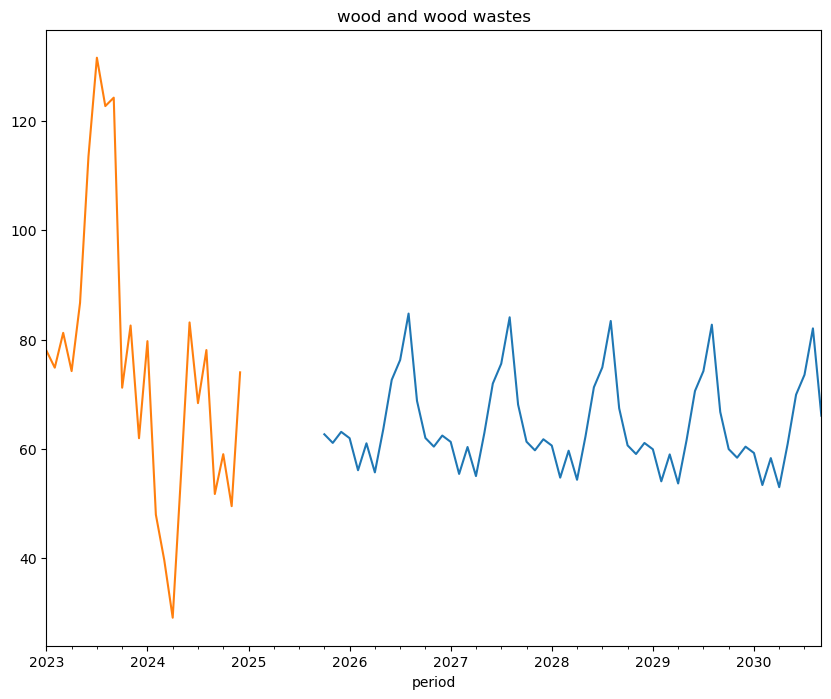

In [54]:
new_df = pd.DataFrame()
for key in fueltype_dfs_test.keys():
    new_df[f'{key}_generation'] = fueltype_dfs_test[key]['generation'].iloc[-24:]
    
fuel_dfs = {}


for i in range(len(predictions_simple.columns)):
    predictions_simple.iloc[:, i].plot()
    new_df.iloc[:, i].plot()
    title = predictions_simple.columns[i]
    plt.title(f"{title}")
    plt.show()
    

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def quick_screen_ccf(target: pd.Series, feature: pd.Series, max_lag: int = 20, plot: bool = True):

    results = []

    for lag in range(1, max_lag + 1):
        shifted_feature = feature.shift(lag) #take each lag
        
        
        correlation = target.corr(shifted_feature) #calculate correlation
        
        common_data = pd.concat([target, shifted_feature], axis=1).dropna() #drop NAs and combine all variables
        n_obs = len(common_data)
        
        significance_threshold = 1.96 / np.sqrt(n_obs) if n_obs > 0 else np.nan #confidence interval

        results.append({
            "lag": lag,
            "correlation": correlation,
            "n_obs": n_obs,
            "significance_threshold": significance_threshold
        })

    df_results = pd.DataFrame(results)

    # 2. Plotting (if requested and data exists)
    if plot and not df_results.empty:
        _plot_ccf(df_results)

    return df_results


def _plot_ccf(df: pd.DataFrame):
    """Helper function to handle plotting logic separately."""
    plt.figure(figsize=(10, 5))
    
    # Create the bar chart
    bars = plt.bar(df["lag"], df["correlation"], color='skyblue', edgecolor='navy', width=0.6)
    
    # Add horizontal reference line at 0
    plt.axhline(0.0, color="black", linewidth=1)

    # Add Significance Bands (95% CI)
    # We take the mean threshold for the visualization if N varies slightly
    avg_threshold = df["significance_threshold"].mean()
    plt.axhspan(-avg_threshold, avg_threshold, alpha=0.2, color='red', label='95% Significance Noise')

    # Styling
    plt.xlabel("Lag k (Feature leads Target by k)")
    plt.ylabel("Correlation Coefficient")
    plt.title("Cross-Correlation Function (CCF)")
    plt.legend(loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

In [56]:
new_rows = df[df['cost-per-btu'].isna() == False]

final_rows = new_rows[new_rows['cost-per-btu'] > 0]
final_rows['fueltypeid'].unique()

ng_cost = final_rows[final_rows['fueltypeid'] == 'NG']['cost-per-btu']
col_gen = df[(df['fueltypeid'] == 'COL') & (df.index > '2010-12-30')]['generation']

In [57]:
col_gen
ng_cost

period
2025-09-01    2.6266
2025-08-01    2.7461
2025-07-01    3.0325
2025-06-01    2.8931
2025-05-01    3.0378
               ...  
2011-05-01    4.4520
2011-04-01    4.4063
2011-03-01    4.0628
2011-02-01    4.5640
2011-01-01    4.3548
Name: cost-per-btu, Length: 176, dtype: float64

In [58]:
diff_1_minus_2 = (col_gen.index).intersection(ng_cost.index)

In [59]:
col_gen = col_gen[diff_1_minus_2]


In [60]:
col_gen

period
2025-09-01     6490.75707
2025-08-01     6954.19688
2025-07-01     6817.80050
2025-06-01     5967.57327
2025-05-01     4902.17097
                 ...     
2011-05-01    13391.27233
2011-04-01    12400.21244
2011-03-01    11878.95733
2011-02-01    11056.73746
2011-01-01    13967.56447
Name: generation, Length: 176, dtype: float64

In [61]:
ng_cost

period
2025-09-01    2.6266
2025-08-01    2.7461
2025-07-01    3.0325
2025-06-01    2.8931
2025-05-01    3.0378
               ...  
2011-05-01    4.4520
2011-04-01    4.4063
2011-03-01    4.0628
2011-02-01    4.5640
2011-01-01    4.3548
Name: cost-per-btu, Length: 176, dtype: float64

In [62]:
ng_cost_diff = ng_cost.diff(1)
col_gen_diff = col_gen.diff(1)

In [63]:
ng_cost_diff.corr(col_gen_diff)

0.0544578424803447

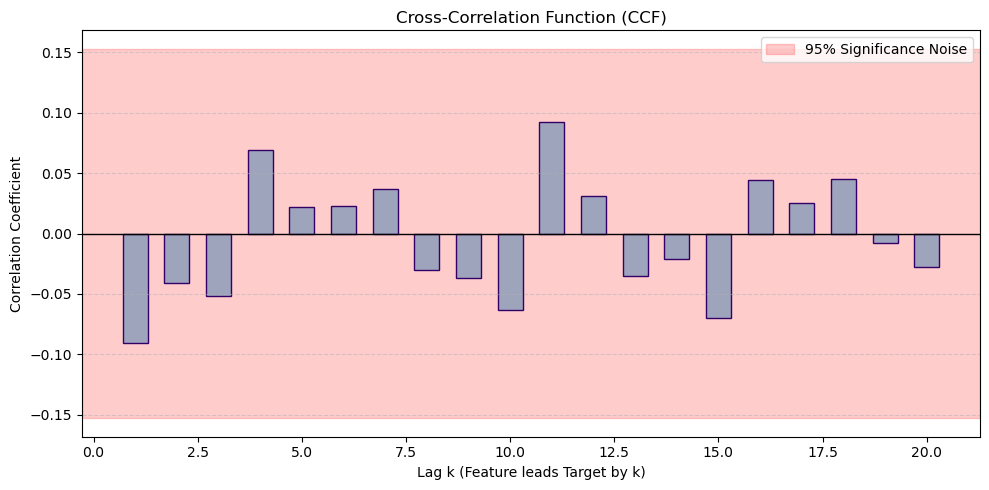

lag  correlation  n_obs  significance_threshold
0     1    -0.090536    174                0.148587
1     2    -0.041122    173                0.149016
2     3    -0.051853    172                0.149449
3     4     0.069268    171                0.149885
4     5     0.021736    170                0.150325
5     6     0.023168    169                0.150769
6     7     0.037063    168                0.151217
7     8    -0.030578    167                0.151669
8     9    -0.036638    166                0.152126
9    10    -0.063478    165                0.152586
10   11     0.092228    164                0.153050
11   12     0.031147    163                0.153519
12   13    -0.035173    162                0.153992
13   14    -0.020768    161                0.154470
14   15    -0.070176    160                0.154952
15   16     0.044472    159                0.155438
16   17     0.025162    158                0.155929
17   18     0.044893    157                0.156425
18   19    -0.008203    156                0.156926
19   20    -0.027933    155                0.157431

In [64]:
quick_screen_ccf(ng_cost_diff, col_gen_diff, plot=True)

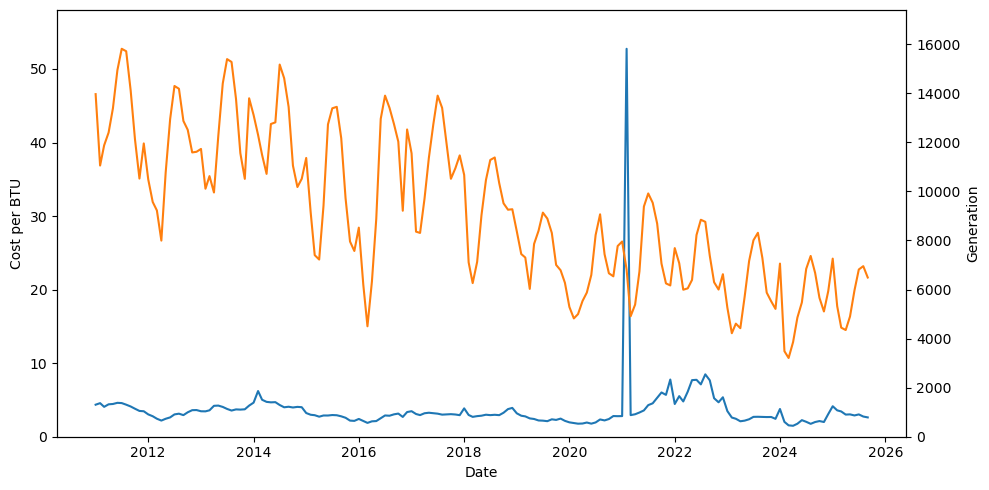

In [65]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Left axis: NG cost-per-btu
ax1.plot(ng_cost.index, ng_cost.values, label='NG cost-per-btu')
ax1.set_ylabel('Cost per BTU')
ax1.set_xlabel('Date')

# Optional: tighten y-limits
ax1.set_ylim(0, ng_cost.max() * 1.1)

# Right axis: COL generation
ax2 = ax1.twinx()
ax2.plot(col_gen.index, col_gen.values, color='C1', label='COL generation')
ax2.set_ylabel('Generation')

# Optional: tighten y-limits
ax2.set_ylim(0, col_gen.max() * 1.1)

fig.tight_layout()
plt.show()

In [66]:
grouped = df.groupby("period")
num_groups = grouped.ngroups
rows_per_group = grouped.size()

print("Number of groups:", num_groups)
print("Number of rows in each group:")
print(rows_per_group)

Number of groups: 297
Number of rows in each group:
period
2001-01-01    13
2001-02-01    13
2001-03-01    13
2001-04-01    13
2001-05-01    13
              ..
2025-05-01    13
2025-06-01    13
2025-07-01    13
2025-08-01    13
2025-09-01    13
Length: 297, dtype: int64
